***Necessary Imports*** 

---



In [ ]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
from glob import glob 
import os 
import time 
from IPython.display import display 
import gc 
from wordcloud import WordCloud 
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from tqdm import tqdm 
import scipy as sp 

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader, Dataset 

***Unzipping the dataset to be used by the code***

---



In [ ]:
!unzip /content/learnplatform-covid19-impact-on-digital-learning.zip

Archive:  /content/learnplatform-covid19-impact-on-digital-learning.zip
replace README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: N\


***Spark Imports and Usage***

---


In [ ]:
!pip install pyspark==2.4.2

     |████████████████████████████████| 193.9 MB 20 kB/s 
     |████████████████████████████████| 197 kB 67.4 MB/s 
  Created wheel for pyspark: filename=pyspark-2.4.2-py2.py3-none-any.whl size=194264321 sha256=743a6ad9fe12e7aef21fde5c45d60ed867e4b1da795e239408e097e7f32315a3
  Stored in directory: /root/.cache/pip/wheels/6d/87/6c/8f2c5da1ec8f9328b2b505138798da07d7658220919005ec47
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

In [ ]:
dis = spark.read.csv('/content/districts_info.csv', header=True).show(10)

+-----------+--------------+------+------------------+----------------+------------------------+--------------+
|district_id|         state|locale|pct_black/hispanic|pct_free/reduced|county_connections_ratio|  pp_total_raw|
+-----------+--------------+------+------------------+----------------+------------------------+--------------+
|       8815|      Illinois|Suburb|          [0, 0.2[|        [0, 0.2[|               [0.18, 1[|[14000, 16000[|
|       2685|           NaN|   NaN|               NaN|             NaN|                     NaN|           NaN|
|       4921|          Utah|Suburb|          [0, 0.2[|      [0.2, 0.4[|               [0.18, 1[|  [6000, 8000[|
|       3188|           NaN|   NaN|               NaN|             NaN|                     NaN|           NaN|
|       2238|           NaN|   NaN|               NaN|             NaN|                     NaN|           NaN|
|       5987|     Wisconsin|Suburb|          [0, 0.2[|        [0, 0.2[|               [0.18, 1[|[10000, 

In [ ]:
pro = spark.read.csv('/content/products_info.csv', header=True)

In [ ]:
pro.show(10)

+-----+--------------------+--------------+---------------------+--------------------+--------------------------+
|LP ID|                 URL|  Product Name|Provider/Company Name|           Sector(s)|Primary Essential Function|
+-----+--------------------+--------------+---------------------+--------------------+--------------------------+
|13117|https://www.splas...|   SplashLearn|        StudyPad Inc.|             PreK-12|      LC - Digital Lear...|
|66933|https://abcmouse.com|  ABCmouse.com| Age of Learning, ...|             PreK-12|      LC - Digital Lear...|
|50479|https://www.abcya...|        ABCya!|       ABCya.com, LLC|             PreK-12|      LC - Sites, Resou...|
|92993|http://www.aleks....|         ALEKS|  McGraw-Hill PreK-12|  PreK-12; Higher Ed|      LC - Digital Lear...|
|73104|https://www.achie...|   Achieve3000|          Achieve3000|             PreK-12|      LC - Digital Lear...|
|37600|http://www.active...|Actively Learn|       Actively Learn|             PreK-12|  

In [ ]:
pro.withColumnRenamed("LP ID", "lp_id").printSchema()

root
 |-- lp_id: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Provider/Company Name: string (nullable = true)
 |-- Sector(s): string (nullable = true)
 |-- Primary Essential Function: string (nullable = true)



In [ ]:
engage = spark.read.csv("/content/engagement_data")
engage.show(10)

+----------+-----+----------+----------------+
|       _c0|  _c1|       _c2|             _c3|
+----------+-----+----------+----------------+
|      time|lp_id|pct_access|engagement_index|
|2020-01-01|16633|      0.01|            0.13|
|2020-01-01|92844|      0.02|            1.04|
|2020-01-01|40967|         0|            0.03|
|2020-01-01|29620|         0|            0.03|
|2020-01-01|15254|      0.08|           14.83|
|2020-01-01|73548|         0|            0.43|
|2020-01-01|28504|      0.05|            5.04|
|2020-01-01|17307|         0|            null|
|2020-01-01|96034|         0|             0.1|
+----------+-----+----------+----------------+
only showing top 10 rows



***Select columns for use***

---



In [ ]:
%time 

districs = pd.read_csv("/content/districts_info.csv", usecols=["district_id", "state", "locale"])
product = pd.read_csv("/content/products_info.csv", usecols=["LP ID", "Primary Essential Function", "Provider/Company Name"])
districs = districs.rename(columns={"district_id": "id"})
product = product.rename(columns={"LP ID": "lp id"})
engagement = pd.DataFrame()

count = 0 
for i, f in enumerate(glob("/content/engagement_data/*.csv")):
    df = pd.read_csv(f)
    df["id"] = int(f.split("/")[-1].split(".")[0])
    engagement = pd.concat([engagement, df])
    count += 1 
    if count == 100:
        break

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.39 µs


In [ ]:
display(districs.isnull().sum().to_frame())
display(product.isnull().sum().to_frame())
display(engagement.isnull().sum().to_frame())

,0
id,0
state,57
locale,57


,0
lp id,0
Provider/Company Name,1
Primary Essential Function,20


,0
time,0
lp_id,106
pct_access,36
engagement_index,2174850
id,0


***Merge Datasets***

---



In [ ]:
%%time

df = pd.merge(districs, engagement, how="right", left_on="id", right_on="id")
df = pd.merge(df, product, how="left", left_on="lp_id", right_on="lp id")
df.drop(["lp id", "id", "lp_id"], axis=1, inplace=True)

del districs, product, engagement
gc.collect()

CPU times: user 4.88 s, sys: 1.19 s, total: 6.06 s
Wall time: 6.08 s


In [ ]:
df.head()

,state,locale,time,pct_access,engagement_index,Provider/Company Name,Primary Essential Function
0,NaN,NaN,2020-01-01,0.03,0.31,Netflix,"LC - Sites, Resources & Reference - Streaming ..."
1,NaN,NaN,2020-01-01,0.00,NaN,Google LLC,SDO - Learning Management Systems (LMS)
2,NaN,NaN,2020-01-01,0.00,NaN,Quizlet,LC - Study Tools
3,NaN,NaN,2020-01-02,0.00,NaN,TEACHERSPAYTEACHERS,CM - Teacher Resources - Lesson Planning
4,NaN,NaN,2020-01-02,0.00,NaN,PowerSchool Group LLC,"SDO - Data, Analytics & Reporting - Student In..."


In [ ]:
print(df.shape)

(8943080, 7)


In [ ]:
%%time 


def split_essential_main(x):
    if type(x) != list:
        return "missing"
    else:
        return x[0]
    
def split_essential_sub(x):
    if type(x) != list or len(x) == 1:
        return "missing"
    else:
        return x[1]
        
# datetime 
df["time"] = pd.to_datetime(df.time)
df["week"] = df.time.dt.dayofweek 
df["holiday"] = df.week.apply(lambda x: 1 if x in [5, 6] else 0)
d = pd.date_range(start="2020-01-01", end="2020-01-19")
df["is_pandemic"] = df.time.apply(lambda x: 0 if x in d else 1)
df.drop("week", axis=1, inplace=True)

# primary essential functions 
df["Primary Essential Function"] = df["Primary Essential Function"].fillna("missing")
df["split"] = df["Primary Essential Function"].apply(lambda x: x.split("-"))
df["main"] = df.split.apply(split_essential_main)
df["sub"] = df.split.apply(split_essential_sub)
df.drop("split", axis=1, inplace=True)

gc.collect()

CPU times: user 2min 32s, sys: 1.92 s, total: 2min 34s
Wall time: 2min 34s


In [ ]:
df

,state,locale,time,pct_access,engagement_index,Provider/Company Name,Primary Essential Function,holiday,is_pandemic,main,sub
0,NaN,NaN,2020-01-01,0.03,0.31,Netflix,"LC - Sites, Resources & Reference - Streaming ...",0,0,LC,"Sites, Resources & Reference"
1,NaN,NaN,2020-01-01,0.00,NaN,Google LLC,SDO - Learning Management Systems (LMS),0,0,SDO,Learning Management Systems (LMS)
2,NaN,NaN,2020-01-01,0.00,NaN,Quizlet,LC - Study Tools,0,0,LC,Study Tools
3,NaN,NaN,2020-01-02,0.00,NaN,TEACHERSPAYTEACHERS,CM - Teacher Resources - Lesson Planning,0,0,CM,Teacher Resources
4,NaN,NaN,2020-01-02,0.00,NaN,PowerSchool Group LLC,"SDO - Data, Analytics & Reporting - Student In...",0,0,SDO,"Data, Analytics & Reporting"
...,...,...,...,...,...,...,...,...,...,...,...
8943075,Indiana,Town,2020-12-31,0.02,6.11,NaN,missing,0,1,missing,missing
8943076,Indiana,Town,2020-12-31,0.02,4.89,Starfall Education,"LC - Sites, Resources & Reference - Games & Si...",0,1,LC,"Sites, Resources & Reference"
8943077,Indiana,Town,2020-12-31,0.07,10.75,Google LLC,LC - Content Creation & Curation,0,1,LC,Content Creation & Curation
8943078,Indiana,Town,2020-12-31,0.02,0.24,Future US Inc,"LC - Sites, Resources & Reference",0,1,LC,"Sites, Resources & Reference"


***Value counts***

---



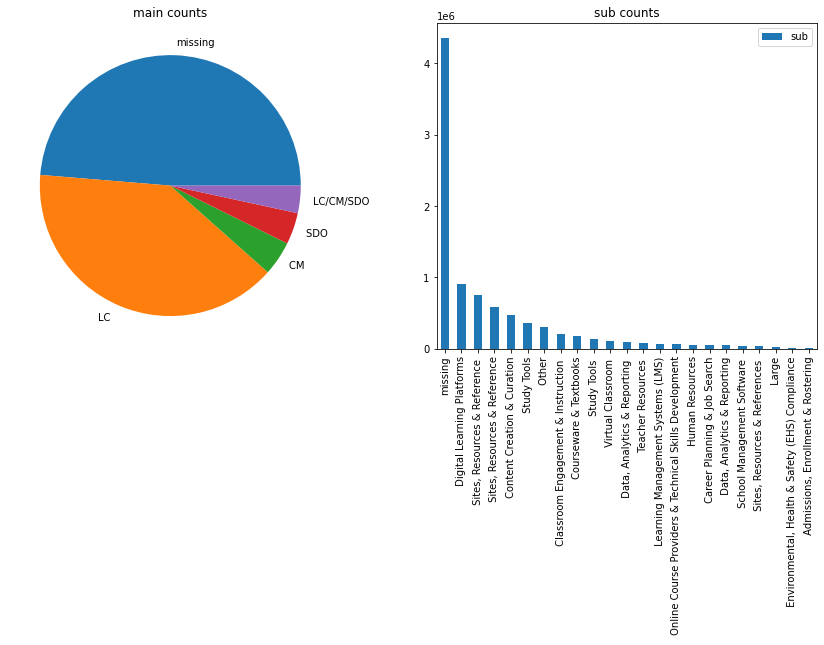

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

main = df.main.value_counts()
ax[0].pie(x=main.values, labels=main.index)
ax[0].set_title("main counts")

sub = df["sub"].value_counts().to_frame()
sub.plot(kind="bar", ax=ax[1])
ax[1].set_title("sub counts")

del sub, main 
gc.collect()

plt.show()

***Sub counts for a specific main***

---



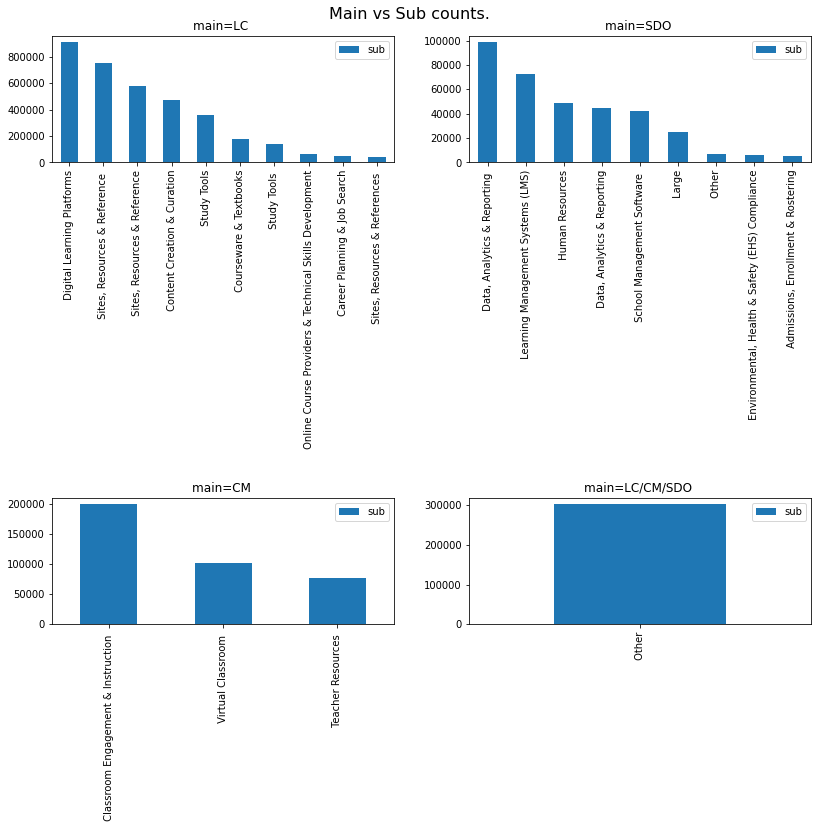

In [ ]:
def main_plot(df, n=10):
    main = df.loc[df.main != "missing", "main"].unique()
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    ax = axes.ravel()
    
    for i, m in enumerate(main):
        x = df.loc[df.main == m, "sub"].value_counts().to_frame().sort_values("sub", ascending=False)[:n]
        x.plot(kind="bar", ax=ax[i])
        ax[i].set_title(f"main={m}")
    del main 
    plt.suptitle("Main vs Sub counts.", fontsize=16)
    plt.tight_layout(pad=3.0)

main_plot(df)

***Counts of value with respect to locale and statements***

---



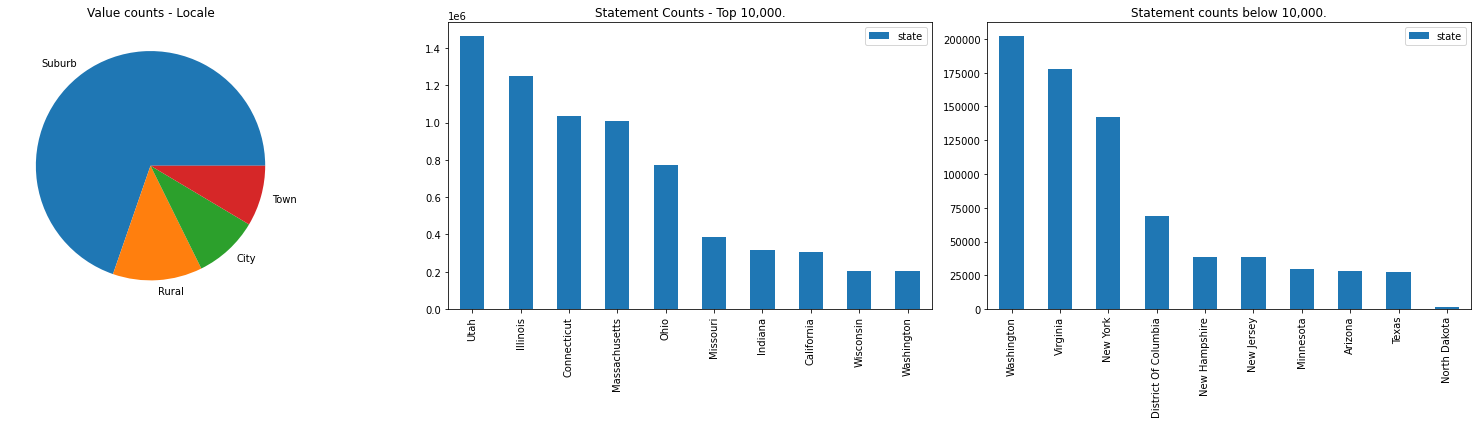

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(22, 6))
ax = axes.ravel()

local = df.locale.value_counts()
ax[0].pie(x=local.values, labels=local.index, )
ax[0].set_title("Value counts - Locale")

state = df.state.value_counts().to_frame()
state.sort_values("state", ascending=False)[:10].plot(kind="bar", ax=ax[1])
ax[1].set_title("Statement Counts - Top 10,000.")

state.sort_values("state", ascending=False)[-10:].plot(kind="bar", ax=ax[2])
ax[2].set_title("Statement counts below 10,000.")

del state, local 
gc.collect()
plt.tight_layout()

***Categorization of various developed cities with respect to the locale***

---



CPU times: user 31.1 s, sys: 657 ms, total: 31.8 s
Wall time: 31.5 s


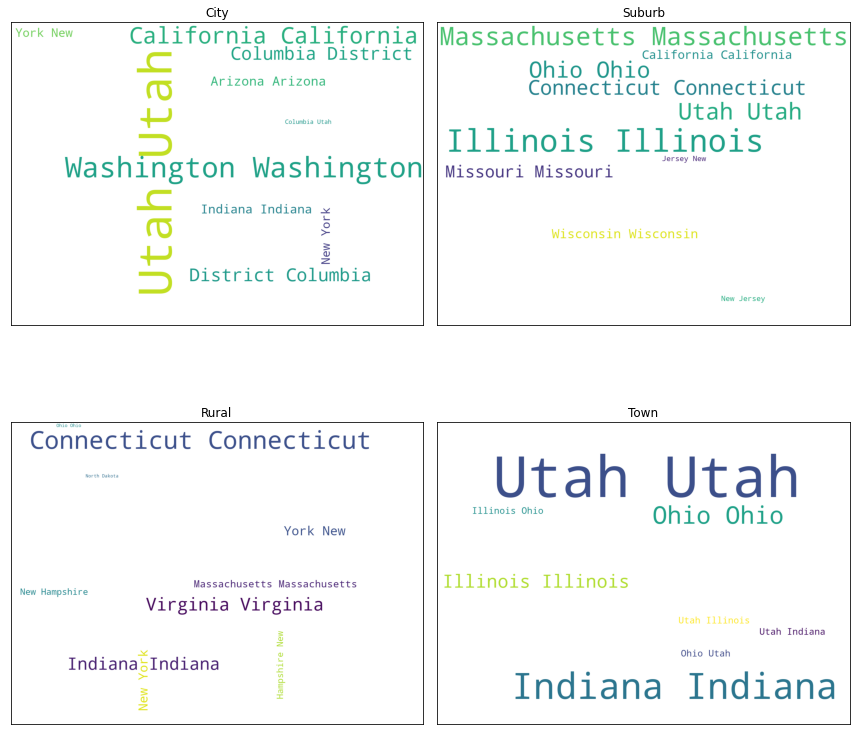

In [ ]:
%%time 

def show_cloud(df):
    local = df.loc[df.locale != "missing", "locale"].unique()
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    ax = axes.ravel()
    for i, l in enumerate(local):
        x = df.loc[df.locale == l, ["state"]]
        if len(x) == 0: continue
        word = WordCloud(width=1500, height=1100, background_color="white", max_words=10).generate(" ".join(x["state"]))
        ax[i].imshow(word)
        ax[i].set_title(l)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.tight_layout()
    
    
df["locale"] = df.locale.fillna("missing")
df["state"] = df.state.fillna("missing")
show_cloud(df)
gc.collect()

***EDA Transition***

---



In [ ]:
def transition_all(df):
    time = df.groupby("time").mean().loc[:, ["pct_access", "engagement_index"]]
    
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    ax = axes.ravel()
    time.drop("engagement_index", axis=1).plot(ax=ax[0])
    ax[0].set_title("pct_access")
    time.drop("pct_access", axis=1).plot(ax=ax[1])
    ax[1].set_title("engagement_index")
    plt.show()
    gc.collect()
    
    
def transition_locale(df, is_access=True):
    local = df.locale.unique()
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    ax = axes.ravel()
    for l in local:
        x = df.loc[df.locale == l, ["time", "pct_access"]]
        y = df.loc[df.locale == l, ["time", "engagement_index"]]
        x.groupby("time").mean().plot(ax=ax[0])
        y.groupby("time").mean().plot(ax=ax[1])
    ax[0].legend(local)
    ax[1].legend(local)
    ax[0].set_title("access")
    ax[1].set_title("engagement")
    plt.show()
    gc.collect()
        
    
def transition_locale_access_trand(df):
    local = df.locale.unique()
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    ax = axes.ravel()
    for i, l in enumerate(local):
        x = df.loc[df.locale == l, ["time", "pct_access"]]
        x["rolling_7"] = x.groupby("time")["pct_access"].rolling(window=90).mean().reset_index(drop=True)
        x.groupby("time").mean().plot(ax=ax[i])
        ax[i].set_title(f"locale {l}")
        del x 
    plt.suptitle("locale classies pct_access trainsitin trends.",fontsize=18)
    plt.tight_layout()
    gc.collect()
    
    
def transition_locale_engage_trand(df):
    local = df.locale.unique()
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    ax = axes.ravel()
    for i, l in enumerate(local):
        x = df.loc[df.locale == l, ["time", "engagement_index"]]
        x["rolling_7"] = x.groupby("time")["engagement_index"].rolling(window=90).mean().reset_index(drop=True)
        x.groupby("time").mean().plot(ax=ax[i])
        ax[i].set_title(f"locale {l}")
        del x
    plt.suptitle("locale classies engagement_index trainsitin trends.", fontsize=18)
    plt.tight_layout()
    gc.collect()

***Engagement and Access with respect to all locale***

---



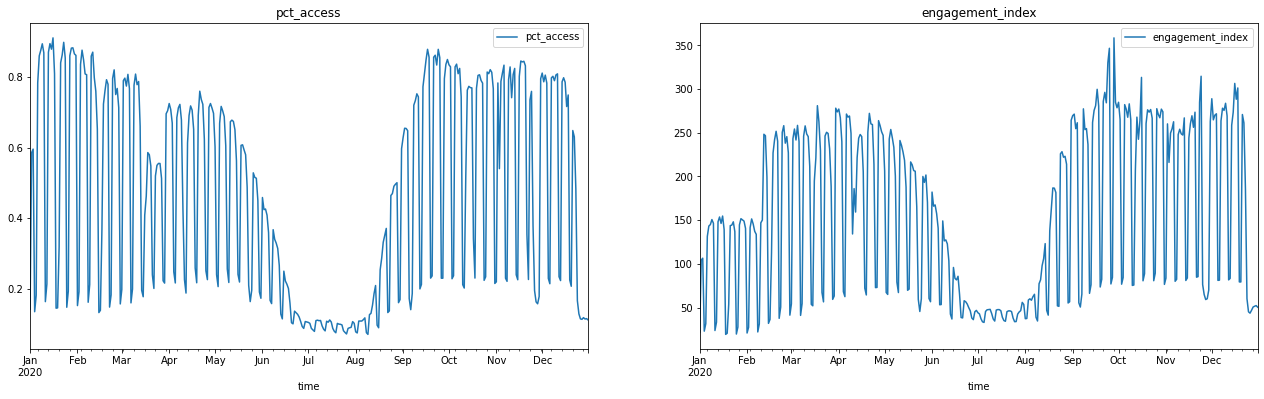

In [ ]:
transition_all(df)

***Transition with respect to locale***

---



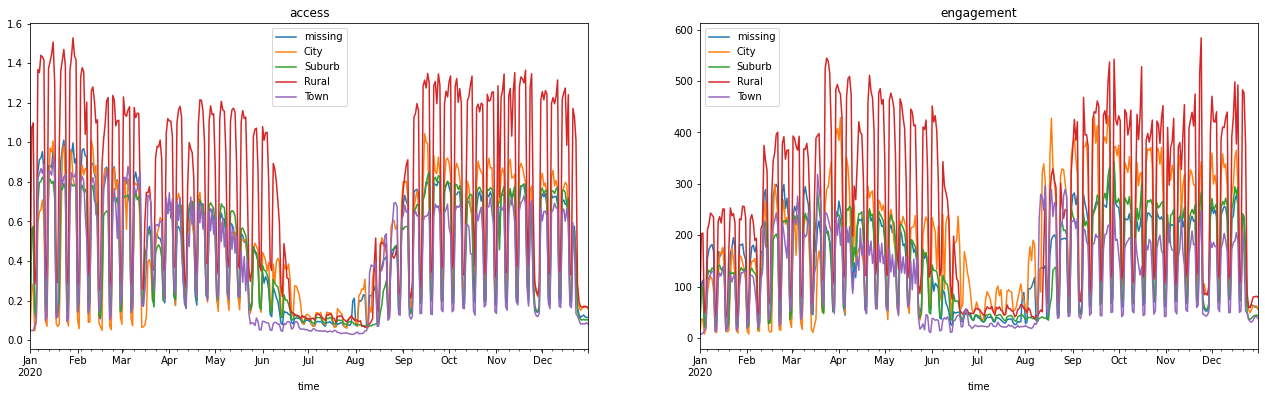

In [ ]:
transition_locale(df)

***Engagement in holidays with reference to the month***

---



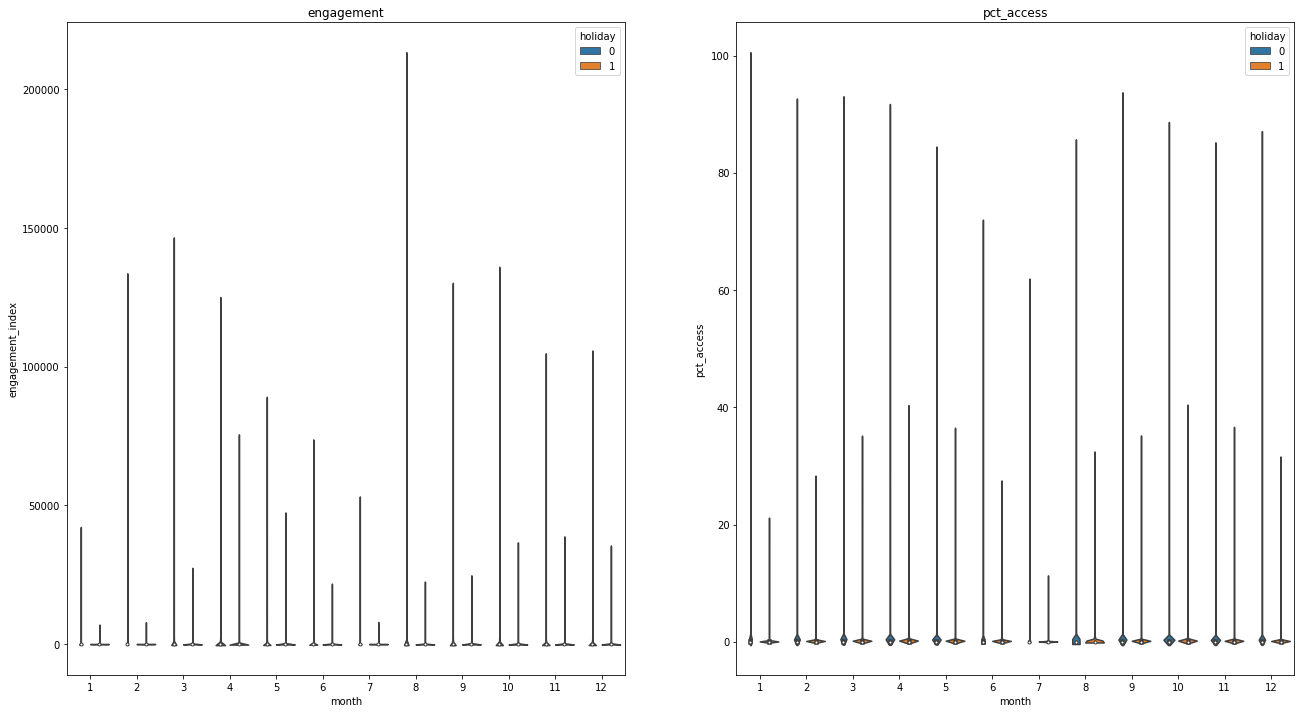

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(22, 12))
ax = axes.ravel()

df["month"] = df.time.dt.month
sns.violinplot(data=df, x="month", y="engagement_index", hue="holiday", ax=ax[0])
ax[0].set_title("engagement")
sns.violinplot(data=df, x="month", y="pct_access", hue="holiday", ax=ax[1])
ax[1].set_title("pct_access")

df.drop("month", axis=1, inplace=True)
gc.collect()
plt.show()

***Transition of Locale vs Engagement and poc_access***

---



IndexError: ignored

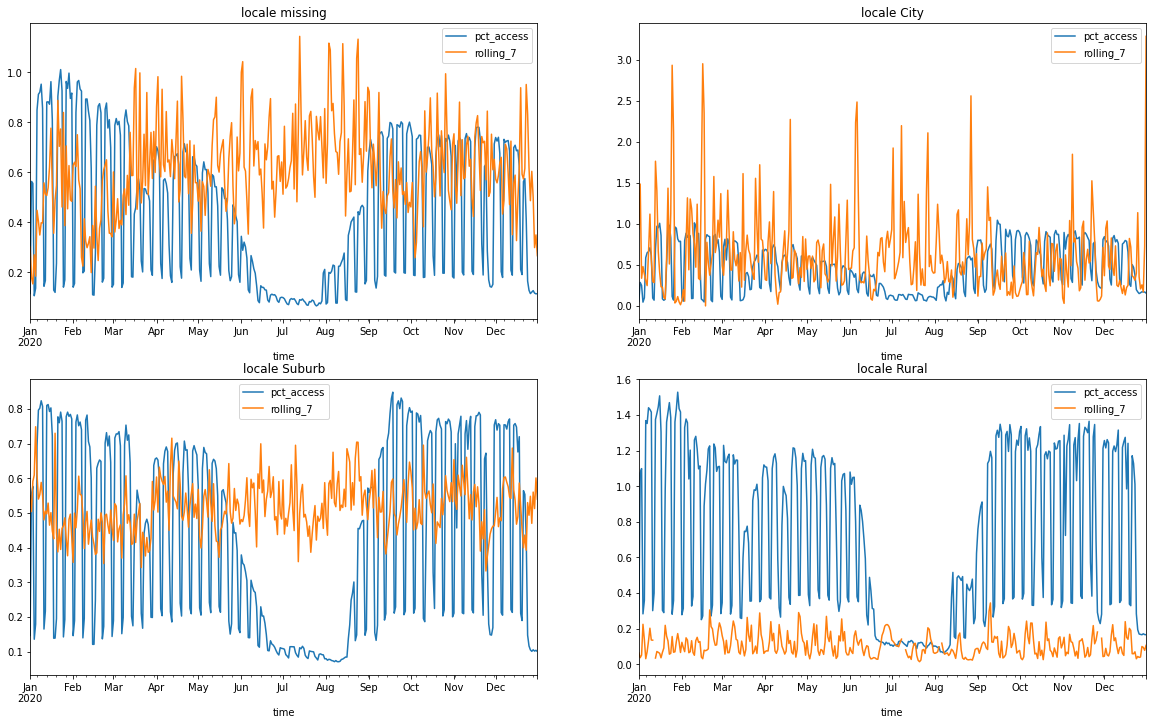

In [ ]:
transition_locale_access_trand(df)

IndexError: ignored

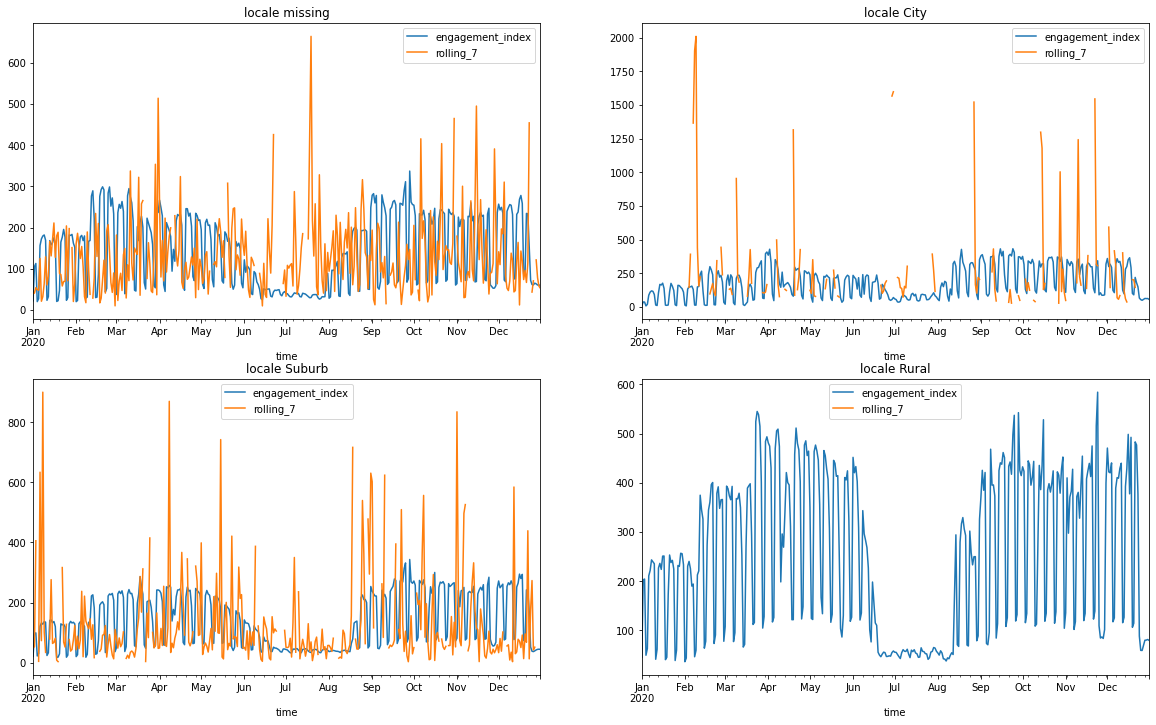

In [ ]:
transition_locale_engage_trand(df)

***Holidays before Covid-19 and after the Pandemic struck***

---



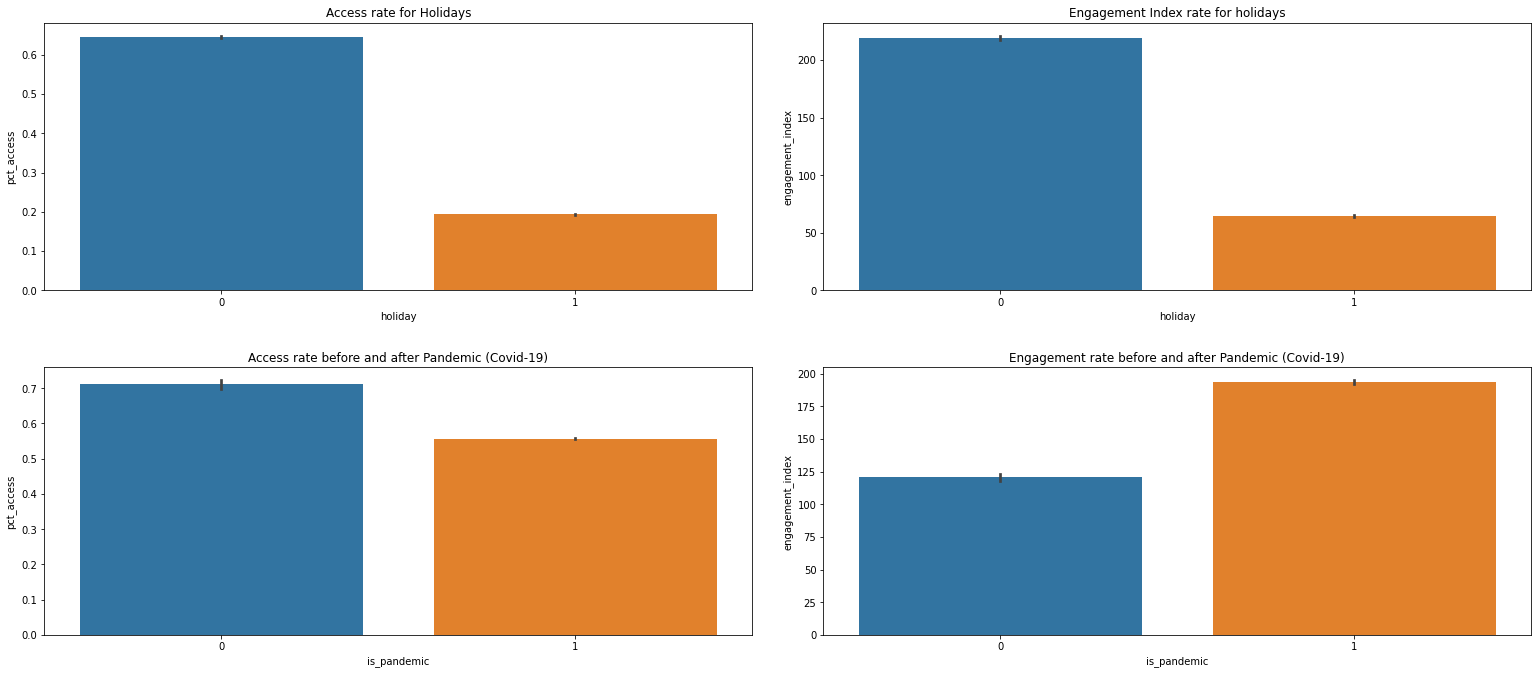

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(22, 10))
ax = axes.ravel()

sns.barplot(data=df, x="holiday", y="pct_access", ax=ax[0])
ax[0].set_title("Access rate for Holidays")
gc.collect()

sns.barplot(data=df, x="holiday", y="engagement_index", ax=ax[1])
ax[1].set_title("Engagement Index rate for holidays")
gc.collect()

sns.barplot(data=df, x="is_pandemic", y="pct_access", ax=ax[2])
ax[2].set_title("Access rate before and after Pandemic (Covid-19)")
gc.collect()

sns.barplot(data=df, x="is_pandemic", y="engagement_index", ax=ax[3])
ax[3].set_title("Engagement rate before and after Pandemic (Covid-19)")
gc.collect()

plt.tight_layout(pad=3.0)

*Weekdays are clearly greater than weekends on both holidays and weekdays. Surprisingly, given to the dispersion before and after the corona, there is less access before the pandemic. Due to the fact that it was originally large in the city category, this can be seen in the time series graph above.*

***Searching for similar states based on Subs*** --

---


*The comparison is done by combining the state count tables and the subs that are based on them. That is, states that belong to comparable categorization groups can be separated. It also looks for aggregates from states that are part of the same category.*

In [ ]:
%%time


state_sub_count_df = pd.crosstab(df.state, df["sub"])
s = MinMaxScaler(feature_range=(0.0, 1.0))
s_df = s.fit_transform(state_sub_count_df)

df_sparse = sp.sparse.csr_matrix(s_df)
df_sparse = cosine_similarity(df_sparse)
df_sparse = pd.DataFrame(df_sparse, columns=state_sub_count_df.index, index=state_sub_count_df.index)
del state_sub_count_df, s_df
gc.collect()
df_sparse.head()

CPU times: user 2.52 s, sys: 24 ms, total: 2.55 s
Wall time: 2.54 s


In [ ]:
usa_states_abbrevia = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District Of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}



def find_similar_state(state_name: str, n: int=10):
    x = df_sparse[[state_name]].sort_values(state_name, ascending=False)[1:n+1]
    x.columns = ["similar"]
    return x 


def show_area(similar_state: pd.DataFrame, state_name: str):
    similar_state["state"] = similar_state.index
    similar_state = similar_state.reset_index(drop=True)
    similar_state["state_abbver"] = similar_state.state.replace(usa_states_abbrevia)
    
    fig = go.Figure()
    layout = dict(
        title_text = f"Search for similar ({state_name}) state top 10k",
        geo_scope='usa',
    )

    fig.add_trace(
        go.Choropleth(
            locations=similar_state.state_abbver,
            zmax=1,
            z = similar_state.similar,
            locationmode = 'USA-states', 
            marker_line_color='white',
            geo='geo',
            colorscale=px.colors.sequential.Teal, 
        )
    )

    fig.update_layout(layout)   
    fig.show()
    
    
def show_count_bar(similar_state: pd.DataFrame):
    state = similar_state.index.to_list()
    
    fig, axes = plt.subplots(1, 2, figsize=(22, 6))
    ax = axes.ravel()
    main = df.loc[df.state.isin(state), ["main"]].value_counts()
    ax[0].pie(x=main.values)
    ax[0].legend(main.index)
    sub = df.loc[df.state.isin(state), ["sub"]].value_counts().to_frame().sort_values("sub", ascending=False)[:5].sort_values("sub", ascending=True)
    sub.plot(kind="barh", ax=ax[1])
        
    ax[0].set_title("Similarity with respect to main rate.")
    ax[1].set_title("Similarity with respect to sub counts.")
    plt.tight_layout(pad=3.0)
    del main, sub 
    gc.collect()
    
    
def show_transition(similar_state: pd.DataFrame, state_name):
#     similar_state = find_similar_state(state_name)
    state = similar_state.index.to_list()[:5]
    
    fig, axes = plt.subplots(2, 3, figsize=(22, 12))
    ax = axes.ravel()
    
    x = df.loc[df.state == state_name, ["time", "engagement_index"]]
    x.groupby("time").mean().plot(ax=ax[0])
    ax[0].set_title("Current State Transition.")
    
    for i, s in enumerate(state):
        x = df.loc[df.state == s, ["time", "engagement_index"]]
        x = x.groupby("time").mean()
        x.plot(ax=ax[i+1])
        ax[i+1].set_title(f"State which is similar is {s}.")
        
    plt.tight_layout(pad=3.0)
    del x 
    gc.collect()
    
    
def similarity_plot_search(state_name: str, n: int=10):
    similar_df = find_similar_state(state_name, n)
    show_area(similar_df, state_name)
    show_count_bar(similar_df)
    show_transition(similar_df, state_name)
    display(similar_df)
    gc.collect()

***Searching for states similar to Massachusetts***

---



,similar,state
state,,
Connecticut,0.989616,Connecticut
missing,0.982799,missing
Ohio,0.981449,Ohio
Illinois,0.980805,Illinois
Wisconsin,0.978715,Wisconsin
New York,0.964538,New York
Minnesota,0.964309,Minnesota
Virginia,0.963604,Virginia
Utah,0.960757,Utah


CPU times: user 8.51 s, sys: 501 ms, total: 9.01 s
Wall time: 8.51 s


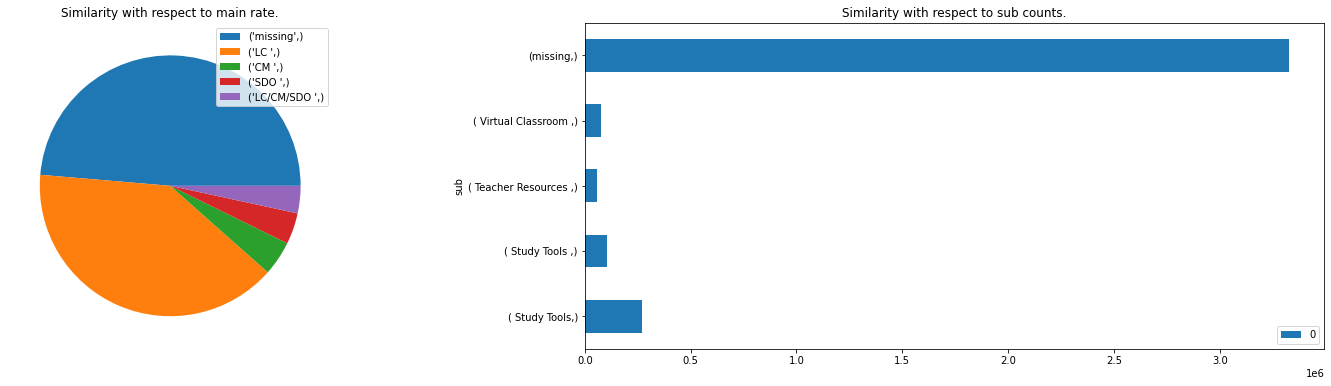

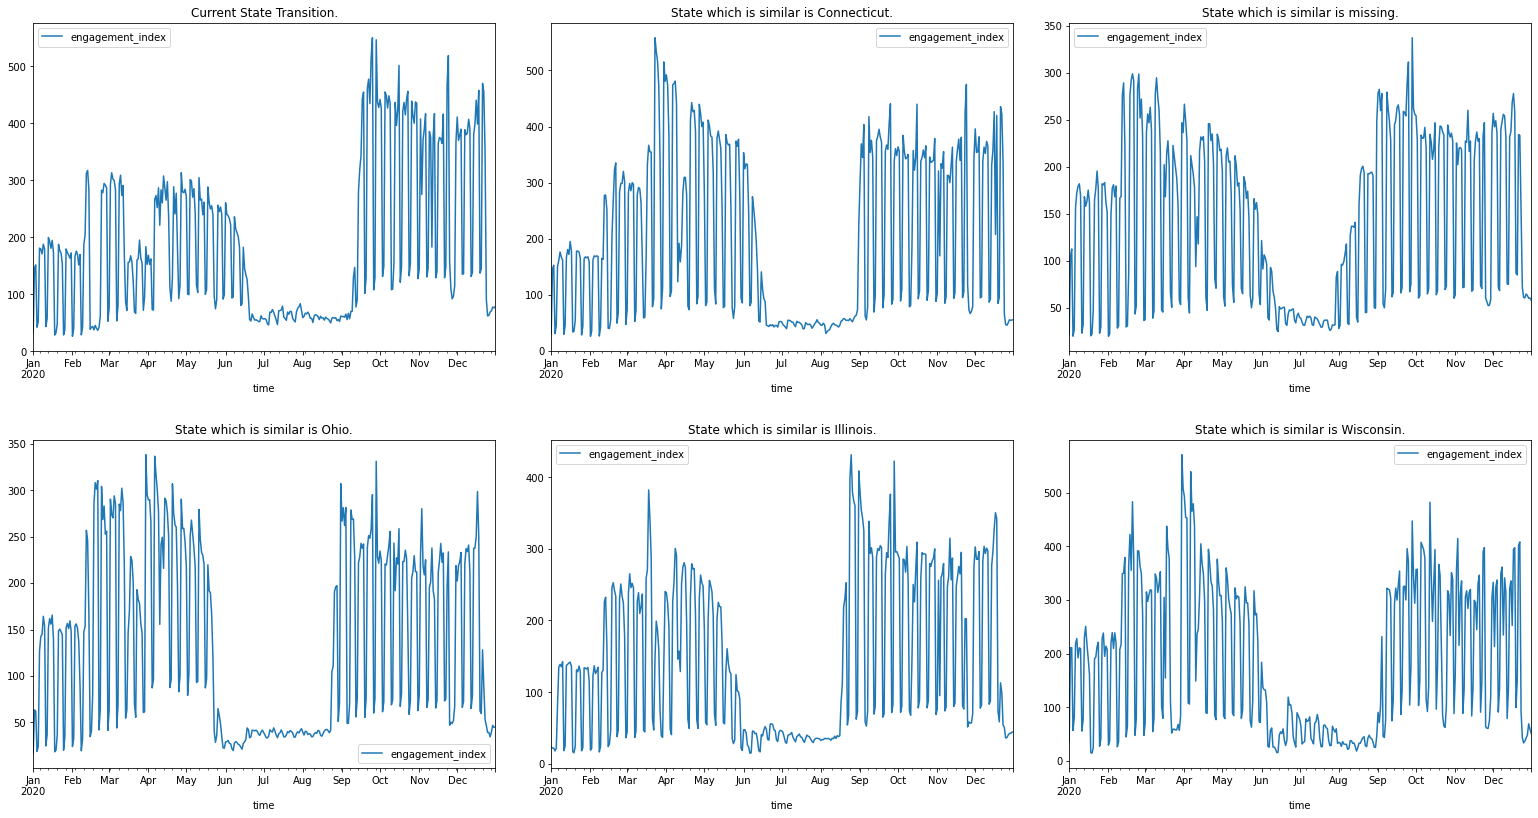

In [ ]:
%%time 

similarity_plot_search("Massachusetts")

***Searching for states similar to Ohio***

---



,similar,state
state,,
Wisconsin,0.986383,Wisconsin
missing,0.983346,missing
Massachusetts,0.981449,Massachusetts
Indiana,0.976216,Indiana
Illinois,0.975640,Illinois
Connecticut,0.972593,Connecticut
Utah,0.966540,Utah
Missouri,0.964434,Missouri
Washington,0.962898,Washington


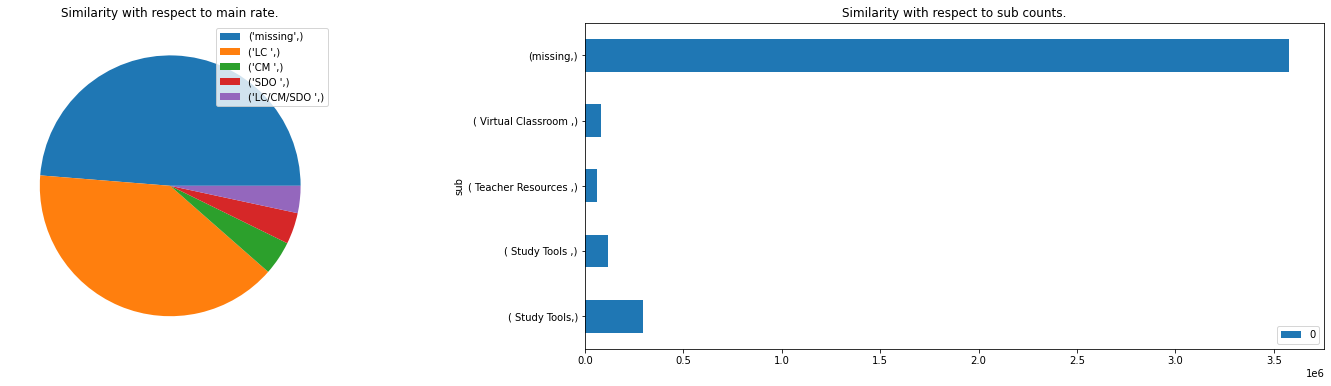

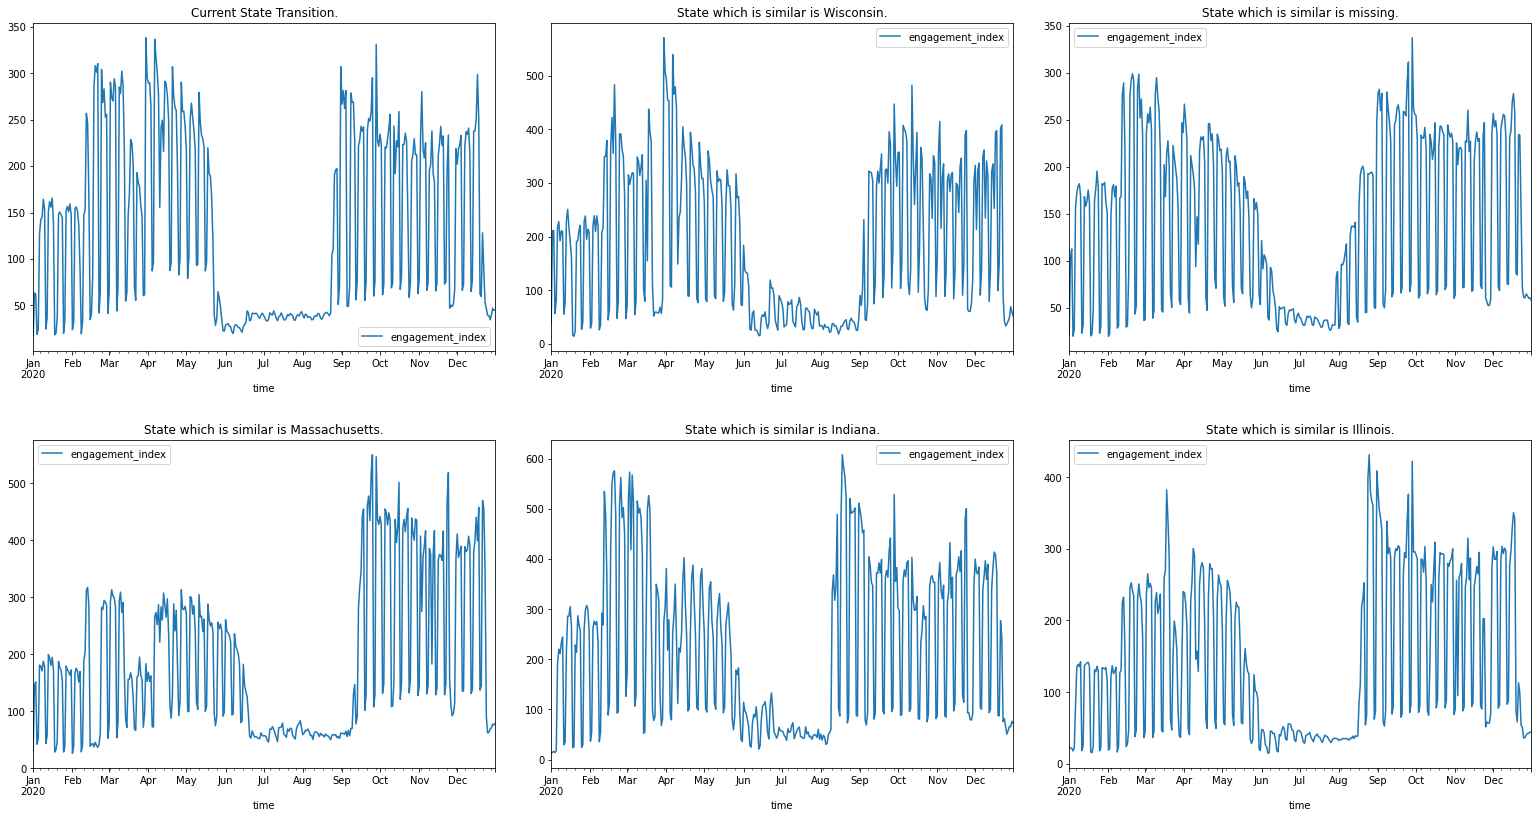

In [ ]:
similarity_plot_search('Ohio')

*The change of group distribution by states with similar subs cannot be compared. Rather, it appears to be location-dependent.*

***Prediction of tomorrow's engagement using the LSTM model***

In [ ]:
%%time 

x = df.groupby("time")["engagement_index", "pct_access"].sum()
x = x.rename(columns={"engagement_index": "engagement_index_lag_1", "pct_access": "pct_access_lag_1"})
x["engagement_index"] = x.engagement_index_lag_1.shift(-1)

for col in ["engagement_index_lag_1", "pct_access_lag_1"]:
    x[col.split("_")[0]+"_lag_2"] = x[col].shift(1).fillna(0)
    x[col.split("_")[0]+"_lag_3"] = x[col].shift(2).fillna(0)
    x[col.split("_")[0]+"_lag_30"] = x[col].shift(30).fillna(0)
    x[col.split("_")[0]+"_rolling7"] = x[col].rolling(window=7).mean().fillna(0).reset_index(drop=True)
    x[col.split("_")[0]+"_rolling30"] = x[col].rolling(window=30).mean().fillna(0).reset_index(drop=True)
x = x.fillna(0)
x.head()

CPU times: user 225 ms, sys: 4.02 ms, total: 229 ms
Wall time: 227 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



In [ ]:
class Dset(Dataset):
    def __init__(self, df):
        n_span = 30 
        train = df.iloc[:(-1)*(n_span+1), :]
        val = df.iloc[(-1)*(n_span+1): -1, :]
        test = df.iloc[(-1)*n_span:, :]
        self.train = []
        self.val = []
        self.test = []
        
        x_train, x_val, x_test = train.drop("engagement_index", axis=1), val.drop("engagement_index", axis=1), test.drop("engagement_index", axis=1)
        y_train, y_val = train[["engagement_index"]], val[["engagement_index"]]
        
        x_train, x_val, x_test = self._scaler(x_train, x_val, x_test)
        
        for i in range(x_train.shape[0]-n_span):
            input_data = {}
            inputs = x_train[i:i+n_span]
            inputs = torch.FloatTensor(inputs)
            target = y_train.iloc[i+n_span]
            target = torch.tensor(target, dtype=torch.float)
            
            input_data["inputs"] = inputs 
            input_data["target"] = target 
            self.train.append(input_data)
            
        for i in range(n_span):
            input_data = {}
            inputs_tr = x_train[(-1)*n_span+i:, :]
            inputs_va = x_val[:i, :]
            inputs = np.concatenate([inputs_tr, inputs_va])
            inputs = torch.FloatTensor(inputs)
            target = y_val.iloc[i]
            target = torch.tensor(target, dtype=torch.float)
            
            input_data["inputs"] = inputs 
            input_data["target"] = target 
            self.val.append(input_data)
            
        input_data = {"inputs": torch.FloatTensor(x_test)}
        self.test.append(input_data)
        
    def _scaler(self, tr, va, te):
        rs = RobustScaler()
        return rs.fit_transform(tr), rs.transform(va), rs.transform(te)
    

params = {
    "hidden_dim": 128, 
    "input_size": 12, 
}


config = {
    "device": "cuda:0" if torch.cuda.is_available() else "cpu", 
    "batch_size": 12, 
    "epoch": 1000, 
    "lr": 0.001
    
}
    
class DigitalModel(nn.Module):
    def __init__(self, input_size=params["input_size"], hidden_dim=params["hidden_dim"]):
        super(DigitalModel, self).__init__()
        self.hidden_dim = hidden_dim 
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim//2, 1)
        )
        
    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :].view(-1, self.hidden_dim)
        x = self.fc(x)
        return x 
    

In [ ]:
a = Dset(x)
print(f"input shape: {a.train[0]['inputs'].size()}")
print(f"target shape: {a.val[0]['target'].size()}")

net = DigitalModel()
a = torch.rand(2, 30, 12)
y = net(a)
print(f"output shape: {y.size()}")

input shape: torch.Size([30, 12])
target shape: torch.Size([1])
output shape: torch.Size([2, 1])


In [ ]:
def train_fn(dl, model, criterion, optimizer, is_train=True):
    total_loss = []
    if is_train:
        model.train()
    else:
        model.eval()
        
    for d in tqdm(dl):
        x = d["inputs"].to(config["device"])
        t = d["target"].to(config["device"])
        
        if is_train:
            y = model(x)
            loss = criterion(y.view(-1), t.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        else:
            with torch.no_grad():
                y = model(x)
                loss = criterion(y.view(-1), t.view(-1))
                
        total_loss.append(loss.item())
        del x, t
    total_loss = np.array(total_loss)
    return np.mean(total_loss)

def val_fn(dl, model):
    with torch.no_grad():
        pred = []
        for d in tqdm(dl):
            x = d["inputs"].to(config["device"])

            y = model(x)
            y = y.squeeze().detach().cpu().numpy()
            for yy in y:
                pred.append(yy)
            del x
    return pred

def test_fn(dl, model):
    with torch.no_grad():
        pred = []
        for d in tqdm(dl):
            x = d["inputs"].to(config["device"])

            y = model(x)
            y = y.squeeze().detach().cpu().numpy()
            pred.append(y.squeeze())
    return pred


def mae(pred, corr):
    return np.mean(np.abs(pred - corr))

In [ ]:
def fit(train_dl, val_dl, debug=True):
    model = DigitalModel()
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    
    best_model, best_loss = None, np.inf 
    
    for e in range(1 if debug else config["epoch"]):
        ts = time.time()
        loss_tr = train_fn(train_dl, model, criterion, optimizer)
        val_tr = train_fn(val_dl, model, criterion, None, False)        
        
        if best_loss > val_tr:
            best_model = model 
            best_loss = val_tr
        now = time.time()
        print(f"epoch: {e+1} | tr loss: {loss_tr:.3f} | va loss: {val_tr:.3f} | dilation {now-ts}s | ")
    print(f"best val loss: {best_loss:.3f}")
    gc.collect()
    return best_model 

def predict(dl, model, is_test=False):
    if is_test:
        p = test_fn(dl, model)
    else:
        p = val_fn(dl, model)
    return p 


In [ ]:
def main(df, debug):
    data = Dset(df)
    train, val, test = data.train, data.val, data.test 
    
    train_dl = DataLoader(train, 
                         batch_size=config["batch_size"],
                         shuffle=False, drop_last=False)
    val_dl = DataLoader(val, 
                         batch_size=config["batch_size"], 
                         shuffle=False, drop_last=False)
    test_dl = DataLoader(test, 
                         batch_size=1,
                         shuffle=False, drop_last=False)
    model = fit(train_dl, val_dl, debug)
    predv = predict(val_dl, model, False)
    predt = predict(test_dl, model, True)
    
    
    print("===================================================================================")
    print(f"validation mae: {mae(predv, df.iloc[-31: -1, :]['engagement_index'].values.ravel())}")
    print("===================================================================================")

    print(f"Expected to be {predt[0]} tomorrow ")
    print("===================================================================================")


if __name__ == "__main__":
    main(x, False)

100%|██████████| 3/3 [00:00<00:00, 272.70it/s]


epoch: 1 | tr loss: 3597522.976 | va loss: 3846192.365 | dilation 0.3246941566467285s | 


100%|██████████| 3/3 [00:00<00:00, 263.02it/s]


epoch: 2 | tr loss: 3597511.722 | va loss: 3846175.500 | dilation 0.2846951484680176s | 


100%|██████████| 3/3 [00:00<00:00, 251.44it/s]


epoch: 3 | tr loss: 3597489.085 | va loss: 3846146.427 | dilation 0.3000643253326416s | 


100%|██████████| 3/3 [00:00<00:00, 258.86it/s]


epoch: 4 | tr loss: 3597454.739 | va loss: 3846105.073 | dilation 0.3111872673034668s | 


100%|██████████| 3/3 [00:00<00:00, 216.18it/s]


epoch: 5 | tr loss: 3597406.819 | va loss: 3846051.167 | dilation 0.3342092037200928s | 


100%|██████████| 3/3 [00:00<00:00, 227.84it/s]


epoch: 6 | tr loss: 3597345.587 | va loss: 3845983.667 | dilation 0.8747992515563965s | 


100%|██████████| 3/3 [00:00<00:00, 278.75it/s]


epoch: 7 | tr loss: 3597270.832 | va loss: 3845903.500 | dilation 1.2481780052185059s | 


100%|██████████| 3/3 [00:00<00:00, 223.18it/s]


epoch: 8 | tr loss: 3597186.656 | va loss: 3845810.198 | dilation 1.5889332294464111s | 


100%|██████████| 3/3 [00:00<00:00, 264.39it/s]


epoch: 9 | tr loss: 3597090.780 | va loss: 3845704.635 | dilation 1.7533462047576904s | 


100%|██████████| 3/3 [00:00<00:00, 279.13it/s]


epoch: 10 | tr loss: 3596975.460 | va loss: 3845586.490 | dilation 1.8107948303222656s | 


100%|██████████| 3/3 [00:00<00:00, 257.54it/s]


epoch: 11 | tr loss: 3596851.448 | va loss: 3845455.531 | dilation 1.7269608974456787s | 


100%|██████████| 3/3 [00:00<00:00, 229.40it/s]


epoch: 12 | tr loss: 3596706.663 | va loss: 3845310.698 | dilation 1.6312241554260254s | 


100%|██████████| 3/3 [00:00<00:00, 265.63it/s]


epoch: 13 | tr loss: 3596562.632 | va loss: 3845153.583 | dilation 1.5294897556304932s | 


100%|██████████| 3/3 [00:00<00:00, 227.90it/s]


epoch: 14 | tr loss: 3596403.696 | va loss: 3844985.083 | dilation 1.3731803894042969s | 


100%|██████████| 3/3 [00:00<00:00, 311.74it/s]


epoch: 15 | tr loss: 3596235.374 | va loss: 3844804.615 | dilation 1.1582489013671875s | 


100%|██████████| 3/3 [00:00<00:00, 220.35it/s]


epoch: 16 | tr loss: 3596041.507 | va loss: 3844612.198 | dilation 1.0728635787963867s | 


100%|██████████| 3/3 [00:00<00:00, 268.49it/s]


epoch: 17 | tr loss: 3595843.585 | va loss: 3844406.927 | dilation 1.040426254272461s | 


100%|██████████| 3/3 [00:00<00:00, 270.72it/s]


epoch: 18 | tr loss: 3595645.927 | va loss: 3844190.917 | dilation 0.9892139434814453s | 


100%|██████████| 3/3 [00:00<00:00, 290.56it/s]


epoch: 19 | tr loss: 3595396.356 | va loss: 3843960.635 | dilation 0.915830135345459s | 


100%|██████████| 3/3 [00:00<00:00, 271.69it/s]


epoch: 20 | tr loss: 3595165.556 | va loss: 3843718.698 | dilation 0.8208742141723633s | 


100%|██████████| 3/3 [00:00<00:00, 298.10it/s]


epoch: 21 | tr loss: 3594907.476 | va loss: 3843464.583 | dilation 0.7309916019439697s | 


100%|██████████| 3/3 [00:00<00:00, 325.23it/s]


epoch: 22 | tr loss: 3594657.992 | va loss: 3843199.948 | dilation 0.6767933368682861s | 


100%|██████████| 3/3 [00:00<00:00, 300.82it/s]


epoch: 23 | tr loss: 3594395.334 | va loss: 3842924.167 | dilation 0.6602191925048828s | 


100%|██████████| 3/3 [00:00<00:00, 242.27it/s]


epoch: 24 | tr loss: 3594134.208 | va loss: 3842637.573 | dilation 0.688788890838623s | 


100%|██████████| 3/3 [00:00<00:00, 278.59it/s]


epoch: 25 | tr loss: 3593820.288 | va loss: 3842340.167 | dilation 0.691138505935669s | 


100%|██████████| 3/3 [00:00<00:00, 282.84it/s]


epoch: 26 | tr loss: 3593485.880 | va loss: 3842028.667 | dilation 0.6897118091583252s | 


100%|██████████| 3/3 [00:00<00:00, 236.33it/s]


epoch: 27 | tr loss: 3593190.874 | va loss: 3841707.667 | dilation 0.6737282276153564s | 


100%|██████████| 3/3 [00:00<00:00, 234.51it/s]


epoch: 28 | tr loss: 3592858.739 | va loss: 3841376.167 | dilation 0.6590375900268555s | 


100%|██████████| 3/3 [00:00<00:00, 230.12it/s]


epoch: 29 | tr loss: 3592534.442 | va loss: 3841033.333 | dilation 0.6222341060638428s | 


100%|██████████| 3/3 [00:00<00:00, 303.93it/s]


epoch: 30 | tr loss: 3592191.350 | va loss: 3840681.333 | dilation 0.5956931114196777s | 


100%|██████████| 3/3 [00:00<00:00, 257.24it/s]


epoch: 31 | tr loss: 3591820.108 | va loss: 3840316.656 | dilation 0.5802605152130127s | 


100%|██████████| 3/3 [00:00<00:00, 277.98it/s]


epoch: 32 | tr loss: 3591432.226 | va loss: 3839941.635 | dilation 0.5606436729431152s | 


100%|██████████| 3/3 [00:00<00:00, 246.26it/s]


epoch: 33 | tr loss: 3591125.064 | va loss: 3839559.656 | dilation 0.5488598346710205s | 


100%|██████████| 3/3 [00:00<00:00, 272.07it/s]


epoch: 34 | tr loss: 3590744.291 | va loss: 3839167.698 | dilation 0.5503389835357666s | 


100%|██████████| 3/3 [00:00<00:00, 247.13it/s]


epoch: 35 | tr loss: 3590300.975 | va loss: 3838764.135 | dilation 0.5341475009918213s | 


100%|██████████| 3/3 [00:00<00:00, 274.70it/s]


epoch: 36 | tr loss: 3589901.763 | va loss: 3838349.552 | dilation 0.5257132053375244s | 


100%|██████████| 3/3 [00:00<00:00, 258.15it/s]


epoch: 37 | tr loss: 3589525.445 | va loss: 3837925.583 | dilation 0.5447330474853516s | 


100%|██████████| 3/3 [00:00<00:00, 257.54it/s]


epoch: 38 | tr loss: 3589112.382 | va loss: 3837494.000 | dilation 0.5475091934204102s | 


100%|██████████| 3/3 [00:00<00:00, 240.62it/s]


epoch: 39 | tr loss: 3588481.183 | va loss: 3837046.260 | dilation 0.5598459243774414s | 


100%|██████████| 3/3 [00:00<00:00, 288.49it/s]


epoch: 40 | tr loss: 3588136.276 | va loss: 3836590.031 | dilation 0.5761215686798096s | 


100%|██████████| 3/3 [00:00<00:00, 304.37it/s]


epoch: 41 | tr loss: 3587614.566 | va loss: 3836122.573 | dilation 0.5701963901519775s | 


100%|██████████| 3/3 [00:00<00:00, 265.50it/s]


epoch: 42 | tr loss: 3587219.302 | va loss: 3835647.948 | dilation 0.5797367095947266s | 


100%|██████████| 3/3 [00:00<00:00, 271.22it/s]


epoch: 43 | tr loss: 3586734.974 | va loss: 3835164.323 | dilation 0.5751395225524902s | 


100%|██████████| 3/3 [00:00<00:00, 258.81it/s]


epoch: 44 | tr loss: 3586339.356 | va loss: 3834672.302 | dilation 0.5605525970458984s | 


100%|██████████| 3/3 [00:00<00:00, 249.59it/s]


epoch: 45 | tr loss: 3585905.244 | va loss: 3834176.167 | dilation 0.5497710704803467s | 


100%|██████████| 3/3 [00:00<00:00, 231.78it/s]


epoch: 46 | tr loss: 3585148.393 | va loss: 3833663.615 | dilation 0.5411221981048584s | 


100%|██████████| 3/3 [00:00<00:00, 266.22it/s]


epoch: 47 | tr loss: 3584816.251 | va loss: 3833142.969 | dilation 0.5247788429260254s | 


100%|██████████| 3/3 [00:00<00:00, 252.28it/s]


epoch: 48 | tr loss: 3584296.906 | va loss: 3832615.698 | dilation 0.5310530662536621s | 


100%|██████████| 3/3 [00:00<00:00, 247.04it/s]


epoch: 49 | tr loss: 3583632.470 | va loss: 3832075.615 | dilation 0.5234506130218506s | 


100%|██████████| 3/3 [00:00<00:00, 301.74it/s]


epoch: 50 | tr loss: 3583091.754 | va loss: 3831527.594 | dilation 0.5164139270782471s | 


100%|██████████| 3/3 [00:00<00:00, 226.26it/s]


epoch: 51 | tr loss: 3582668.508 | va loss: 3830971.615 | dilation 0.5043587684631348s | 


100%|██████████| 3/3 [00:00<00:00, 249.75it/s]


epoch: 52 | tr loss: 3582124.169 | va loss: 3830407.510 | dilation 0.5100760459899902s | 


100%|██████████| 3/3 [00:00<00:00, 268.67it/s]


epoch: 53 | tr loss: 3581536.736 | va loss: 3829834.740 | dilation 0.48809266090393066s | 


100%|██████████| 3/3 [00:00<00:00, 225.12it/s]


epoch: 54 | tr loss: 3580887.018 | va loss: 3829250.781 | dilation 0.47890305519104004s | 


100%|██████████| 3/3 [00:00<00:00, 258.43it/s]


epoch: 55 | tr loss: 3580297.340 | va loss: 3828659.531 | dilation 0.4672696590423584s | 


100%|██████████| 3/3 [00:00<00:00, 239.79it/s]


epoch: 56 | tr loss: 3579902.470 | va loss: 3828060.667 | dilation 0.46549344062805176s | 


100%|██████████| 3/3 [00:00<00:00, 227.45it/s]


epoch: 57 | tr loss: 3579141.480 | va loss: 3827455.750 | dilation 0.4554769992828369s | 


100%|██████████| 3/3 [00:00<00:00, 229.97it/s]


epoch: 58 | tr loss: 3578650.151 | va loss: 3826842.365 | dilation 0.4602632522583008s | 


100%|██████████| 3/3 [00:00<00:00, 289.86it/s]


epoch: 59 | tr loss: 3578016.475 | va loss: 3826218.167 | dilation 0.45417094230651855s | 


100%|██████████| 3/3 [00:00<00:00, 271.31it/s]


epoch: 60 | tr loss: 3577249.434 | va loss: 3825583.750 | dilation 0.4658548831939697s | 


100%|██████████| 3/3 [00:00<00:00, 225.92it/s]


epoch: 61 | tr loss: 3576624.677 | va loss: 3824939.740 | dilation 0.4386789798736572s | 


100%|██████████| 3/3 [00:00<00:00, 274.30it/s]


epoch: 62 | tr loss: 3575984.118 | va loss: 3824288.260 | dilation 0.43564438819885254s | 


100%|██████████| 3/3 [00:00<00:00, 262.71it/s]


epoch: 63 | tr loss: 3575501.925 | va loss: 3823632.240 | dilation 0.4307975769042969s | 


100%|██████████| 3/3 [00:00<00:00, 261.48it/s]


epoch: 64 | tr loss: 3574637.799 | va loss: 3822964.198 | dilation 0.4200572967529297s | 


100%|██████████| 3/3 [00:00<00:00, 224.63it/s]


epoch: 65 | tr loss: 3573887.833 | va loss: 3822286.240 | dilation 0.4270493984222412s | 


100%|██████████| 3/3 [00:00<00:00, 232.57it/s]


epoch: 66 | tr loss: 3573268.599 | va loss: 3821600.865 | dilation 0.4188535213470459s | 


100%|██████████| 3/3 [00:00<00:00, 213.87it/s]


epoch: 67 | tr loss: 3572600.159 | va loss: 3820907.583 | dilation 0.4343855381011963s | 


100%|██████████| 3/3 [00:00<00:00, 230.91it/s]


epoch: 68 | tr loss: 3571954.971 | va loss: 3820206.302 | dilation 0.42114782333374023s | 


100%|██████████| 3/3 [00:00<00:00, 232.90it/s]


epoch: 69 | tr loss: 3570941.702 | va loss: 3819494.698 | dilation 0.4155435562133789s | 


100%|██████████| 3/3 [00:00<00:00, 284.57it/s]


epoch: 70 | tr loss: 3570336.740 | va loss: 3818773.031 | dilation 0.42086148262023926s | 


100%|██████████| 3/3 [00:00<00:00, 268.61it/s]


epoch: 71 | tr loss: 3569761.429 | va loss: 3818047.156 | dilation 0.4134993553161621s | 


100%|██████████| 3/3 [00:00<00:00, 238.57it/s]


epoch: 72 | tr loss: 3568765.852 | va loss: 3817311.667 | dilation 0.43337202072143555s | 


100%|██████████| 3/3 [00:00<00:00, 290.90it/s]


epoch: 73 | tr loss: 3568229.475 | va loss: 3816569.615 | dilation 0.4308786392211914s | 


100%|██████████| 3/3 [00:00<00:00, 230.63it/s]


epoch: 74 | tr loss: 3567411.779 | va loss: 3815821.500 | dilation 0.42558956146240234s | 


100%|██████████| 3/3 [00:00<00:00, 219.46it/s]


epoch: 75 | tr loss: 3566650.052 | va loss: 3815061.302 | dilation 0.41985559463500977s | 


100%|██████████| 3/3 [00:00<00:00, 216.42it/s]


epoch: 76 | tr loss: 3565945.962 | va loss: 3814299.719 | dilation 0.4155597686767578s | 


100%|██████████| 3/3 [00:00<00:00, 262.31it/s]


epoch: 77 | tr loss: 3565338.304 | va loss: 3813528.573 | dilation 0.3879678249359131s | 


100%|██████████| 3/3 [00:00<00:00, 247.25it/s]


epoch: 78 | tr loss: 3564630.103 | va loss: 3812754.156 | dilation 0.3702225685119629s | 


100%|██████████| 3/3 [00:00<00:00, 221.11it/s]


epoch: 79 | tr loss: 3563350.444 | va loss: 3811963.698 | dilation 0.37363696098327637s | 


100%|██████████| 3/3 [00:00<00:00, 246.89it/s]


epoch: 80 | tr loss: 3562966.189 | va loss: 3811170.760 | dilation 0.32528090476989746s | 


100%|██████████| 3/3 [00:00<00:00, 281.58it/s]


epoch: 81 | tr loss: 3561743.739 | va loss: 3810365.281 | dilation 0.31474995613098145s | 


100%|██████████| 3/3 [00:00<00:00, 252.72it/s]


epoch: 82 | tr loss: 3561183.838 | va loss: 3809552.667 | dilation 0.2979593276977539s | 


100%|██████████| 3/3 [00:00<00:00, 290.24it/s]


epoch: 83 | tr loss: 3559966.501 | va loss: 3808733.583 | dilation 0.29926228523254395s | 


100%|██████████| 3/3 [00:00<00:00, 269.98it/s]


epoch: 84 | tr loss: 3559624.964 | va loss: 3807907.656 | dilation 0.2857649326324463s | 


100%|██████████| 3/3 [00:00<00:00, 277.59it/s]


epoch: 85 | tr loss: 3558438.147 | va loss: 3807071.573 | dilation 0.2939794063568115s | 


100%|██████████| 3/3 [00:00<00:00, 276.74it/s]


epoch: 86 | tr loss: 3557864.596 | va loss: 3806234.177 | dilation 0.3147430419921875s | 


100%|██████████| 3/3 [00:00<00:00, 281.01it/s]


epoch: 87 | tr loss: 3557350.379 | va loss: 3805393.302 | dilation 0.30080676078796387s | 


100%|██████████| 3/3 [00:00<00:00, 256.86it/s]


epoch: 88 | tr loss: 3556227.355 | va loss: 3804543.667 | dilation 0.29975318908691406s | 


100%|██████████| 3/3 [00:00<00:00, 287.19it/s]


epoch: 89 | tr loss: 3555487.635 | va loss: 3803689.323 | dilation 0.3016030788421631s | 


100%|██████████| 3/3 [00:00<00:00, 224.49it/s]


epoch: 90 | tr loss: 3554655.457 | va loss: 3802826.448 | dilation 0.29083752632141113s | 


100%|██████████| 3/3 [00:00<00:00, 216.11it/s]


epoch: 91 | tr loss: 3553751.388 | va loss: 3801954.781 | dilation 0.2876424789428711s | 


100%|██████████| 3/3 [00:00<00:00, 254.24it/s]


epoch: 92 | tr loss: 3552994.446 | va loss: 3801078.948 | dilation 0.29053449630737305s | 


100%|██████████| 3/3 [00:00<00:00, 185.21it/s]


epoch: 93 | tr loss: 3552030.921 | va loss: 3800195.594 | dilation 0.2931070327758789s | 


100%|██████████| 3/3 [00:00<00:00, 270.81it/s]


epoch: 94 | tr loss: 3551070.026 | va loss: 3799304.135 | dilation 0.300112247467041s | 


100%|██████████| 3/3 [00:00<00:00, 244.52it/s]


epoch: 95 | tr loss: 3550474.781 | va loss: 3798407.750 | dilation 0.3087010383605957s | 


100%|██████████| 3/3 [00:00<00:00, 268.02it/s]


epoch: 96 | tr loss: 3549314.953 | va loss: 3797504.667 | dilation 0.2958221435546875s | 


100%|██████████| 3/3 [00:00<00:00, 229.31it/s]


epoch: 97 | tr loss: 3548439.083 | va loss: 3796592.240 | dilation 0.2959787845611572s | 


100%|██████████| 3/3 [00:00<00:00, 277.53it/s]


epoch: 98 | tr loss: 3547106.310 | va loss: 3795668.677 | dilation 0.30185770988464355s | 


100%|██████████| 3/3 [00:00<00:00, 243.18it/s]


epoch: 99 | tr loss: 3546899.240 | va loss: 3794742.000 | dilation 0.31839585304260254s | 


100%|██████████| 3/3 [00:00<00:00, 212.04it/s]


epoch: 100 | tr loss: 3545531.385 | va loss: 3793812.635 | dilation 0.3201780319213867s | 


100%|██████████| 3/3 [00:00<00:00, 248.13it/s]


epoch: 101 | tr loss: 3544843.446 | va loss: 3792877.250 | dilation 0.3337547779083252s | 


100%|██████████| 3/3 [00:00<00:00, 237.58it/s]


epoch: 102 | tr loss: 3543903.667 | va loss: 3791930.365 | dilation 0.3355753421783447s | 


100%|██████████| 3/3 [00:00<00:00, 285.76it/s]


epoch: 103 | tr loss: 3542804.554 | va loss: 3790977.583 | dilation 0.3258805274963379s | 


100%|██████████| 3/3 [00:00<00:00, 224.04it/s]


epoch: 104 | tr loss: 3541785.059 | va loss: 3790021.594 | dilation 0.3157055377960205s | 


100%|██████████| 3/3 [00:00<00:00, 194.60it/s]


epoch: 105 | tr loss: 3541183.477 | va loss: 3789056.292 | dilation 0.3148791790008545s | 


100%|██████████| 3/3 [00:00<00:00, 270.63it/s]


epoch: 106 | tr loss: 3540033.761 | va loss: 3788087.542 | dilation 0.31894898414611816s | 


100%|██████████| 3/3 [00:00<00:00, 278.00it/s]


epoch: 107 | tr loss: 3538436.993 | va loss: 3787100.573 | dilation 0.32160067558288574s | 


100%|██████████| 3/3 [00:00<00:00, 225.18it/s]


epoch: 108 | tr loss: 3537505.430 | va loss: 3786105.083 | dilation 0.3160076141357422s | 


100%|██████████| 3/3 [00:00<00:00, 236.40it/s]


epoch: 109 | tr loss: 3536905.821 | va loss: 3785108.302 | dilation 0.3092994689941406s | 


100%|██████████| 3/3 [00:00<00:00, 229.42it/s]


epoch: 110 | tr loss: 3535425.065 | va loss: 3784107.531 | dilation 0.31328797340393066s | 


100%|██████████| 3/3 [00:00<00:00, 273.33it/s]


epoch: 111 | tr loss: 3534427.361 | va loss: 3783093.260 | dilation 0.30708885192871094s | 


100%|██████████| 3/3 [00:00<00:00, 202.47it/s]


epoch: 112 | tr loss: 3534129.626 | va loss: 3782076.583 | dilation 0.30620241165161133s | 


100%|██████████| 3/3 [00:00<00:00, 225.90it/s]


epoch: 113 | tr loss: 3532917.023 | va loss: 3781061.990 | dilation 0.3080766201019287s | 


100%|██████████| 3/3 [00:00<00:00, 224.29it/s]


epoch: 114 | tr loss: 3531987.083 | va loss: 3780040.167 | dilation 0.31441569328308105s | 


100%|██████████| 3/3 [00:00<00:00, 245.21it/s]


epoch: 115 | tr loss: 3531321.868 | va loss: 3779013.073 | dilation 0.3334834575653076s | 


100%|██████████| 3/3 [00:00<00:00, 247.37it/s]


epoch: 116 | tr loss: 3530025.506 | va loss: 3777980.667 | dilation 0.32672739028930664s | 


100%|██████████| 3/3 [00:00<00:00, 251.25it/s]


epoch: 117 | tr loss: 3528551.517 | va loss: 3776936.615 | dilation 0.31443166732788086s | 


100%|██████████| 3/3 [00:00<00:00, 209.43it/s]


epoch: 118 | tr loss: 3528093.921 | va loss: 3775884.667 | dilation 0.3268468379974365s | 


100%|██████████| 3/3 [00:00<00:00, 214.72it/s]


epoch: 119 | tr loss: 3526528.460 | va loss: 3774828.167 | dilation 0.31957197189331055s | 


100%|██████████| 3/3 [00:00<00:00, 224.88it/s]


epoch: 120 | tr loss: 3525630.350 | va loss: 3773764.615 | dilation 0.3356454372406006s | 


100%|██████████| 3/3 [00:00<00:00, 229.38it/s]


epoch: 121 | tr loss: 3524963.255 | va loss: 3772698.177 | dilation 0.32475781440734863s | 


100%|██████████| 3/3 [00:00<00:00, 216.94it/s]


epoch: 122 | tr loss: 3523711.852 | va loss: 3771628.625 | dilation 0.3205883502960205s | 


100%|██████████| 3/3 [00:00<00:00, 252.80it/s]


epoch: 123 | tr loss: 3522139.161 | va loss: 3770544.667 | dilation 0.31528544425964355s | 


100%|██████████| 3/3 [00:00<00:00, 230.79it/s]


epoch: 124 | tr loss: 3521774.930 | va loss: 3769459.583 | dilation 0.3135995864868164s | 


100%|██████████| 3/3 [00:00<00:00, 270.06it/s]


epoch: 125 | tr loss: 3520778.636 | va loss: 3768372.677 | dilation 0.307720422744751s | 


100%|██████████| 3/3 [00:00<00:00, 285.74it/s]


epoch: 126 | tr loss: 3518970.215 | va loss: 3767270.927 | dilation 0.3210330009460449s | 


100%|██████████| 3/3 [00:00<00:00, 211.36it/s]


epoch: 127 | tr loss: 3517552.014 | va loss: 3766161.292 | dilation 0.3260781764984131s | 


100%|██████████| 3/3 [00:00<00:00, 235.56it/s]


epoch: 128 | tr loss: 3516607.976 | va loss: 3765042.469 | dilation 0.31512999534606934s | 


100%|██████████| 3/3 [00:00<00:00, 211.82it/s]


epoch: 129 | tr loss: 3515972.216 | va loss: 3763921.083 | dilation 0.32080936431884766s | 


100%|██████████| 3/3 [00:00<00:00, 254.85it/s]


epoch: 130 | tr loss: 3515353.275 | va loss: 3762803.708 | dilation 0.31597042083740234s | 


100%|██████████| 3/3 [00:00<00:00, 241.70it/s]


epoch: 131 | tr loss: 3513400.190 | va loss: 3761672.615 | dilation 0.3175489902496338s | 


100%|██████████| 3/3 [00:00<00:00, 201.75it/s]


epoch: 132 | tr loss: 3511692.388 | va loss: 3760529.302 | dilation 0.32284092903137207s | 


100%|██████████| 3/3 [00:00<00:00, 233.78it/s]


epoch: 133 | tr loss: 3511554.375 | va loss: 3759387.625 | dilation 0.31450772285461426s | 


100%|██████████| 3/3 [00:00<00:00, 300.96it/s]


epoch: 134 | tr loss: 3510155.974 | va loss: 3758235.552 | dilation 0.309889554977417s | 


100%|██████████| 3/3 [00:00<00:00, 228.81it/s]


epoch: 135 | tr loss: 3509023.508 | va loss: 3757080.583 | dilation 0.31208181381225586s | 


100%|██████████| 3/3 [00:00<00:00, 196.96it/s]


epoch: 136 | tr loss: 3507724.681 | va loss: 3755918.927 | dilation 0.3003876209259033s | 


100%|██████████| 3/3 [00:00<00:00, 277.92it/s]


epoch: 137 | tr loss: 3506416.774 | va loss: 3754750.260 | dilation 0.30936193466186523s | 


100%|██████████| 3/3 [00:00<00:00, 252.25it/s]


epoch: 138 | tr loss: 3505231.431 | va loss: 3753567.594 | dilation 0.3002495765686035s | 


100%|██████████| 3/3 [00:00<00:00, 261.76it/s]


epoch: 139 | tr loss: 3504253.317 | va loss: 3752390.917 | dilation 0.31484365463256836s | 


100%|██████████| 3/3 [00:00<00:00, 261.34it/s]


epoch: 140 | tr loss: 3504158.276 | va loss: 3751215.510 | dilation 0.3140895366668701s | 


100%|██████████| 3/3 [00:00<00:00, 234.64it/s]


epoch: 141 | tr loss: 3503008.831 | va loss: 3750034.177 | dilation 0.3012409210205078s | 


100%|██████████| 3/3 [00:00<00:00, 261.07it/s]


epoch: 142 | tr loss: 3501849.165 | va loss: 3748850.385 | dilation 0.30848073959350586s | 


100%|██████████| 3/3 [00:00<00:00, 252.76it/s]


epoch: 143 | tr loss: 3499426.852 | va loss: 3747648.302 | dilation 0.30463576316833496s | 


100%|██████████| 3/3 [00:00<00:00, 277.59it/s]


epoch: 144 | tr loss: 3498945.157 | va loss: 3746446.010 | dilation 0.29962944984436035s | 


100%|██████████| 3/3 [00:00<00:00, 237.52it/s]


epoch: 145 | tr loss: 3497183.510 | va loss: 3745223.552 | dilation 0.30605578422546387s | 


100%|██████████| 3/3 [00:00<00:00, 289.03it/s]


epoch: 146 | tr loss: 3495759.576 | va loss: 3744003.000 | dilation 0.3009355068206787s | 


100%|██████████| 3/3 [00:00<00:00, 239.39it/s]


epoch: 147 | tr loss: 3494403.234 | va loss: 3742771.760 | dilation 0.3106513023376465s | 


100%|██████████| 3/3 [00:00<00:00, 251.73it/s]


epoch: 148 | tr loss: 3493293.364 | va loss: 3741533.260 | dilation 0.3127119541168213s | 


100%|██████████| 3/3 [00:00<00:00, 282.33it/s]


epoch: 149 | tr loss: 3491591.004 | va loss: 3740291.635 | dilation 0.3131542205810547s | 


100%|██████████| 3/3 [00:00<00:00, 305.83it/s]


epoch: 150 | tr loss: 3491035.623 | va loss: 3739043.542 | dilation 0.307830810546875s | 


100%|██████████| 3/3 [00:00<00:00, 235.82it/s]


epoch: 151 | tr loss: 3490147.624 | va loss: 3737795.510 | dilation 0.29637718200683594s | 


100%|██████████| 3/3 [00:00<00:00, 211.89it/s]


epoch: 152 | tr loss: 3489040.212 | va loss: 3736541.552 | dilation 0.3230404853820801s | 


100%|██████████| 3/3 [00:00<00:00, 237.97it/s]


epoch: 153 | tr loss: 3487635.240 | va loss: 3735288.615 | dilation 0.3110334873199463s | 


100%|██████████| 3/3 [00:00<00:00, 225.73it/s]


epoch: 154 | tr loss: 3485960.489 | va loss: 3734023.958 | dilation 0.29784512519836426s | 


100%|██████████| 3/3 [00:00<00:00, 198.64it/s]


epoch: 155 | tr loss: 3484105.782 | va loss: 3732743.708 | dilation 0.31131815910339355s | 


100%|██████████| 3/3 [00:00<00:00, 228.13it/s]


epoch: 156 | tr loss: 3483041.991 | va loss: 3731458.802 | dilation 0.3160722255706787s | 


100%|██████████| 3/3 [00:00<00:00, 230.59it/s]


epoch: 157 | tr loss: 3480833.764 | va loss: 3730162.177 | dilation 0.3023407459259033s | 


100%|██████████| 3/3 [00:00<00:00, 205.12it/s]


epoch: 158 | tr loss: 3480563.492 | va loss: 3728865.031 | dilation 0.30560731887817383s | 


100%|██████████| 3/3 [00:00<00:00, 211.34it/s]


epoch: 159 | tr loss: 3479752.062 | va loss: 3727569.094 | dilation 0.3157470226287842s | 


100%|██████████| 3/3 [00:00<00:00, 199.97it/s]


epoch: 160 | tr loss: 3477752.029 | va loss: 3726261.302 | dilation 0.3128201961517334s | 


100%|██████████| 3/3 [00:00<00:00, 225.31it/s]


epoch: 161 | tr loss: 3476907.558 | va loss: 3724953.302 | dilation 0.30646705627441406s | 


100%|██████████| 3/3 [00:00<00:00, 236.95it/s]


epoch: 162 | tr loss: 3475104.216 | va loss: 3723630.031 | dilation 0.3197023868560791s | 


100%|██████████| 3/3 [00:00<00:00, 198.33it/s]


epoch: 163 | tr loss: 3473420.643 | va loss: 3722304.198 | dilation 0.3168201446533203s | 


100%|██████████| 3/3 [00:00<00:00, 180.95it/s]


epoch: 164 | tr loss: 3472909.843 | va loss: 3720980.333 | dilation 0.30782008171081543s | 


100%|██████████| 3/3 [00:00<00:00, 238.91it/s]


epoch: 165 | tr loss: 3472340.048 | va loss: 3719650.167 | dilation 0.310899019241333s | 


100%|██████████| 3/3 [00:00<00:00, 229.01it/s]


epoch: 166 | tr loss: 3470876.898 | va loss: 3718322.750 | dilation 0.3177065849304199s | 


100%|██████████| 3/3 [00:00<00:00, 219.63it/s]


epoch: 167 | tr loss: 3469680.624 | va loss: 3716985.615 | dilation 0.3217954635620117s | 


100%|██████████| 3/3 [00:00<00:00, 248.63it/s]


epoch: 168 | tr loss: 3468665.985 | va loss: 3715647.667 | dilation 0.3139970302581787s | 


100%|██████████| 3/3 [00:00<00:00, 241.50it/s]


epoch: 169 | tr loss: 3467285.234 | va loss: 3714300.667 | dilation 0.31563901901245117s | 


100%|██████████| 3/3 [00:00<00:00, 301.26it/s]


epoch: 170 | tr loss: 3465081.395 | va loss: 3712947.740 | dilation 0.3161888122558594s | 


100%|██████████| 3/3 [00:00<00:00, 239.71it/s]


epoch: 171 | tr loss: 3464490.232 | va loss: 3711588.302 | dilation 0.30831217765808105s | 


100%|██████████| 3/3 [00:00<00:00, 241.86it/s]


epoch: 172 | tr loss: 3461124.849 | va loss: 3710218.250 | dilation 0.3078932762145996s | 


100%|██████████| 3/3 [00:00<00:00, 231.10it/s]


epoch: 173 | tr loss: 3459687.797 | va loss: 3708826.750 | dilation 0.30776190757751465s | 


100%|██████████| 3/3 [00:00<00:00, 275.89it/s]


epoch: 174 | tr loss: 3459814.431 | va loss: 3707443.719 | dilation 0.30416178703308105s | 


100%|██████████| 3/3 [00:00<00:00, 184.31it/s]


epoch: 175 | tr loss: 3459025.819 | va loss: 3706059.750 | dilation 0.30879831314086914s | 


100%|██████████| 3/3 [00:00<00:00, 258.94it/s]


epoch: 176 | tr loss: 3456500.911 | va loss: 3704668.667 | dilation 0.30952000617980957s | 


100%|██████████| 3/3 [00:00<00:00, 268.26it/s]


epoch: 177 | tr loss: 3454597.567 | va loss: 3703264.281 | dilation 0.2936849594116211s | 


100%|██████████| 3/3 [00:00<00:00, 233.57it/s]


epoch: 178 | tr loss: 3455507.051 | va loss: 3701866.281 | dilation 0.3058905601501465s | 


100%|██████████| 3/3 [00:00<00:00, 238.01it/s]


epoch: 179 | tr loss: 3453334.364 | va loss: 3700471.760 | dilation 0.28786230087280273s | 


100%|██████████| 3/3 [00:00<00:00, 205.30it/s]


epoch: 180 | tr loss: 3451585.653 | va loss: 3699060.583 | dilation 0.29756665229797363s | 


100%|██████████| 3/3 [00:00<00:00, 212.22it/s]


epoch: 181 | tr loss: 3448228.129 | va loss: 3697635.698 | dilation 0.30620455741882324s | 


100%|██████████| 3/3 [00:00<00:00, 249.13it/s]


epoch: 182 | tr loss: 3448806.322 | va loss: 3696208.573 | dilation 0.3105599880218506s | 


100%|██████████| 3/3 [00:00<00:00, 270.37it/s]


epoch: 183 | tr loss: 3446655.075 | va loss: 3694773.052 | dilation 0.30246782302856445s | 


100%|██████████| 3/3 [00:00<00:00, 243.61it/s]


epoch: 184 | tr loss: 3444896.179 | va loss: 3693334.010 | dilation 0.3098137378692627s | 


100%|██████████| 3/3 [00:00<00:00, 240.15it/s]


epoch: 185 | tr loss: 3443901.760 | va loss: 3691899.573 | dilation 0.3005959987640381s | 


100%|██████████| 3/3 [00:00<00:00, 299.94it/s]


epoch: 186 | tr loss: 3444163.796 | va loss: 3690453.552 | dilation 0.2944014072418213s | 


100%|██████████| 3/3 [00:00<00:00, 224.25it/s]


epoch: 187 | tr loss: 3439491.941 | va loss: 3689000.365 | dilation 0.30774879455566406s | 


100%|██████████| 3/3 [00:00<00:00, 226.30it/s]


epoch: 188 | tr loss: 3440453.771 | va loss: 3687540.156 | dilation 0.2971763610839844s | 


100%|██████████| 3/3 [00:00<00:00, 219.34it/s]


epoch: 189 | tr loss: 3437604.489 | va loss: 3686064.844 | dilation 0.29733943939208984s | 


100%|██████████| 3/3 [00:00<00:00, 218.88it/s]


epoch: 190 | tr loss: 3438176.728 | va loss: 3684617.062 | dilation 0.2969682216644287s | 


100%|██████████| 3/3 [00:00<00:00, 233.14it/s]


epoch: 191 | tr loss: 3435557.108 | va loss: 3683146.531 | dilation 0.3002512454986572s | 


100%|██████████| 3/3 [00:00<00:00, 244.57it/s]


epoch: 192 | tr loss: 3433248.275 | va loss: 3681664.198 | dilation 0.3135857582092285s | 


100%|██████████| 3/3 [00:00<00:00, 255.76it/s]


epoch: 193 | tr loss: 3430943.592 | va loss: 3680160.677 | dilation 0.30852389335632324s | 


100%|██████████| 3/3 [00:00<00:00, 258.62it/s]


epoch: 194 | tr loss: 3432611.191 | va loss: 3678686.094 | dilation 0.29686927795410156s | 


100%|██████████| 3/3 [00:00<00:00, 238.75it/s]


epoch: 195 | tr loss: 3430649.142 | va loss: 3677202.750 | dilation 0.2984762191772461s | 


100%|██████████| 3/3 [00:00<00:00, 259.28it/s]


epoch: 196 | tr loss: 3427798.801 | va loss: 3675705.615 | dilation 0.30109739303588867s | 


100%|██████████| 3/3 [00:00<00:00, 265.47it/s]


epoch: 197 | tr loss: 3424661.895 | va loss: 3674200.365 | dilation 0.2943456172943115s | 


100%|██████████| 3/3 [00:00<00:00, 244.46it/s]


epoch: 198 | tr loss: 3425875.263 | va loss: 3672707.948 | dilation 0.30123400688171387s | 


100%|██████████| 3/3 [00:00<00:00, 215.65it/s]


epoch: 199 | tr loss: 3423504.475 | va loss: 3671196.177 | dilation 0.31248903274536133s | 


100%|██████████| 3/3 [00:00<00:00, 179.67it/s]


epoch: 200 | tr loss: 3420412.668 | va loss: 3669660.656 | dilation 0.30759215354919434s | 


100%|██████████| 3/3 [00:00<00:00, 247.75it/s]


epoch: 201 | tr loss: 3421935.700 | va loss: 3668140.177 | dilation 0.3053734302520752s | 


100%|██████████| 3/3 [00:00<00:00, 189.48it/s]


epoch: 202 | tr loss: 3418170.043 | va loss: 3666621.542 | dilation 0.3095405101776123s | 


100%|██████████| 3/3 [00:00<00:00, 279.90it/s]


epoch: 203 | tr loss: 3416797.720 | va loss: 3665081.365 | dilation 0.30850839614868164s | 


100%|██████████| 3/3 [00:00<00:00, 168.40it/s]


epoch: 204 | tr loss: 3416238.599 | va loss: 3663540.667 | dilation 0.30358195304870605s | 


100%|██████████| 3/3 [00:00<00:00, 205.29it/s]


epoch: 205 | tr loss: 3414095.195 | va loss: 3662015.531 | dilation 0.3175787925720215s | 


100%|██████████| 3/3 [00:00<00:00, 255.61it/s]


epoch: 206 | tr loss: 3412163.778 | va loss: 3660460.677 | dilation 0.3200185298919678s | 


100%|██████████| 3/3 [00:00<00:00, 217.34it/s]


epoch: 207 | tr loss: 3411803.606 | va loss: 3658911.677 | dilation 0.30937671661376953s | 


100%|██████████| 3/3 [00:00<00:00, 228.71it/s]


epoch: 208 | tr loss: 3409228.933 | va loss: 3657354.198 | dilation 0.31256651878356934s | 


100%|██████████| 3/3 [00:00<00:00, 270.99it/s]


epoch: 209 | tr loss: 3407427.943 | va loss: 3655776.865 | dilation 0.31261444091796875s | 


100%|██████████| 3/3 [00:00<00:00, 223.51it/s]


epoch: 210 | tr loss: 3405960.461 | va loss: 3654197.542 | dilation 0.3133237361907959s | 


100%|██████████| 3/3 [00:00<00:00, 217.94it/s]


epoch: 211 | tr loss: 3402211.288 | va loss: 3652604.250 | dilation 0.31857824325561523s | 


100%|██████████| 3/3 [00:00<00:00, 212.12it/s]


epoch: 212 | tr loss: 3402709.625 | va loss: 3651005.531 | dilation 0.318082332611084s | 


100%|██████████| 3/3 [00:00<00:00, 253.55it/s]


epoch: 213 | tr loss: 3400470.996 | va loss: 3649417.625 | dilation 0.312394380569458s | 


100%|██████████| 3/3 [00:00<00:00, 161.96it/s]


epoch: 214 | tr loss: 3399259.514 | va loss: 3647818.969 | dilation 0.31442999839782715s | 


100%|██████████| 3/3 [00:00<00:00, 218.86it/s]


epoch: 215 | tr loss: 3401422.383 | va loss: 3646233.375 | dilation 0.33224987983703613s | 


100%|██████████| 3/3 [00:00<00:00, 232.81it/s]


epoch: 216 | tr loss: 3397847.987 | va loss: 3644652.865 | dilation 0.31957364082336426s | 


100%|██████████| 3/3 [00:00<00:00, 256.32it/s]


epoch: 217 | tr loss: 3397208.126 | va loss: 3643066.281 | dilation 0.30831217765808105s | 


100%|██████████| 3/3 [00:00<00:00, 248.69it/s]


epoch: 218 | tr loss: 3393400.877 | va loss: 3641465.042 | dilation 0.321075439453125s | 


100%|██████████| 3/3 [00:00<00:00, 199.73it/s]


epoch: 219 | tr loss: 3392896.358 | va loss: 3639860.677 | dilation 0.3112220764160156s | 


100%|██████████| 3/3 [00:00<00:00, 207.82it/s]


epoch: 220 | tr loss: 3388690.535 | va loss: 3638240.135 | dilation 0.30536365509033203s | 


100%|██████████| 3/3 [00:00<00:00, 221.63it/s]


epoch: 221 | tr loss: 3389703.418 | va loss: 3636634.260 | dilation 0.3261125087738037s | 


100%|██████████| 3/3 [00:00<00:00, 219.96it/s]


epoch: 222 | tr loss: 3388773.523 | va loss: 3635011.333 | dilation 0.31223320960998535s | 


100%|██████████| 3/3 [00:00<00:00, 231.49it/s]


epoch: 223 | tr loss: 3387337.623 | va loss: 3633413.583 | dilation 0.3236675262451172s | 


100%|██████████| 3/3 [00:00<00:00, 252.57it/s]


epoch: 224 | tr loss: 3385193.781 | va loss: 3631823.552 | dilation 0.3262503147125244s | 


100%|██████████| 3/3 [00:00<00:00, 234.07it/s]


epoch: 225 | tr loss: 3382573.807 | va loss: 3630218.260 | dilation 0.31042051315307617s | 


100%|██████████| 3/3 [00:00<00:00, 247.18it/s]


epoch: 226 | tr loss: 3383342.285 | va loss: 3628597.062 | dilation 0.32622408866882324s | 


100%|██████████| 3/3 [00:00<00:00, 248.55it/s]


epoch: 227 | tr loss: 3380670.490 | va loss: 3626965.281 | dilation 0.33193135261535645s | 


100%|██████████| 3/3 [00:00<00:00, 208.54it/s]


epoch: 228 | tr loss: 3378448.555 | va loss: 3625321.031 | dilation 0.31126904487609863s | 


100%|██████████| 3/3 [00:00<00:00, 278.54it/s]


epoch: 229 | tr loss: 3374814.757 | va loss: 3623667.521 | dilation 0.3174920082092285s | 


100%|██████████| 3/3 [00:00<00:00, 277.06it/s]


epoch: 230 | tr loss: 3374690.794 | va loss: 3622017.615 | dilation 0.307445764541626s | 


100%|██████████| 3/3 [00:00<00:00, 232.81it/s]


epoch: 231 | tr loss: 3370459.760 | va loss: 3620376.344 | dilation 0.3136861324310303s | 


100%|██████████| 3/3 [00:00<00:00, 240.02it/s]


epoch: 232 | tr loss: 3371766.925 | va loss: 3618741.073 | dilation 0.3111581802368164s | 


100%|██████████| 3/3 [00:00<00:00, 241.49it/s]


epoch: 233 | tr loss: 3372042.962 | va loss: 3617104.198 | dilation 0.3097238540649414s | 


100%|██████████| 3/3 [00:00<00:00, 229.13it/s]


epoch: 234 | tr loss: 3369967.839 | va loss: 3615477.365 | dilation 0.3186006546020508s | 


100%|██████████| 3/3 [00:00<00:00, 278.66it/s]


epoch: 235 | tr loss: 3369233.377 | va loss: 3613846.656 | dilation 0.3059229850769043s | 


100%|██████████| 3/3 [00:00<00:00, 225.58it/s]


epoch: 236 | tr loss: 3367117.806 | va loss: 3612200.344 | dilation 0.3089292049407959s | 


100%|██████████| 3/3 [00:00<00:00, 254.64it/s]


epoch: 237 | tr loss: 3364913.341 | va loss: 3610565.292 | dilation 0.31887364387512207s | 


100%|██████████| 3/3 [00:00<00:00, 207.16it/s]


epoch: 238 | tr loss: 3361301.889 | va loss: 3608933.344 | dilation 0.3141140937805176s | 


100%|██████████| 3/3 [00:00<00:00, 206.21it/s]


epoch: 239 | tr loss: 3361986.157 | va loss: 3607282.781 | dilation 0.31006646156311035s | 


100%|██████████| 3/3 [00:00<00:00, 172.34it/s]


epoch: 240 | tr loss: 3360285.856 | va loss: 3605618.531 | dilation 0.3174614906311035s | 


100%|██████████| 3/3 [00:00<00:00, 237.42it/s]


epoch: 241 | tr loss: 3357065.097 | va loss: 3603946.208 | dilation 0.31488513946533203s | 


100%|██████████| 3/3 [00:00<00:00, 203.20it/s]


epoch: 242 | tr loss: 3356581.051 | va loss: 3602256.557 | dilation 0.30762386322021484s | 


100%|██████████| 3/3 [00:00<00:00, 277.19it/s]


epoch: 243 | tr loss: 3355094.704 | va loss: 3600583.771 | dilation 0.30496644973754883s | 


100%|██████████| 3/3 [00:00<00:00, 258.25it/s]


epoch: 244 | tr loss: 3351500.147 | va loss: 3598931.641 | dilation 0.3037853240966797s | 


100%|██████████| 3/3 [00:00<00:00, 264.24it/s]


epoch: 245 | tr loss: 3353141.437 | va loss: 3597256.370 | dilation 0.3067021369934082s | 


100%|██████████| 3/3 [00:00<00:00, 218.02it/s]


epoch: 246 | tr loss: 3349710.335 | va loss: 3595567.604 | dilation 0.30811238288879395s | 


100%|██████████| 3/3 [00:00<00:00, 231.11it/s]


epoch: 247 | tr loss: 3346307.937 | va loss: 3593841.062 | dilation 0.3295609951019287s | 


100%|██████████| 3/3 [00:00<00:00, 235.61it/s]


epoch: 248 | tr loss: 3348429.531 | va loss: 3592157.328 | dilation 0.3158104419708252s | 


100%|██████████| 3/3 [00:00<00:00, 196.91it/s]


epoch: 249 | tr loss: 3344610.260 | va loss: 3590473.391 | dilation 0.31154894828796387s | 


100%|██████████| 3/3 [00:00<00:00, 224.44it/s]


epoch: 250 | tr loss: 3343696.623 | va loss: 3588778.286 | dilation 0.31722283363342285s | 


100%|██████████| 3/3 [00:00<00:00, 238.81it/s]


epoch: 251 | tr loss: 3341761.733 | va loss: 3587084.224 | dilation 0.30677270889282227s | 


100%|██████████| 3/3 [00:00<00:00, 230.46it/s]


epoch: 252 | tr loss: 3340393.102 | va loss: 3585424.703 | dilation 0.29861927032470703s | 


100%|██████████| 3/3 [00:00<00:00, 183.20it/s]


epoch: 253 | tr loss: 3337377.407 | va loss: 3583729.312 | dilation 0.3201320171356201s | 


100%|██████████| 3/3 [00:00<00:00, 214.46it/s]


epoch: 254 | tr loss: 3338676.896 | va loss: 3582030.703 | dilation 0.3058433532714844s | 


100%|██████████| 3/3 [00:00<00:00, 212.29it/s]


epoch: 255 | tr loss: 3334981.501 | va loss: 3580357.062 | dilation 0.30442237854003906s | 


100%|██████████| 3/3 [00:00<00:00, 210.88it/s]


epoch: 256 | tr loss: 3336315.851 | va loss: 3578681.562 | dilation 0.3265831470489502s | 


100%|██████████| 3/3 [00:00<00:00, 208.74it/s]


epoch: 257 | tr loss: 3335944.286 | va loss: 3576979.500 | dilation 0.3129754066467285s | 


100%|██████████| 3/3 [00:00<00:00, 210.52it/s]


epoch: 258 | tr loss: 3332187.324 | va loss: 3575286.042 | dilation 0.3155326843261719s | 


100%|██████████| 3/3 [00:00<00:00, 204.68it/s]


epoch: 259 | tr loss: 3330659.887 | va loss: 3573594.792 | dilation 0.31270861625671387s | 


100%|██████████| 3/3 [00:00<00:00, 233.72it/s]


epoch: 260 | tr loss: 3329240.047 | va loss: 3571906.500 | dilation 0.31726503372192383s | 


100%|██████████| 3/3 [00:00<00:00, 226.18it/s]


epoch: 261 | tr loss: 3327125.986 | va loss: 3570220.870 | dilation 0.29909491539001465s | 


100%|██████████| 3/3 [00:00<00:00, 240.74it/s]


epoch: 262 | tr loss: 3322538.721 | va loss: 3568493.286 | dilation 0.31368303298950195s | 


100%|██████████| 3/3 [00:00<00:00, 228.97it/s]


epoch: 263 | tr loss: 3324530.139 | va loss: 3566787.792 | dilation 0.3126232624053955s | 


100%|██████████| 3/3 [00:00<00:00, 205.35it/s]


epoch: 264 | tr loss: 3323851.872 | va loss: 3565090.786 | dilation 0.3081958293914795s | 


100%|██████████| 3/3 [00:00<00:00, 247.47it/s]


epoch: 265 | tr loss: 3322517.626 | va loss: 3563394.536 | dilation 0.3140561580657959s | 


100%|██████████| 3/3 [00:00<00:00, 233.25it/s]


epoch: 266 | tr loss: 3319226.617 | va loss: 3561693.312 | dilation 0.31362247467041016s | 


100%|██████████| 3/3 [00:00<00:00, 228.35it/s]


epoch: 267 | tr loss: 3319579.288 | va loss: 3559965.062 | dilation 0.31165552139282227s | 


100%|██████████| 3/3 [00:00<00:00, 221.52it/s]


epoch: 268 | tr loss: 3315879.984 | va loss: 3558247.771 | dilation 0.30447888374328613s | 


100%|██████████| 3/3 [00:00<00:00, 214.31it/s]


epoch: 269 | tr loss: 3313200.327 | va loss: 3556502.932 | dilation 0.3082008361816406s | 


100%|██████████| 3/3 [00:00<00:00, 246.02it/s]


epoch: 270 | tr loss: 3315431.455 | va loss: 3554772.870 | dilation 0.32358860969543457s | 


100%|██████████| 3/3 [00:00<00:00, 287.54it/s]


epoch: 271 | tr loss: 3313127.890 | va loss: 3553037.057 | dilation 0.3127150535583496s | 


100%|██████████| 3/3 [00:00<00:00, 190.64it/s]


epoch: 272 | tr loss: 3313109.927 | va loss: 3551295.745 | dilation 0.31256556510925293s | 


100%|██████████| 3/3 [00:00<00:00, 247.46it/s]


epoch: 273 | tr loss: 3310094.170 | va loss: 3549521.062 | dilation 0.3226165771484375s | 


100%|██████████| 3/3 [00:00<00:00, 253.52it/s]


epoch: 274 | tr loss: 3308221.597 | va loss: 3547770.745 | dilation 0.30455732345581055s | 


100%|██████████| 3/3 [00:00<00:00, 160.45it/s]


epoch: 275 | tr loss: 3306608.463 | va loss: 3546020.578 | dilation 0.32088375091552734s | 


100%|██████████| 3/3 [00:00<00:00, 248.86it/s]


epoch: 276 | tr loss: 3306586.890 | va loss: 3544277.271 | dilation 0.30650854110717773s | 


100%|██████████| 3/3 [00:00<00:00, 211.46it/s]


epoch: 277 | tr loss: 3304881.385 | va loss: 3542538.516 | dilation 0.3177163600921631s | 


100%|██████████| 3/3 [00:00<00:00, 237.89it/s]


epoch: 278 | tr loss: 3299584.395 | va loss: 3540807.161 | dilation 0.3144493103027344s | 


100%|██████████| 3/3 [00:00<00:00, 205.67it/s]


epoch: 279 | tr loss: 3300179.894 | va loss: 3539055.750 | dilation 0.3216707706451416s | 


100%|██████████| 3/3 [00:00<00:00, 306.85it/s]


epoch: 280 | tr loss: 3298686.072 | va loss: 3537291.724 | dilation 0.32405805587768555s | 


100%|██████████| 3/3 [00:00<00:00, 279.63it/s]


epoch: 281 | tr loss: 3295597.946 | va loss: 3535531.750 | dilation 0.30947017669677734s | 


100%|██████████| 3/3 [00:00<00:00, 265.21it/s]


epoch: 282 | tr loss: 3295739.373 | va loss: 3533749.078 | dilation 0.3181030750274658s | 


100%|██████████| 3/3 [00:00<00:00, 270.15it/s]


epoch: 283 | tr loss: 3296699.505 | va loss: 3531991.646 | dilation 0.3114900588989258s | 


100%|██████████| 3/3 [00:00<00:00, 204.12it/s]


epoch: 284 | tr loss: 3292160.510 | va loss: 3530245.292 | dilation 0.3086824417114258s | 


100%|██████████| 3/3 [00:00<00:00, 260.49it/s]


epoch: 285 | tr loss: 3291717.644 | va loss: 3528453.266 | dilation 0.3166384696960449s | 


100%|██████████| 3/3 [00:00<00:00, 227.32it/s]


epoch: 286 | tr loss: 3291209.902 | va loss: 3526670.104 | dilation 0.3117403984069824s | 


100%|██████████| 3/3 [00:00<00:00, 229.59it/s]


epoch: 287 | tr loss: 3292121.838 | va loss: 3524925.250 | dilation 0.3210282325744629s | 


100%|██████████| 3/3 [00:00<00:00, 230.08it/s]


epoch: 288 | tr loss: 3289175.603 | va loss: 3523143.526 | dilation 0.32503437995910645s | 


100%|██████████| 3/3 [00:00<00:00, 214.23it/s]


epoch: 289 | tr loss: 3285291.833 | va loss: 3521311.974 | dilation 0.32778024673461914s | 


100%|██████████| 3/3 [00:00<00:00, 203.19it/s]


epoch: 290 | tr loss: 3284031.936 | va loss: 3519492.625 | dilation 0.31986284255981445s | 


100%|██████████| 3/3 [00:00<00:00, 260.17it/s]


epoch: 291 | tr loss: 3282423.249 | va loss: 3517692.599 | dilation 0.3270845413208008s | 


100%|██████████| 3/3 [00:00<00:00, 198.56it/s]


epoch: 292 | tr loss: 3282239.029 | va loss: 3515909.375 | dilation 0.3170042037963867s | 


100%|██████████| 3/3 [00:00<00:00, 241.91it/s]


epoch: 293 | tr loss: 3278415.928 | va loss: 3514102.052 | dilation 0.3157656192779541s | 


100%|██████████| 3/3 [00:00<00:00, 226.18it/s]


epoch: 294 | tr loss: 3278290.742 | va loss: 3512302.656 | dilation 0.3146555423736572s | 


100%|██████████| 3/3 [00:00<00:00, 223.34it/s]


epoch: 295 | tr loss: 3277760.409 | va loss: 3510494.646 | dilation 0.3061971664428711s | 


100%|██████████| 3/3 [00:00<00:00, 223.35it/s]


epoch: 296 | tr loss: 3275108.705 | va loss: 3508689.583 | dilation 0.31975269317626953s | 


100%|██████████| 3/3 [00:00<00:00, 208.17it/s]


epoch: 297 | tr loss: 3273739.305 | va loss: 3506870.000 | dilation 0.3169519901275635s | 


100%|██████████| 3/3 [00:00<00:00, 225.06it/s]


epoch: 298 | tr loss: 3269169.694 | va loss: 3505038.073 | dilation 0.31470704078674316s | 


100%|██████████| 3/3 [00:00<00:00, 260.02it/s]


epoch: 299 | tr loss: 3270403.035 | va loss: 3503206.656 | dilation 0.32157039642333984s | 


100%|██████████| 3/3 [00:00<00:00, 201.86it/s]


epoch: 300 | tr loss: 3270748.809 | va loss: 3501399.646 | dilation 0.31046104431152344s | 


100%|██████████| 3/3 [00:00<00:00, 241.97it/s]


epoch: 301 | tr loss: 3267572.442 | va loss: 3499551.542 | dilation 0.31739330291748047s | 


100%|██████████| 3/3 [00:00<00:00, 214.52it/s]


epoch: 302 | tr loss: 3263652.456 | va loss: 3497686.661 | dilation 0.31647443771362305s | 


100%|██████████| 3/3 [00:00<00:00, 238.59it/s]


epoch: 303 | tr loss: 3266891.810 | va loss: 3495845.604 | dilation 0.3211514949798584s | 


100%|██████████| 3/3 [00:00<00:00, 199.37it/s]


epoch: 304 | tr loss: 3262900.335 | va loss: 3494000.646 | dilation 0.3264756202697754s | 


100%|██████████| 3/3 [00:00<00:00, 199.65it/s]


epoch: 305 | tr loss: 3262972.592 | va loss: 3492150.000 | dilation 0.3356466293334961s | 


100%|██████████| 3/3 [00:00<00:00, 265.20it/s]


epoch: 306 | tr loss: 3257701.921 | va loss: 3490284.542 | dilation 0.32985782623291016s | 


100%|██████████| 3/3 [00:00<00:00, 186.35it/s]


epoch: 307 | tr loss: 3254181.978 | va loss: 3488419.594 | dilation 0.3242614269256592s | 


100%|██████████| 3/3 [00:00<00:00, 211.79it/s]


epoch: 308 | tr loss: 3257857.688 | va loss: 3486570.750 | dilation 0.3266568183898926s | 


100%|██████████| 3/3 [00:00<00:00, 245.26it/s]


epoch: 309 | tr loss: 3255732.472 | va loss: 3484718.620 | dilation 0.3224785327911377s | 


100%|██████████| 3/3 [00:00<00:00, 162.65it/s]


epoch: 310 | tr loss: 3253500.961 | va loss: 3482955.469 | dilation 0.33895134925842285s | 


100%|██████████| 3/3 [00:00<00:00, 224.37it/s]


epoch: 311 | tr loss: 3253587.654 | va loss: 3481198.438 | dilation 0.31800389289855957s | 


100%|██████████| 3/3 [00:00<00:00, 234.02it/s]


epoch: 312 | tr loss: 3250069.050 | va loss: 3479439.120 | dilation 0.33767151832580566s | 


100%|██████████| 3/3 [00:00<00:00, 230.94it/s]


epoch: 313 | tr loss: 3250920.651 | va loss: 3477654.021 | dilation 0.34563302993774414s | 


100%|██████████| 3/3 [00:00<00:00, 233.70it/s]


epoch: 314 | tr loss: 3247362.624 | va loss: 3475875.344 | dilation 0.330324649810791s | 


100%|██████████| 3/3 [00:00<00:00, 253.85it/s]


epoch: 315 | tr loss: 3249512.862 | va loss: 3474156.536 | dilation 0.31851792335510254s | 


100%|██████████| 3/3 [00:00<00:00, 198.99it/s]


epoch: 316 | tr loss: 3242639.483 | va loss: 3472445.875 | dilation 0.3105123043060303s | 


100%|██████████| 3/3 [00:00<00:00, 262.12it/s]


epoch: 317 | tr loss: 3241841.089 | va loss: 3470671.521 | dilation 0.31918787956237793s | 


100%|██████████| 3/3 [00:00<00:00, 245.76it/s]


epoch: 318 | tr loss: 3239314.577 | va loss: 3468938.812 | dilation 0.3280918598175049s | 


100%|██████████| 3/3 [00:00<00:00, 218.42it/s]


epoch: 319 | tr loss: 3239884.386 | va loss: 3467384.633 | dilation 0.33125758171081543s | 


100%|██████████| 3/3 [00:00<00:00, 229.53it/s]


epoch: 320 | tr loss: 3235284.179 | va loss: 3465823.156 | dilation 0.32544946670532227s | 


100%|██████████| 3/3 [00:00<00:00, 224.33it/s]


epoch: 321 | tr loss: 3239758.480 | va loss: 3464254.701 | dilation 0.3451507091522217s | 


100%|██████████| 3/3 [00:00<00:00, 235.90it/s]


epoch: 322 | tr loss: 3236686.431 | va loss: 3462671.917 | dilation 0.3207404613494873s | 


100%|██████████| 3/3 [00:00<00:00, 226.07it/s]


epoch: 323 | tr loss: 3229661.826 | va loss: 3461062.701 | dilation 0.31940627098083496s | 


100%|██████████| 3/3 [00:00<00:00, 224.21it/s]


epoch: 324 | tr loss: 3233380.049 | va loss: 3459483.617 | dilation 0.34900856018066406s | 


100%|██████████| 3/3 [00:00<00:00, 216.38it/s]


epoch: 325 | tr loss: 3230177.677 | va loss: 3457922.612 | dilation 0.327347993850708s | 


100%|██████████| 3/3 [00:00<00:00, 224.87it/s]


epoch: 326 | tr loss: 3232113.834 | va loss: 3456375.534 | dilation 0.31136631965637207s | 


100%|██████████| 3/3 [00:00<00:00, 233.81it/s]


epoch: 327 | tr loss: 3230209.148 | va loss: 3454801.883 | dilation 0.32584333419799805s | 


100%|██████████| 3/3 [00:00<00:00, 242.61it/s]


epoch: 328 | tr loss: 3225089.890 | va loss: 3453260.180 | dilation 0.31972241401672363s | 


100%|██████████| 3/3 [00:00<00:00, 241.64it/s]


epoch: 329 | tr loss: 3221327.536 | va loss: 3451725.771 | dilation 0.3140075206756592s | 


100%|██████████| 3/3 [00:00<00:00, 232.59it/s]


epoch: 330 | tr loss: 3220420.356 | va loss: 3450154.492 | dilation 0.3300924301147461s | 


100%|██████████| 3/3 [00:00<00:00, 241.17it/s]


epoch: 331 | tr loss: 3220484.215 | va loss: 3448602.208 | dilation 0.3193473815917969s | 


100%|██████████| 3/3 [00:00<00:00, 246.12it/s]


epoch: 332 | tr loss: 3222922.925 | va loss: 3447074.492 | dilation 0.31426501274108887s | 


100%|██████████| 3/3 [00:00<00:00, 245.49it/s]


epoch: 333 | tr loss: 3217954.475 | va loss: 3445497.680 | dilation 0.3189818859100342s | 


100%|██████████| 3/3 [00:00<00:00, 252.70it/s]


epoch: 334 | tr loss: 3214760.006 | va loss: 3443917.680 | dilation 0.31018614768981934s | 


100%|██████████| 3/3 [00:00<00:00, 235.86it/s]


epoch: 335 | tr loss: 3217480.097 | va loss: 3442362.716 | dilation 0.32036375999450684s | 


100%|██████████| 3/3 [00:00<00:00, 224.97it/s]


epoch: 336 | tr loss: 3217988.101 | va loss: 3440874.237 | dilation 0.3151662349700928s | 


100%|██████████| 3/3 [00:00<00:00, 279.68it/s]


epoch: 337 | tr loss: 3214839.749 | va loss: 3439346.341 | dilation 0.34688329696655273s | 


100%|██████████| 3/3 [00:00<00:00, 219.51it/s]


epoch: 338 | tr loss: 3210015.829 | va loss: 3437834.471 | dilation 0.33063817024230957s | 


100%|██████████| 3/3 [00:00<00:00, 214.57it/s]


epoch: 339 | tr loss: 3209605.952 | va loss: 3436269.237 | dilation 0.31493473052978516s | 


100%|██████████| 3/3 [00:00<00:00, 248.42it/s]


epoch: 340 | tr loss: 3210854.505 | va loss: 3434693.612 | dilation 0.33134913444519043s | 


100%|██████████| 3/3 [00:00<00:00, 239.58it/s]


epoch: 341 | tr loss: 3208073.990 | va loss: 3433116.341 | dilation 0.3050212860107422s | 


100%|██████████| 3/3 [00:00<00:00, 188.35it/s]


epoch: 342 | tr loss: 3208715.731 | va loss: 3431528.737 | dilation 0.2992384433746338s | 


100%|██████████| 3/3 [00:00<00:00, 283.82it/s]


epoch: 343 | tr loss: 3203110.441 | va loss: 3429974.458 | dilation 0.31856799125671387s | 


100%|██████████| 3/3 [00:00<00:00, 267.94it/s]


epoch: 344 | tr loss: 3202762.616 | va loss: 3428488.154 | dilation 0.3067495822906494s | 


100%|██████████| 3/3 [00:00<00:00, 249.93it/s]


epoch: 345 | tr loss: 3198741.088 | va loss: 3427143.862 | dilation 0.29698920249938965s | 


100%|██████████| 3/3 [00:00<00:00, 177.81it/s]


epoch: 346 | tr loss: 3200418.182 | va loss: 3425833.638 | dilation 0.30541253089904785s | 


100%|██████████| 3/3 [00:00<00:00, 230.30it/s]


epoch: 347 | tr loss: 3199133.559 | va loss: 3424536.562 | dilation 0.30261826515197754s | 


100%|██████████| 3/3 [00:00<00:00, 237.48it/s]


epoch: 348 | tr loss: 3199564.676 | va loss: 3423227.471 | dilation 0.3038909435272217s | 


100%|██████████| 3/3 [00:00<00:00, 267.15it/s]


epoch: 349 | tr loss: 3201571.222 | va loss: 3421916.716 | dilation 0.30927491188049316s | 


100%|██████████| 3/3 [00:00<00:00, 245.83it/s]


epoch: 350 | tr loss: 3195271.119 | va loss: 3420582.979 | dilation 0.31247687339782715s | 


100%|██████████| 3/3 [00:00<00:00, 222.66it/s]


epoch: 351 | tr loss: 3192579.831 | va loss: 3419255.133 | dilation 0.3188493251800537s | 


100%|██████████| 3/3 [00:00<00:00, 239.41it/s]


epoch: 352 | tr loss: 3189979.992 | va loss: 3417960.888 | dilation 0.3089268207550049s | 


100%|██████████| 3/3 [00:00<00:00, 213.96it/s]


epoch: 353 | tr loss: 3191212.979 | va loss: 3416643.992 | dilation 0.31933069229125977s | 


100%|██████████| 3/3 [00:00<00:00, 233.15it/s]


epoch: 354 | tr loss: 3191501.823 | va loss: 3415323.271 | dilation 0.30721449851989746s | 


100%|██████████| 3/3 [00:00<00:00, 213.68it/s]


epoch: 355 | tr loss: 3190516.954 | va loss: 3414022.154 | dilation 0.31653618812561035s | 


100%|██████████| 3/3 [00:00<00:00, 204.41it/s]


epoch: 356 | tr loss: 3190424.334 | va loss: 3412747.159 | dilation 0.3405582904815674s | 


100%|██████████| 3/3 [00:00<00:00, 251.82it/s]


epoch: 357 | tr loss: 3187349.719 | va loss: 3411492.596 | dilation 0.320812463760376s | 


100%|██████████| 3/3 [00:00<00:00, 224.42it/s]


epoch: 358 | tr loss: 3185804.898 | va loss: 3410187.547 | dilation 0.3150196075439453s | 


100%|██████████| 3/3 [00:00<00:00, 212.66it/s]


epoch: 359 | tr loss: 3183397.209 | va loss: 3408838.253 | dilation 0.3259589672088623s | 


100%|██████████| 3/3 [00:00<00:00, 238.02it/s]


epoch: 360 | tr loss: 3183605.819 | va loss: 3407533.786 | dilation 0.30906009674072266s | 


100%|██████████| 3/3 [00:00<00:00, 235.74it/s]


epoch: 361 | tr loss: 3182482.633 | va loss: 3406238.289 | dilation 0.3201019763946533s | 


100%|██████████| 3/3 [00:00<00:00, 213.82it/s]


epoch: 362 | tr loss: 3184944.215 | va loss: 3404967.289 | dilation 0.31974363327026367s | 


100%|██████████| 3/3 [00:00<00:00, 217.09it/s]


epoch: 363 | tr loss: 3182644.818 | va loss: 3403697.391 | dilation 0.32744836807250977s | 


100%|██████████| 3/3 [00:00<00:00, 218.86it/s]


epoch: 364 | tr loss: 3176979.974 | va loss: 3402389.867 | dilation 0.3092844486236572s | 


100%|██████████| 3/3 [00:00<00:00, 248.24it/s]


epoch: 365 | tr loss: 3172020.287 | va loss: 3401058.536 | dilation 0.31995630264282227s | 


100%|██████████| 3/3 [00:00<00:00, 257.01it/s]


epoch: 366 | tr loss: 3176893.528 | va loss: 3399781.237 | dilation 0.3292562961578369s | 


100%|██████████| 3/3 [00:00<00:00, 219.66it/s]


epoch: 367 | tr loss: 3172874.328 | va loss: 3398510.768 | dilation 0.29812073707580566s | 


100%|██████████| 3/3 [00:00<00:00, 251.27it/s]


epoch: 368 | tr loss: 3174880.093 | va loss: 3397249.786 | dilation 0.29923367500305176s | 


100%|██████████| 3/3 [00:00<00:00, 237.13it/s]


epoch: 369 | tr loss: 3171847.999 | va loss: 3395963.349 | dilation 0.3287358283996582s | 


100%|██████████| 3/3 [00:00<00:00, 283.53it/s]


epoch: 370 | tr loss: 3173593.303 | va loss: 3394672.453 | dilation 0.3134791851043701s | 


100%|██████████| 3/3 [00:00<00:00, 223.28it/s]


epoch: 371 | tr loss: 3165964.901 | va loss: 3393382.638 | dilation 0.3150789737701416s | 


100%|██████████| 3/3 [00:00<00:00, 203.64it/s]


epoch: 372 | tr loss: 3167444.070 | va loss: 3392126.195 | dilation 0.3132307529449463s | 


100%|██████████| 3/3 [00:00<00:00, 242.48it/s]


epoch: 373 | tr loss: 3168092.588 | va loss: 3390818.516 | dilation 0.3115837574005127s | 


100%|██████████| 3/3 [00:00<00:00, 248.11it/s]


epoch: 374 | tr loss: 3161965.467 | va loss: 3389485.174 | dilation 0.3022491931915283s | 


100%|██████████| 3/3 [00:00<00:00, 226.05it/s]


epoch: 375 | tr loss: 3162521.280 | va loss: 3388165.349 | dilation 0.305661678314209s | 


100%|██████████| 3/3 [00:00<00:00, 281.55it/s]


epoch: 376 | tr loss: 3165248.956 | va loss: 3386893.888 | dilation 0.3116123676300049s | 


100%|██████████| 3/3 [00:00<00:00, 179.38it/s]


epoch: 377 | tr loss: 3158167.305 | va loss: 3385611.214 | dilation 0.30651402473449707s | 


100%|██████████| 3/3 [00:00<00:00, 223.82it/s]


epoch: 378 | tr loss: 3162003.745 | va loss: 3384347.497 | dilation 0.3030259609222412s | 


100%|██████████| 3/3 [00:00<00:00, 235.84it/s]


epoch: 379 | tr loss: 3165877.858 | va loss: 3383103.013 | dilation 0.3299448490142822s | 


100%|██████████| 3/3 [00:00<00:00, 221.91it/s]


epoch: 380 | tr loss: 3156551.931 | va loss: 3381849.859 | dilation 0.3012368679046631s | 


100%|██████████| 3/3 [00:00<00:00, 234.08it/s]


epoch: 381 | tr loss: 3163150.921 | va loss: 3380613.513 | dilation 0.32083916664123535s | 


100%|██████████| 3/3 [00:00<00:00, 228.50it/s]


epoch: 382 | tr loss: 3156725.200 | va loss: 3379359.753 | dilation 0.31277942657470703s | 


100%|██████████| 3/3 [00:00<00:00, 261.88it/s]


epoch: 383 | tr loss: 3155306.489 | va loss: 3378135.409 | dilation 0.298602819442749s | 


100%|██████████| 3/3 [00:00<00:00, 225.87it/s]


epoch: 384 | tr loss: 3153276.982 | va loss: 3376911.266 | dilation 0.30947184562683105s | 


100%|██████████| 3/3 [00:00<00:00, 181.05it/s]


epoch: 385 | tr loss: 3152745.488 | va loss: 3375692.029 | dilation 0.3328878879547119s | 


100%|██████████| 3/3 [00:00<00:00, 266.78it/s]


epoch: 386 | tr loss: 3155962.105 | va loss: 3374463.943 | dilation 0.30307984352111816s | 


100%|██████████| 3/3 [00:00<00:00, 236.99it/s]


epoch: 387 | tr loss: 3156582.009 | va loss: 3373232.862 | dilation 0.3057241439819336s | 


100%|██████████| 3/3 [00:00<00:00, 224.19it/s]


epoch: 388 | tr loss: 3152753.500 | va loss: 3372030.549 | dilation 0.30368638038635254s | 


100%|██████████| 3/3 [00:00<00:00, 237.96it/s]


epoch: 389 | tr loss: 3155117.412 | va loss: 3370811.253 | dilation 0.31545376777648926s | 


100%|██████████| 3/3 [00:00<00:00, 256.63it/s]


epoch: 390 | tr loss: 3144756.279 | va loss: 3369576.922 | dilation 0.29787564277648926s | 


100%|██████████| 3/3 [00:00<00:00, 273.07it/s]


epoch: 391 | tr loss: 3149819.783 | va loss: 3368334.026 | dilation 0.2956554889678955s | 


100%|██████████| 3/3 [00:00<00:00, 250.85it/s]


epoch: 392 | tr loss: 3149997.700 | va loss: 3367097.841 | dilation 0.326765775680542s | 


100%|██████████| 3/3 [00:00<00:00, 222.94it/s]


epoch: 393 | tr loss: 3145282.624 | va loss: 3365849.266 | dilation 0.3066713809967041s | 


100%|██████████| 3/3 [00:00<00:00, 224.96it/s]


epoch: 394 | tr loss: 3141228.148 | va loss: 3364589.445 | dilation 0.299389123916626s | 


100%|██████████| 3/3 [00:00<00:00, 231.21it/s]


epoch: 395 | tr loss: 3148869.809 | va loss: 3363384.745 | dilation 0.3266184329986572s | 


100%|██████████| 3/3 [00:00<00:00, 234.84it/s]


epoch: 396 | tr loss: 3143026.808 | va loss: 3362224.234 | dilation 0.30631041526794434s | 


100%|██████████| 3/3 [00:00<00:00, 230.46it/s]


epoch: 397 | tr loss: 3141042.723 | va loss: 3361046.895 | dilation 0.3185265064239502s | 


100%|██████████| 3/3 [00:00<00:00, 226.76it/s]


epoch: 398 | tr loss: 3142133.024 | va loss: 3359868.866 | dilation 0.316286563873291s | 


100%|██████████| 3/3 [00:00<00:00, 231.42it/s]


epoch: 399 | tr loss: 3141841.302 | va loss: 3358658.672 | dilation 0.3197462558746338s | 


100%|██████████| 3/3 [00:00<00:00, 261.69it/s]


epoch: 400 | tr loss: 3139399.477 | va loss: 3357429.397 | dilation 0.3176720142364502s | 


100%|██████████| 3/3 [00:00<00:00, 224.51it/s]


epoch: 401 | tr loss: 3143104.794 | va loss: 3356259.564 | dilation 0.2993907928466797s | 


100%|██████████| 3/3 [00:00<00:00, 247.88it/s]


epoch: 402 | tr loss: 3138410.230 | va loss: 3355110.439 | dilation 0.3042731285095215s | 


100%|██████████| 3/3 [00:00<00:00, 228.49it/s]


epoch: 403 | tr loss: 3132344.371 | va loss: 3353938.703 | dilation 0.3085319995880127s | 


100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


epoch: 404 | tr loss: 3133041.933 | va loss: 3352709.960 | dilation 0.3070948123931885s | 


100%|██████████| 3/3 [00:00<00:00, 225.61it/s]


epoch: 405 | tr loss: 3132458.671 | va loss: 3351473.626 | dilation 0.3082718849182129s | 


100%|██████████| 3/3 [00:00<00:00, 246.00it/s]


epoch: 406 | tr loss: 3133073.231 | va loss: 3350260.717 | dilation 0.2952439785003662s | 


100%|██████████| 3/3 [00:00<00:00, 263.33it/s]


epoch: 407 | tr loss: 3130383.533 | va loss: 3349061.947 | dilation 0.307873010635376s | 


100%|██████████| 3/3 [00:00<00:00, 240.01it/s]


epoch: 408 | tr loss: 3127394.639 | va loss: 3347998.480 | dilation 0.3168506622314453s | 


100%|██████████| 3/3 [00:00<00:00, 238.83it/s]


epoch: 409 | tr loss: 3126296.881 | va loss: 3346928.147 | dilation 0.29854846000671387s | 


100%|██████████| 3/3 [00:00<00:00, 229.24it/s]


epoch: 410 | tr loss: 3134521.956 | va loss: 3345942.647 | dilation 0.3039207458496094s | 


100%|██████████| 3/3 [00:00<00:00, 240.10it/s]


epoch: 411 | tr loss: 3129039.756 | va loss: 3344931.147 | dilation 0.3086550235748291s | 


100%|██████████| 3/3 [00:00<00:00, 266.49it/s]


epoch: 412 | tr loss: 3123188.562 | va loss: 3343891.980 | dilation 0.30097174644470215s | 


100%|██████████| 3/3 [00:00<00:00, 252.79it/s]


epoch: 413 | tr loss: 3126655.990 | va loss: 3342967.072 | dilation 0.308060884475708s | 


100%|██████████| 3/3 [00:00<00:00, 247.83it/s]


epoch: 414 | tr loss: 3125788.347 | va loss: 3342167.557 | dilation 0.3231632709503174s | 


100%|██████████| 3/3 [00:00<00:00, 268.48it/s]


epoch: 415 | tr loss: 3122728.146 | va loss: 3341352.230 | dilation 0.3214232921600342s | 


100%|██████████| 3/3 [00:00<00:00, 249.61it/s]


epoch: 416 | tr loss: 3124541.984 | va loss: 3340559.717 | dilation 0.32169389724731445s | 


100%|██████████| 3/3 [00:00<00:00, 169.90it/s]


epoch: 417 | tr loss: 3126439.730 | va loss: 3339750.620 | dilation 0.32030248641967773s | 


100%|██████████| 3/3 [00:00<00:00, 250.73it/s]


epoch: 418 | tr loss: 3118569.116 | va loss: 3338958.120 | dilation 0.33286285400390625s | 


100%|██████████| 3/3 [00:00<00:00, 274.87it/s]


epoch: 419 | tr loss: 3110417.373 | va loss: 3338140.453 | dilation 0.30724644660949707s | 


100%|██████████| 3/3 [00:00<00:00, 283.27it/s]


epoch: 420 | tr loss: 3112126.694 | va loss: 3337344.780 | dilation 0.3081073760986328s | 


100%|██████████| 3/3 [00:00<00:00, 256.27it/s]


epoch: 421 | tr loss: 3118554.032 | va loss: 3336517.314 | dilation 0.3443164825439453s | 


100%|██████████| 3/3 [00:00<00:00, 261.98it/s]


epoch: 422 | tr loss: 3121791.662 | va loss: 3335729.855 | dilation 0.31441712379455566s | 


100%|██████████| 3/3 [00:00<00:00, 207.98it/s]


epoch: 423 | tr loss: 3110851.106 | va loss: 3334935.072 | dilation 0.31488800048828125s | 


100%|██████████| 3/3 [00:00<00:00, 230.03it/s]


epoch: 424 | tr loss: 3117914.273 | va loss: 3334168.085 | dilation 0.31726551055908203s | 


100%|██████████| 3/3 [00:00<00:00, 267.85it/s]


epoch: 425 | tr loss: 3115724.163 | va loss: 3333399.099 | dilation 0.312896728515625s | 


100%|██████████| 3/3 [00:00<00:00, 267.66it/s]


epoch: 426 | tr loss: 3118142.459 | va loss: 3332618.836 | dilation 0.33786749839782715s | 


100%|██████████| 3/3 [00:00<00:00, 241.90it/s]


epoch: 427 | tr loss: 3116606.197 | va loss: 3331806.133 | dilation 0.30713796615600586s | 


100%|██████████| 3/3 [00:00<00:00, 211.65it/s]


epoch: 428 | tr loss: 3110711.755 | va loss: 3331011.945 | dilation 0.31131553649902344s | 


100%|██████████| 3/3 [00:00<00:00, 289.41it/s]


epoch: 429 | tr loss: 3108755.782 | va loss: 3330200.299 | dilation 0.3018956184387207s | 


100%|██████████| 3/3 [00:00<00:00, 228.11it/s]


epoch: 430 | tr loss: 3108621.760 | va loss: 3329394.232 | dilation 0.30828404426574707s | 


100%|██████████| 3/3 [00:00<00:00, 237.18it/s]


epoch: 431 | tr loss: 3111938.624 | va loss: 3328839.487 | dilation 0.30629849433898926s | 


100%|██████████| 3/3 [00:00<00:00, 226.94it/s]


epoch: 432 | tr loss: 3105045.059 | va loss: 3328407.383 | dilation 0.302870512008667s | 


100%|██████████| 3/3 [00:00<00:00, 221.48it/s]


epoch: 433 | tr loss: 3104493.150 | va loss: 3327965.549 | dilation 0.3040316104888916s | 


100%|██████████| 3/3 [00:00<00:00, 208.43it/s]


epoch: 434 | tr loss: 3102193.142 | va loss: 3327531.883 | dilation 0.2975478172302246s | 


100%|██████████| 3/3 [00:00<00:00, 246.66it/s]


epoch: 435 | tr loss: 3106370.502 | va loss: 3327088.258 | dilation 0.304612398147583s | 


100%|██████████| 3/3 [00:00<00:00, 254.06it/s]


epoch: 436 | tr loss: 3103576.581 | va loss: 3326641.362 | dilation 0.3246126174926758s | 


100%|██████████| 3/3 [00:00<00:00, 280.13it/s]


epoch: 437 | tr loss: 3101611.225 | va loss: 3326198.570 | dilation 0.32016420364379883s | 


100%|██████████| 3/3 [00:00<00:00, 235.61it/s]


epoch: 438 | tr loss: 3102761.346 | va loss: 3325750.612 | dilation 0.3136475086212158s | 


100%|██████████| 3/3 [00:00<00:00, 224.53it/s]


epoch: 439 | tr loss: 3098250.432 | va loss: 3325314.154 | dilation 0.31223607063293457s | 


100%|██████████| 3/3 [00:00<00:00, 255.81it/s]


epoch: 440 | tr loss: 3099597.303 | va loss: 3324862.904 | dilation 0.3124239444732666s | 


100%|██████████| 3/3 [00:00<00:00, 241.85it/s]


epoch: 441 | tr loss: 3100429.425 | va loss: 3324422.883 | dilation 0.31511759757995605s | 


100%|██████████| 3/3 [00:00<00:00, 270.77it/s]


epoch: 442 | tr loss: 3103840.501 | va loss: 3323985.674 | dilation 0.302731990814209s | 


100%|██████████| 3/3 [00:00<00:00, 233.27it/s]


epoch: 443 | tr loss: 3094041.358 | va loss: 3323543.279 | dilation 0.316117525100708s | 


100%|██████████| 3/3 [00:00<00:00, 240.02it/s]


epoch: 444 | tr loss: 3102277.183 | va loss: 3323100.174 | dilation 0.2995567321777344s | 


100%|██████████| 3/3 [00:00<00:00, 232.95it/s]


epoch: 445 | tr loss: 3101228.466 | va loss: 3322675.281 | dilation 0.30213427543640137s | 


100%|██████████| 3/3 [00:00<00:00, 238.66it/s]


epoch: 446 | tr loss: 3094069.707 | va loss: 3322238.531 | dilation 0.31436777114868164s | 


100%|██████████| 3/3 [00:00<00:00, 229.75it/s]


epoch: 447 | tr loss: 3096297.427 | va loss: 3321810.758 | dilation 0.3023247718811035s | 


100%|██████████| 3/3 [00:00<00:00, 253.55it/s]


epoch: 448 | tr loss: 3094733.564 | va loss: 3321378.883 | dilation 0.31295204162597656s | 


100%|██████████| 3/3 [00:00<00:00, 239.11it/s]


epoch: 449 | tr loss: 3088523.204 | va loss: 3320945.091 | dilation 0.2994101047515869s | 


100%|██████████| 3/3 [00:00<00:00, 239.62it/s]


epoch: 450 | tr loss: 3092466.823 | va loss: 3320503.383 | dilation 0.30343031883239746s | 


100%|██████████| 3/3 [00:00<00:00, 265.22it/s]


epoch: 451 | tr loss: 3088236.609 | va loss: 3320072.924 | dilation 0.3179295063018799s | 


100%|██████████| 3/3 [00:00<00:00, 238.63it/s]


epoch: 452 | tr loss: 3088507.812 | va loss: 3319635.281 | dilation 0.30559563636779785s | 


100%|██████████| 3/3 [00:00<00:00, 283.92it/s]


epoch: 453 | tr loss: 3091840.591 | va loss: 3319186.760 | dilation 0.31199169158935547s | 


100%|██████████| 3/3 [00:00<00:00, 236.73it/s]


epoch: 454 | tr loss: 3085308.249 | va loss: 3318747.385 | dilation 0.3321666717529297s | 


100%|██████████| 3/3 [00:00<00:00, 231.85it/s]


epoch: 455 | tr loss: 3086921.770 | va loss: 3318312.844 | dilation 0.3226642608642578s | 


100%|██████████| 3/3 [00:00<00:00, 185.35it/s]


epoch: 456 | tr loss: 3088192.727 | va loss: 3317878.969 | dilation 0.308687686920166s | 


100%|██████████| 3/3 [00:00<00:00, 206.63it/s]


epoch: 457 | tr loss: 3087840.588 | va loss: 3317441.760 | dilation 0.305438756942749s | 


100%|██████████| 3/3 [00:00<00:00, 267.97it/s]


epoch: 458 | tr loss: 3084490.614 | va loss: 3317030.906 | dilation 0.2972416877746582s | 


100%|██████████| 3/3 [00:00<00:00, 236.64it/s]


epoch: 459 | tr loss: 3088103.002 | va loss: 3316614.135 | dilation 0.3158578872680664s | 


100%|██████████| 3/3 [00:00<00:00, 223.11it/s]


epoch: 460 | tr loss: 3086476.329 | va loss: 3316189.740 | dilation 0.3092176914215088s | 


100%|██████████| 3/3 [00:00<00:00, 250.46it/s]


epoch: 461 | tr loss: 3087092.642 | va loss: 3315748.865 | dilation 0.3196685314178467s | 


100%|██████████| 3/3 [00:00<00:00, 238.89it/s]


epoch: 462 | tr loss: 3081404.160 | va loss: 3315315.594 | dilation 0.30611467361450195s | 


100%|██████████| 3/3 [00:00<00:00, 258.06it/s]


epoch: 463 | tr loss: 3082587.433 | va loss: 3314875.240 | dilation 0.30675244331359863s | 


100%|██████████| 3/3 [00:00<00:00, 179.54it/s]


epoch: 464 | tr loss: 3081682.941 | va loss: 3314452.885 | dilation 0.3124351501464844s | 


100%|██████████| 3/3 [00:00<00:00, 248.96it/s]


epoch: 465 | tr loss: 3078147.648 | va loss: 3314019.656 | dilation 0.3040797710418701s | 


100%|██████████| 3/3 [00:00<00:00, 270.05it/s]


epoch: 466 | tr loss: 3076537.329 | va loss: 3313585.865 | dilation 0.31247615814208984s | 


100%|██████████| 3/3 [00:00<00:00, 268.43it/s]


epoch: 467 | tr loss: 3081690.906 | va loss: 3313156.198 | dilation 0.3102414608001709s | 


100%|██████████| 3/3 [00:00<00:00, 223.72it/s]


epoch: 468 | tr loss: 3081701.107 | va loss: 3312730.260 | dilation 0.30858755111694336s | 


100%|██████████| 3/3 [00:00<00:00, 217.36it/s]


epoch: 469 | tr loss: 3078261.413 | va loss: 3312301.115 | dilation 0.310286283493042s | 


100%|██████████| 3/3 [00:00<00:00, 241.59it/s]


epoch: 470 | tr loss: 3070751.995 | va loss: 3311875.469 | dilation 0.29562926292419434s | 


100%|██████████| 3/3 [00:00<00:00, 224.02it/s]


epoch: 471 | tr loss: 3072384.583 | va loss: 3311432.177 | dilation 0.3074979782104492s | 


100%|██████████| 3/3 [00:00<00:00, 217.36it/s]


epoch: 472 | tr loss: 3077576.359 | va loss: 3311006.219 | dilation 0.3119688034057617s | 


100%|██████████| 3/3 [00:00<00:00, 243.12it/s]


epoch: 473 | tr loss: 3071839.831 | va loss: 3310577.969 | dilation 0.3011739253997803s | 


100%|██████████| 3/3 [00:00<00:00, 215.26it/s]


epoch: 474 | tr loss: 3071907.400 | va loss: 3310134.469 | dilation 0.3110785484313965s | 


100%|██████████| 3/3 [00:00<00:00, 237.53it/s]


epoch: 475 | tr loss: 3070778.404 | va loss: 3309704.010 | dilation 0.31883955001831055s | 


100%|██████████| 3/3 [00:00<00:00, 233.63it/s]


epoch: 476 | tr loss: 3074649.601 | va loss: 3309268.615 | dilation 0.3169713020324707s | 


100%|██████████| 3/3 [00:00<00:00, 246.34it/s]


epoch: 477 | tr loss: 3069545.767 | va loss: 3308827.823 | dilation 0.32466650009155273s | 


100%|██████████| 3/3 [00:00<00:00, 225.47it/s]


epoch: 478 | tr loss: 3072930.300 | va loss: 3308381.969 | dilation 0.3163163661956787s | 


100%|██████████| 3/3 [00:00<00:00, 254.80it/s]


epoch: 479 | tr loss: 3073930.833 | va loss: 3307959.469 | dilation 0.3016171455383301s | 


100%|██████████| 3/3 [00:00<00:00, 246.14it/s]


epoch: 480 | tr loss: 3063523.547 | va loss: 3307517.302 | dilation 0.3002943992614746s | 


100%|██████████| 3/3 [00:00<00:00, 238.55it/s]


epoch: 481 | tr loss: 3060964.645 | va loss: 3307087.969 | dilation 0.3018348217010498s | 


100%|██████████| 3/3 [00:00<00:00, 255.29it/s]


epoch: 482 | tr loss: 3066510.256 | va loss: 3306652.115 | dilation 0.30132150650024414s | 


100%|██████████| 3/3 [00:00<00:00, 263.74it/s]


epoch: 483 | tr loss: 3068314.875 | va loss: 3306228.677 | dilation 0.2945556640625s | 


100%|██████████| 3/3 [00:00<00:00, 245.93it/s]


epoch: 484 | tr loss: 3065340.787 | va loss: 3305793.281 | dilation 0.3122861385345459s | 


100%|██████████| 3/3 [00:00<00:00, 239.00it/s]


epoch: 485 | tr loss: 3062715.641 | va loss: 3305360.802 | dilation 0.30352783203125s | 


100%|██████████| 3/3 [00:00<00:00, 254.10it/s]


epoch: 486 | tr loss: 3065912.765 | va loss: 3304918.927 | dilation 0.3130006790161133s | 


100%|██████████| 3/3 [00:00<00:00, 228.51it/s]


epoch: 487 | tr loss: 3059241.507 | va loss: 3304482.927 | dilation 0.3143496513366699s | 


100%|██████████| 3/3 [00:00<00:00, 243.21it/s]


epoch: 488 | tr loss: 3066913.665 | va loss: 3304046.302 | dilation 0.3084712028503418s | 


100%|██████████| 3/3 [00:00<00:00, 210.21it/s]


epoch: 489 | tr loss: 3058941.628 | va loss: 3303621.073 | dilation 0.3054533004760742s | 


100%|██████████| 3/3 [00:00<00:00, 225.65it/s]


epoch: 490 | tr loss: 3066203.866 | va loss: 3303205.177 | dilation 0.3094971179962158s | 


100%|██████████| 3/3 [00:00<00:00, 271.58it/s]


epoch: 491 | tr loss: 3057497.629 | va loss: 3302780.010 | dilation 0.3229801654815674s | 


100%|██████████| 3/3 [00:00<00:00, 279.37it/s]


epoch: 492 | tr loss: 3060586.275 | va loss: 3302352.344 | dilation 0.31328248977661133s | 


100%|██████████| 3/3 [00:00<00:00, 221.75it/s]


epoch: 493 | tr loss: 3060065.404 | va loss: 3301929.573 | dilation 0.31165528297424316s | 


100%|██████████| 3/3 [00:00<00:00, 252.98it/s]


epoch: 494 | tr loss: 3055920.084 | va loss: 3301501.198 | dilation 0.32074975967407227s | 


100%|██████████| 3/3 [00:00<00:00, 249.69it/s]


epoch: 495 | tr loss: 3058743.451 | va loss: 3301074.089 | dilation 0.31841588020324707s | 


100%|██████████| 3/3 [00:00<00:00, 204.57it/s]


epoch: 496 | tr loss: 3047798.829 | va loss: 3300673.005 | dilation 0.30135202407836914s | 


100%|██████████| 3/3 [00:00<00:00, 216.13it/s]


epoch: 497 | tr loss: 3050807.138 | va loss: 3300335.047 | dilation 0.3236367702484131s | 


100%|██████████| 3/3 [00:00<00:00, 213.80it/s]


epoch: 498 | tr loss: 3056502.922 | va loss: 3299992.964 | dilation 0.3217301368713379s | 


100%|██████████| 3/3 [00:00<00:00, 240.77it/s]


epoch: 499 | tr loss: 3052573.186 | va loss: 3299648.089 | dilation 0.3145923614501953s | 


100%|██████████| 3/3 [00:00<00:00, 233.74it/s]


epoch: 500 | tr loss: 3047471.021 | va loss: 3299303.984 | dilation 0.32175588607788086s | 


100%|██████████| 3/3 [00:00<00:00, 232.39it/s]


epoch: 501 | tr loss: 3045181.762 | va loss: 3298957.005 | dilation 0.30794835090637207s | 


100%|██████████| 3/3 [00:00<00:00, 237.29it/s]


epoch: 502 | tr loss: 3050388.800 | va loss: 3298603.109 | dilation 0.3185112476348877s | 


100%|██████████| 3/3 [00:00<00:00, 241.21it/s]


epoch: 503 | tr loss: 3048794.881 | va loss: 3298259.464 | dilation 0.32840490341186523s | 


100%|██████████| 3/3 [00:00<00:00, 276.16it/s]


epoch: 504 | tr loss: 3049121.814 | va loss: 3297919.693 | dilation 0.3147246837615967s | 


100%|██████████| 3/3 [00:00<00:00, 235.28it/s]


epoch: 505 | tr loss: 3044317.454 | va loss: 3297573.797 | dilation 0.3065493106842041s | 


100%|██████████| 3/3 [00:00<00:00, 236.94it/s]


epoch: 506 | tr loss: 3040672.526 | va loss: 3297232.047 | dilation 0.31221842765808105s | 


100%|██████████| 3/3 [00:00<00:00, 261.24it/s]


epoch: 507 | tr loss: 3049133.641 | va loss: 3296885.255 | dilation 0.3115675449371338s | 


100%|██████████| 3/3 [00:00<00:00, 251.06it/s]


epoch: 508 | tr loss: 3049887.389 | va loss: 3296541.568 | dilation 0.30614566802978516s | 


100%|██████████| 3/3 [00:00<00:00, 254.71it/s]


epoch: 509 | tr loss: 3045744.727 | va loss: 3296198.984 | dilation 0.30870771408081055s | 


100%|██████████| 3/3 [00:00<00:00, 256.65it/s]


epoch: 510 | tr loss: 3044587.550 | va loss: 3295849.422 | dilation 0.3174474239349365s | 


100%|██████████| 3/3 [00:00<00:00, 228.57it/s]


epoch: 511 | tr loss: 3039995.670 | va loss: 3295512.318 | dilation 0.3053247928619385s | 


100%|██████████| 3/3 [00:00<00:00, 283.37it/s]


epoch: 512 | tr loss: 3041794.704 | va loss: 3295162.297 | dilation 0.31804895401000977s | 


100%|██████████| 3/3 [00:00<00:00, 235.46it/s]


epoch: 513 | tr loss: 3044092.878 | va loss: 3294822.964 | dilation 0.32047152519226074s | 


100%|██████████| 3/3 [00:00<00:00, 152.24it/s]


epoch: 514 | tr loss: 3041357.764 | va loss: 3294484.505 | dilation 0.32068610191345215s | 


100%|██████████| 3/3 [00:00<00:00, 244.74it/s]


epoch: 515 | tr loss: 3045810.967 | va loss: 3294144.964 | dilation 0.3164830207824707s | 


100%|██████████| 3/3 [00:00<00:00, 254.56it/s]


epoch: 516 | tr loss: 3038187.362 | va loss: 3293798.234 | dilation 0.31134891510009766s | 


100%|██████████| 3/3 [00:00<00:00, 247.46it/s]


epoch: 517 | tr loss: 3042228.504 | va loss: 3293460.505 | dilation 0.3120760917663574s | 


100%|██████████| 3/3 [00:00<00:00, 277.27it/s]


epoch: 518 | tr loss: 3034556.977 | va loss: 3293107.651 | dilation 0.3078432083129883s | 


100%|██████████| 3/3 [00:00<00:00, 193.46it/s]


epoch: 519 | tr loss: 3038724.237 | va loss: 3292766.484 | dilation 0.3090791702270508s | 


100%|██████████| 3/3 [00:00<00:00, 241.08it/s]


epoch: 520 | tr loss: 3042384.695 | va loss: 3292418.630 | dilation 0.34673047065734863s | 


100%|██████████| 3/3 [00:00<00:00, 264.91it/s]


epoch: 521 | tr loss: 3037157.980 | va loss: 3292093.234 | dilation 0.3247871398925781s | 


100%|██████████| 3/3 [00:00<00:00, 272.54it/s]


epoch: 522 | tr loss: 3035892.406 | va loss: 3291746.964 | dilation 0.3120734691619873s | 


100%|██████████| 3/3 [00:00<00:00, 243.72it/s]


epoch: 523 | tr loss: 3034599.809 | va loss: 3291403.672 | dilation 0.312091588973999s | 


100%|██████████| 3/3 [00:00<00:00, 245.85it/s]


epoch: 524 | tr loss: 3032972.574 | va loss: 3291055.589 | dilation 0.30534887313842773s | 


100%|██████████| 3/3 [00:00<00:00, 218.73it/s]


epoch: 525 | tr loss: 3033834.207 | va loss: 3290696.880 | dilation 0.30492663383483887s | 


100%|██████████| 3/3 [00:00<00:00, 280.82it/s]


epoch: 526 | tr loss: 3029405.657 | va loss: 3290341.380 | dilation 0.3140408992767334s | 


100%|██████████| 3/3 [00:00<00:00, 291.79it/s]


epoch: 527 | tr loss: 3036475.373 | va loss: 3290006.526 | dilation 0.3000364303588867s | 


100%|██████████| 3/3 [00:00<00:00, 228.04it/s]


epoch: 528 | tr loss: 3017876.605 | va loss: 3289670.234 | dilation 0.30115580558776855s | 


100%|██████████| 3/3 [00:00<00:00, 156.52it/s]


epoch: 529 | tr loss: 3022890.108 | va loss: 3289322.068 | dilation 0.31911611557006836s | 


100%|██████████| 3/3 [00:00<00:00, 224.35it/s]


epoch: 530 | tr loss: 3033331.921 | va loss: 3288963.005 | dilation 0.3162379264831543s | 


100%|██████████| 3/3 [00:00<00:00, 215.59it/s]


epoch: 531 | tr loss: 3029621.631 | va loss: 3288616.755 | dilation 0.3224475383758545s | 


100%|██████████| 3/3 [00:00<00:00, 244.43it/s]


epoch: 532 | tr loss: 3027545.540 | va loss: 3288284.047 | dilation 0.29200100898742676s | 


100%|██████████| 3/3 [00:00<00:00, 185.90it/s]


epoch: 533 | tr loss: 3030165.907 | va loss: 3287926.401 | dilation 0.3245217800140381s | 


100%|██████████| 3/3 [00:00<00:00, 234.42it/s]


epoch: 534 | tr loss: 3024568.188 | va loss: 3287585.943 | dilation 0.31033873558044434s | 


100%|██████████| 3/3 [00:00<00:00, 247.10it/s]


epoch: 535 | tr loss: 3025754.924 | va loss: 3287239.859 | dilation 0.30582690238952637s | 


100%|██████████| 3/3 [00:00<00:00, 255.46it/s]


epoch: 536 | tr loss: 3020812.637 | va loss: 3286895.943 | dilation 0.3039531707763672s | 


100%|██████████| 3/3 [00:00<00:00, 257.09it/s]


epoch: 537 | tr loss: 3029952.236 | va loss: 3286576.339 | dilation 0.3032529354095459s | 


100%|██████████| 3/3 [00:00<00:00, 248.68it/s]


epoch: 538 | tr loss: 3036406.620 | va loss: 3286236.833 | dilation 0.31030797958374023s | 


100%|██████████| 3/3 [00:00<00:00, 235.12it/s]


epoch: 539 | tr loss: 3025943.037 | va loss: 3285892.833 | dilation 0.3136148452758789s | 


100%|██████████| 3/3 [00:00<00:00, 283.22it/s]


epoch: 540 | tr loss: 3023092.950 | va loss: 3285546.964 | dilation 0.29566049575805664s | 


100%|██████████| 3/3 [00:00<00:00, 267.74it/s]


epoch: 541 | tr loss: 3019262.814 | va loss: 3285207.964 | dilation 0.29639196395874023s | 


100%|██████████| 3/3 [00:00<00:00, 245.20it/s]


epoch: 542 | tr loss: 3025266.948 | va loss: 3284874.984 | dilation 0.3160731792449951s | 


100%|██████████| 3/3 [00:00<00:00, 298.12it/s]


epoch: 543 | tr loss: 3021514.579 | va loss: 3284527.130 | dilation 0.313539981842041s | 


100%|██████████| 3/3 [00:00<00:00, 302.75it/s]


epoch: 544 | tr loss: 3020257.161 | va loss: 3284178.651 | dilation 0.30226635932922363s | 


100%|██████████| 3/3 [00:00<00:00, 238.48it/s]


epoch: 545 | tr loss: 3016645.391 | va loss: 3283825.026 | dilation 0.3065221309661865s | 


100%|██████████| 3/3 [00:00<00:00, 247.26it/s]


epoch: 546 | tr loss: 3018624.930 | va loss: 3283484.500 | dilation 0.3116481304168701s | 


100%|██████████| 3/3 [00:00<00:00, 186.09it/s]


epoch: 547 | tr loss: 3023592.069 | va loss: 3283149.333 | dilation 0.30495238304138184s | 


100%|██████████| 3/3 [00:00<00:00, 253.06it/s]


epoch: 548 | tr loss: 3022240.422 | va loss: 3282812.943 | dilation 0.30760693550109863s | 


100%|██████████| 3/3 [00:00<00:00, 235.85it/s]


epoch: 549 | tr loss: 3018504.335 | va loss: 3282477.547 | dilation 0.3240532875061035s | 


100%|██████████| 3/3 [00:00<00:00, 276.13it/s]


epoch: 550 | tr loss: 3012435.084 | va loss: 3282144.964 | dilation 0.316861629486084s | 


100%|██████████| 3/3 [00:00<00:00, 189.39it/s]


epoch: 551 | tr loss: 3010108.094 | va loss: 3281796.734 | dilation 0.31542205810546875s | 


100%|██████████| 3/3 [00:00<00:00, 246.37it/s]


epoch: 552 | tr loss: 3019525.278 | va loss: 3281457.734 | dilation 0.3339262008666992s | 


100%|██████████| 3/3 [00:00<00:00, 277.95it/s]


epoch: 553 | tr loss: 3017913.190 | va loss: 3281114.651 | dilation 0.3165726661682129s | 


100%|██████████| 3/3 [00:00<00:00, 222.66it/s]


epoch: 554 | tr loss: 3010329.412 | va loss: 3280785.818 | dilation 0.3210906982421875s | 


100%|██████████| 3/3 [00:00<00:00, 224.60it/s]


epoch: 555 | tr loss: 3013199.647 | va loss: 3280441.000 | dilation 0.3042325973510742s | 


100%|██████████| 3/3 [00:00<00:00, 273.14it/s]


epoch: 556 | tr loss: 3009574.012 | va loss: 3280097.052 | dilation 0.30269837379455566s | 


100%|██████████| 3/3 [00:00<00:00, 239.19it/s]


epoch: 557 | tr loss: 3018442.058 | va loss: 3279754.865 | dilation 0.2969088554382324s | 


100%|██████████| 3/3 [00:00<00:00, 244.33it/s]


epoch: 558 | tr loss: 3005041.976 | va loss: 3279415.052 | dilation 0.3035166263580322s | 


100%|██████████| 3/3 [00:00<00:00, 235.29it/s]


epoch: 559 | tr loss: 3007579.956 | va loss: 3279087.031 | dilation 0.32047295570373535s | 


100%|██████████| 3/3 [00:00<00:00, 261.48it/s]


epoch: 560 | tr loss: 3013394.268 | va loss: 3278751.490 | dilation 0.3065950870513916s | 


100%|██████████| 3/3 [00:00<00:00, 270.94it/s]


epoch: 561 | tr loss: 3005671.126 | va loss: 3278419.198 | dilation 0.3062095642089844s | 


100%|██████████| 3/3 [00:00<00:00, 262.08it/s]


epoch: 562 | tr loss: 3008155.319 | va loss: 3278073.740 | dilation 0.3110921382904053s | 


100%|██████████| 3/3 [00:00<00:00, 277.55it/s]


epoch: 563 | tr loss: 3010885.043 | va loss: 3277747.667 | dilation 0.320235013961792s | 


100%|██████████| 3/3 [00:00<00:00, 209.16it/s]


epoch: 564 | tr loss: 2994210.362 | va loss: 3277398.802 | dilation 0.3137929439544678s | 


100%|██████████| 3/3 [00:00<00:00, 204.31it/s]


epoch: 565 | tr loss: 3003652.599 | va loss: 3277055.885 | dilation 0.3214290142059326s | 


100%|██████████| 3/3 [00:00<00:00, 227.60it/s]


epoch: 566 | tr loss: 3007099.077 | va loss: 3276716.740 | dilation 0.32645153999328613s | 


100%|██████████| 3/3 [00:00<00:00, 218.74it/s]


epoch: 567 | tr loss: 3006513.631 | va loss: 3276375.052 | dilation 0.32268786430358887s | 


100%|██████████| 3/3 [00:00<00:00, 246.00it/s]


epoch: 568 | tr loss: 2998600.577 | va loss: 3276015.115 | dilation 0.31787848472595215s | 


100%|██████████| 3/3 [00:00<00:00, 224.49it/s]


epoch: 569 | tr loss: 3004963.992 | va loss: 3275660.073 | dilation 0.32840967178344727s | 


100%|██████████| 3/3 [00:00<00:00, 226.08it/s]


epoch: 570 | tr loss: 2997732.427 | va loss: 3275319.490 | dilation 0.318697452545166s | 


100%|██████████| 3/3 [00:00<00:00, 224.42it/s]


epoch: 571 | tr loss: 2999797.583 | va loss: 3274982.990 | dilation 0.32105326652526855s | 


100%|██████████| 3/3 [00:00<00:00, 268.10it/s]


epoch: 572 | tr loss: 3002548.767 | va loss: 3274640.302 | dilation 0.322674036026001s | 


100%|██████████| 3/3 [00:00<00:00, 230.96it/s]


epoch: 573 | tr loss: 3006138.055 | va loss: 3274307.115 | dilation 0.3276982307434082s | 


100%|██████████| 3/3 [00:00<00:00, 210.68it/s]


epoch: 574 | tr loss: 3001685.680 | va loss: 3273962.156 | dilation 0.32333922386169434s | 


100%|██████████| 3/3 [00:00<00:00, 209.13it/s]


epoch: 575 | tr loss: 2997663.530 | va loss: 3273613.417 | dilation 0.32541513442993164s | 


100%|██████████| 3/3 [00:00<00:00, 278.31it/s]


epoch: 576 | tr loss: 3005565.543 | va loss: 3273287.500 | dilation 0.30891871452331543s | 


100%|██████████| 3/3 [00:00<00:00, 224.14it/s]


epoch: 577 | tr loss: 2997455.583 | va loss: 3272943.906 | dilation 0.32838010787963867s | 


100%|██████████| 3/3 [00:00<00:00, 219.62it/s]


epoch: 578 | tr loss: 2993749.762 | va loss: 3272613.385 | dilation 0.32597994804382324s | 


100%|██████████| 3/3 [00:00<00:00, 263.63it/s]


epoch: 579 | tr loss: 2998863.722 | va loss: 3272276.198 | dilation 0.3234114646911621s | 


100%|██████████| 3/3 [00:00<00:00, 243.24it/s]


epoch: 580 | tr loss: 2991366.007 | va loss: 3271930.615 | dilation 0.31573939323425293s | 


100%|██████████| 3/3 [00:00<00:00, 231.10it/s]


epoch: 581 | tr loss: 2997962.109 | va loss: 3271594.198 | dilation 0.31381702423095703s | 


100%|██████████| 3/3 [00:00<00:00, 261.07it/s]


epoch: 582 | tr loss: 2998383.526 | va loss: 3271271.000 | dilation 0.3177316188812256s | 


100%|██████████| 3/3 [00:00<00:00, 254.46it/s]


epoch: 583 | tr loss: 2990351.767 | va loss: 3270933.302 | dilation 0.3151698112487793s | 


100%|██████████| 3/3 [00:00<00:00, 244.24it/s]


epoch: 584 | tr loss: 2993456.573 | va loss: 3270598.802 | dilation 0.3229801654815674s | 


100%|██████████| 3/3 [00:00<00:00, 241.65it/s]


epoch: 585 | tr loss: 2988560.264 | va loss: 3270250.615 | dilation 0.31873345375061035s | 


100%|██████████| 3/3 [00:00<00:00, 246.88it/s]


epoch: 586 | tr loss: 2993635.996 | va loss: 3269902.281 | dilation 0.32610034942626953s | 


100%|██████████| 3/3 [00:00<00:00, 236.54it/s]


epoch: 587 | tr loss: 2986753.428 | va loss: 3269559.948 | dilation 0.3196678161621094s | 


100%|██████████| 3/3 [00:00<00:00, 240.35it/s]


epoch: 588 | tr loss: 2991844.590 | va loss: 3269219.573 | dilation 0.32912135124206543s | 


100%|██████████| 3/3 [00:00<00:00, 238.05it/s]


epoch: 589 | tr loss: 2988187.168 | va loss: 3268879.083 | dilation 0.31278204917907715s | 


100%|██████████| 3/3 [00:00<00:00, 285.53it/s]


epoch: 590 | tr loss: 2986330.809 | va loss: 3268533.323 | dilation 0.3181800842285156s | 


100%|██████████| 3/3 [00:00<00:00, 254.52it/s]


epoch: 591 | tr loss: 2990910.433 | va loss: 3268210.667 | dilation 0.32297277450561523s | 


100%|██████████| 3/3 [00:00<00:00, 228.45it/s]


epoch: 592 | tr loss: 2978470.341 | va loss: 3267871.219 | dilation 0.31490015983581543s | 


100%|██████████| 3/3 [00:00<00:00, 234.84it/s]


epoch: 593 | tr loss: 2988401.292 | va loss: 3267534.365 | dilation 0.32728075981140137s | 


100%|██████████| 3/3 [00:00<00:00, 187.20it/s]


epoch: 594 | tr loss: 2987176.487 | va loss: 3267193.885 | dilation 0.31191229820251465s | 


100%|██████████| 3/3 [00:00<00:00, 158.57it/s]


epoch: 595 | tr loss: 2993376.994 | va loss: 3266865.167 | dilation 0.3277773857116699s | 


100%|██████████| 3/3 [00:00<00:00, 219.48it/s]


epoch: 596 | tr loss: 2992316.294 | va loss: 3266527.865 | dilation 0.33466386795043945s | 


100%|██████████| 3/3 [00:00<00:00, 224.00it/s]


epoch: 597 | tr loss: 2984361.014 | va loss: 3266190.490 | dilation 0.3159921169281006s | 


100%|██████████| 3/3 [00:00<00:00, 245.41it/s]


epoch: 598 | tr loss: 2974879.392 | va loss: 3265852.740 | dilation 0.3145866394042969s | 


100%|██████████| 3/3 [00:00<00:00, 249.32it/s]


epoch: 599 | tr loss: 2980461.481 | va loss: 3265516.469 | dilation 0.3187541961669922s | 


100%|██████████| 3/3 [00:00<00:00, 231.01it/s]


epoch: 600 | tr loss: 2984852.175 | va loss: 3265183.969 | dilation 0.3130326271057129s | 


100%|██████████| 3/3 [00:00<00:00, 264.84it/s]


epoch: 601 | tr loss: 2983894.694 | va loss: 3264840.385 | dilation 0.31446409225463867s | 


100%|██████████| 3/3 [00:00<00:00, 215.12it/s]


epoch: 602 | tr loss: 2984260.180 | va loss: 3264517.552 | dilation 0.327312707901001s | 


100%|██████████| 3/3 [00:00<00:00, 269.72it/s]


epoch: 603 | tr loss: 2979018.135 | va loss: 3264177.833 | dilation 0.3120272159576416s | 


100%|██████████| 3/3 [00:00<00:00, 252.41it/s]


epoch: 604 | tr loss: 2980304.162 | va loss: 3263842.031 | dilation 0.3136870861053467s | 


100%|██████████| 3/3 [00:00<00:00, 235.70it/s]


epoch: 605 | tr loss: 2983015.088 | va loss: 3263509.323 | dilation 0.3178379535675049s | 


100%|██████████| 3/3 [00:00<00:00, 233.28it/s]


epoch: 606 | tr loss: 2983291.014 | va loss: 3263188.365 | dilation 0.3101933002471924s | 


100%|██████████| 3/3 [00:00<00:00, 260.88it/s]


epoch: 607 | tr loss: 2979550.700 | va loss: 3262856.833 | dilation 0.3074479103088379s | 


100%|██████████| 3/3 [00:00<00:00, 248.83it/s]


epoch: 608 | tr loss: 2974533.686 | va loss: 3262517.823 | dilation 0.3104372024536133s | 


100%|██████████| 3/3 [00:00<00:00, 259.27it/s]


epoch: 609 | tr loss: 2979527.901 | va loss: 3262181.333 | dilation 0.32448911666870117s | 


100%|██████████| 3/3 [00:00<00:00, 212.03it/s]


epoch: 610 | tr loss: 2987476.081 | va loss: 3261851.385 | dilation 0.32988810539245605s | 


100%|██████████| 3/3 [00:00<00:00, 249.73it/s]


epoch: 611 | tr loss: 2981142.448 | va loss: 3261509.802 | dilation 0.3068201541900635s | 


100%|██████████| 3/3 [00:00<00:00, 221.71it/s]


epoch: 612 | tr loss: 2965152.673 | va loss: 3261166.781 | dilation 0.3187868595123291s | 


100%|██████████| 3/3 [00:00<00:00, 249.62it/s]


epoch: 613 | tr loss: 2979520.269 | va loss: 3260823.969 | dilation 0.31711387634277344s | 


100%|██████████| 3/3 [00:00<00:00, 239.35it/s]


epoch: 614 | tr loss: 2969674.536 | va loss: 3260484.073 | dilation 0.3115720748901367s | 


100%|██████████| 3/3 [00:00<00:00, 202.72it/s]


epoch: 615 | tr loss: 2976494.171 | va loss: 3260146.615 | dilation 0.3188614845275879s | 


100%|██████████| 3/3 [00:00<00:00, 261.64it/s]


epoch: 616 | tr loss: 2972109.614 | va loss: 3259811.990 | dilation 0.30997419357299805s | 


100%|██████████| 3/3 [00:00<00:00, 242.59it/s]


epoch: 617 | tr loss: 2974982.214 | va loss: 3259479.906 | dilation 0.31893205642700195s | 


100%|██████████| 3/3 [00:00<00:00, 177.15it/s]


epoch: 618 | tr loss: 2971353.833 | va loss: 3259134.906 | dilation 0.318009614944458s | 


100%|██████████| 3/3 [00:00<00:00, 235.57it/s]


epoch: 619 | tr loss: 2965403.155 | va loss: 3258808.052 | dilation 0.31801795959472656s | 


100%|██████████| 3/3 [00:00<00:00, 220.58it/s]


epoch: 620 | tr loss: 2968794.702 | va loss: 3258468.417 | dilation 0.33164477348327637s | 


100%|██████████| 3/3 [00:00<00:00, 239.77it/s]


epoch: 621 | tr loss: 2967370.599 | va loss: 3258139.781 | dilation 0.31896257400512695s | 


100%|██████████| 3/3 [00:00<00:00, 268.84it/s]


epoch: 622 | tr loss: 2974509.254 | va loss: 3257804.969 | dilation 0.3078498840332031s | 


100%|██████████| 3/3 [00:00<00:00, 284.93it/s]


epoch: 623 | tr loss: 2962955.380 | va loss: 3257463.500 | dilation 0.30696535110473633s | 


100%|██████████| 3/3 [00:00<00:00, 212.47it/s]


epoch: 624 | tr loss: 2969299.565 | va loss: 3257133.219 | dilation 0.3106842041015625s | 


100%|██████████| 3/3 [00:00<00:00, 282.10it/s]


epoch: 625 | tr loss: 2965169.918 | va loss: 3256788.531 | dilation 0.3095872402191162s | 


100%|██████████| 3/3 [00:00<00:00, 249.74it/s]


epoch: 626 | tr loss: 2961921.282 | va loss: 3256440.917 | dilation 0.3125762939453125s | 


100%|██████████| 3/3 [00:00<00:00, 260.02it/s]


epoch: 627 | tr loss: 2968516.862 | va loss: 3256098.635 | dilation 0.3135073184967041s | 


100%|██████████| 3/3 [00:00<00:00, 221.07it/s]


epoch: 628 | tr loss: 2965771.258 | va loss: 3255756.740 | dilation 0.329725980758667s | 


100%|██████████| 3/3 [00:00<00:00, 192.00it/s]


epoch: 629 | tr loss: 2970458.907 | va loss: 3255433.052 | dilation 0.3140377998352051s | 


100%|██████████| 3/3 [00:00<00:00, 215.54it/s]


epoch: 630 | tr loss: 2961156.234 | va loss: 3255099.167 | dilation 0.31995153427124023s | 


100%|██████████| 3/3 [00:00<00:00, 237.36it/s]


epoch: 631 | tr loss: 2963434.638 | va loss: 3254765.250 | dilation 0.3198816776275635s | 


100%|██████████| 3/3 [00:00<00:00, 239.60it/s]


epoch: 632 | tr loss: 2958659.656 | va loss: 3254423.250 | dilation 0.3193366527557373s | 


100%|██████████| 3/3 [00:00<00:00, 228.59it/s]


epoch: 633 | tr loss: 2955605.225 | va loss: 3254081.917 | dilation 0.3231241703033447s | 


100%|██████████| 3/3 [00:00<00:00, 231.61it/s]


epoch: 634 | tr loss: 2952134.895 | va loss: 3253726.781 | dilation 0.32033205032348633s | 


100%|██████████| 3/3 [00:00<00:00, 231.73it/s]


epoch: 635 | tr loss: 2949955.201 | va loss: 3253380.531 | dilation 0.3157212734222412s | 


100%|██████████| 3/3 [00:00<00:00, 216.15it/s]


epoch: 636 | tr loss: 2960057.114 | va loss: 3253034.719 | dilation 0.32918357849121094s | 


100%|██████████| 3/3 [00:00<00:00, 246.01it/s]


epoch: 637 | tr loss: 2954397.343 | va loss: 3252704.885 | dilation 0.3400106430053711s | 


100%|██████████| 3/3 [00:00<00:00, 242.11it/s]


epoch: 638 | tr loss: 2960110.169 | va loss: 3252377.750 | dilation 0.34011387825012207s | 


100%|██████████| 3/3 [00:00<00:00, 228.72it/s]


epoch: 639 | tr loss: 2951979.494 | va loss: 3252030.250 | dilation 0.3406810760498047s | 


100%|██████████| 3/3 [00:00<00:00, 236.73it/s]


epoch: 640 | tr loss: 2953281.498 | va loss: 3251700.552 | dilation 0.3324317932128906s | 


100%|██████████| 3/3 [00:00<00:00, 214.19it/s]


epoch: 641 | tr loss: 2957744.788 | va loss: 3251350.240 | dilation 0.3332984447479248s | 


100%|██████████| 3/3 [00:00<00:00, 232.95it/s]


epoch: 642 | tr loss: 2953761.864 | va loss: 3251020.083 | dilation 0.331575870513916s | 


100%|██████████| 3/3 [00:00<00:00, 221.27it/s]


epoch: 643 | tr loss: 2965501.194 | va loss: 3250686.302 | dilation 0.3410630226135254s | 


100%|██████████| 3/3 [00:00<00:00, 224.44it/s]


epoch: 644 | tr loss: 2949984.800 | va loss: 3250338.052 | dilation 0.3215014934539795s | 


100%|██████████| 3/3 [00:00<00:00, 220.78it/s]


epoch: 645 | tr loss: 2956425.435 | va loss: 3249987.448 | dilation 0.3295118808746338s | 


100%|██████████| 3/3 [00:00<00:00, 219.15it/s]


epoch: 646 | tr loss: 2939894.972 | va loss: 3249632.719 | dilation 0.3439359664916992s | 


100%|██████████| 3/3 [00:00<00:00, 232.23it/s]


epoch: 647 | tr loss: 2954750.351 | va loss: 3249300.927 | dilation 0.3299555778503418s | 


100%|██████████| 3/3 [00:00<00:00, 262.50it/s]


epoch: 648 | tr loss: 2949887.386 | va loss: 3248966.219 | dilation 0.3365762233734131s | 


100%|██████████| 3/3 [00:00<00:00, 233.90it/s]


epoch: 649 | tr loss: 2956477.565 | va loss: 3248645.385 | dilation 0.3280320167541504s | 


100%|██████████| 3/3 [00:00<00:00, 226.26it/s]


epoch: 650 | tr loss: 2958192.972 | va loss: 3248317.594 | dilation 0.3236711025238037s | 


100%|██████████| 3/3 [00:00<00:00, 227.56it/s]


epoch: 651 | tr loss: 2945723.953 | va loss: 3247982.052 | dilation 0.3359081745147705s | 


100%|██████████| 3/3 [00:00<00:00, 245.65it/s]


epoch: 652 | tr loss: 2961233.090 | va loss: 3247658.198 | dilation 0.3336060047149658s | 


100%|██████████| 3/3 [00:00<00:00, 233.34it/s]


epoch: 653 | tr loss: 2945828.541 | va loss: 3247324.500 | dilation 0.3337581157684326s | 


100%|██████████| 3/3 [00:00<00:00, 229.01it/s]


epoch: 654 | tr loss: 2945643.221 | va loss: 3246970.167 | dilation 0.3421347141265869s | 


100%|██████████| 3/3 [00:00<00:00, 212.34it/s]


epoch: 655 | tr loss: 2945750.721 | va loss: 3246632.010 | dilation 0.31710052490234375s | 


100%|██████████| 3/3 [00:00<00:00, 242.82it/s]


epoch: 656 | tr loss: 2943917.722 | va loss: 3246292.500 | dilation 0.3171672821044922s | 


100%|██████████| 3/3 [00:00<00:00, 250.82it/s]


epoch: 657 | tr loss: 2947090.228 | va loss: 3245963.844 | dilation 0.3277719020843506s | 


100%|██████████| 3/3 [00:00<00:00, 222.84it/s]


epoch: 658 | tr loss: 2943658.506 | va loss: 3245640.083 | dilation 0.32761406898498535s | 


100%|██████████| 3/3 [00:00<00:00, 255.01it/s]


epoch: 659 | tr loss: 2952325.351 | va loss: 3245318.510 | dilation 0.33950090408325195s | 


100%|██████████| 3/3 [00:00<00:00, 266.27it/s]


epoch: 660 | tr loss: 2940345.108 | va loss: 3244992.094 | dilation 0.31612133979797363s | 


100%|██████████| 3/3 [00:00<00:00, 241.28it/s]


epoch: 661 | tr loss: 2942051.040 | va loss: 3244663.844 | dilation 0.32474684715270996s | 


100%|██████████| 3/3 [00:00<00:00, 229.52it/s]


epoch: 662 | tr loss: 2947226.805 | va loss: 3244341.323 | dilation 0.32041501998901367s | 


100%|██████████| 3/3 [00:00<00:00, 227.56it/s]


epoch: 663 | tr loss: 2953373.575 | va loss: 3244015.115 | dilation 0.30829429626464844s | 


100%|██████████| 3/3 [00:00<00:00, 241.11it/s]


epoch: 664 | tr loss: 2947116.450 | va loss: 3243683.427 | dilation 0.33540773391723633s | 


100%|██████████| 3/3 [00:00<00:00, 226.70it/s]


epoch: 665 | tr loss: 2944637.300 | va loss: 3243342.219 | dilation 0.32277870178222656s | 


100%|██████████| 3/3 [00:00<00:00, 232.45it/s]


epoch: 666 | tr loss: 2950966.603 | va loss: 3243024.219 | dilation 0.32865071296691895s | 


100%|██████████| 3/3 [00:00<00:00, 253.80it/s]


epoch: 667 | tr loss: 2928540.310 | va loss: 3242692.385 | dilation 0.33646202087402344s | 


100%|██████████| 3/3 [00:00<00:00, 232.24it/s]


epoch: 668 | tr loss: 2946466.465 | va loss: 3242374.198 | dilation 0.33077216148376465s | 


100%|██████████| 3/3 [00:00<00:00, 176.04it/s]


epoch: 669 | tr loss: 2942404.678 | va loss: 3242046.990 | dilation 0.3244149684906006s | 


100%|██████████| 3/3 [00:00<00:00, 250.19it/s]


epoch: 670 | tr loss: 2935888.119 | va loss: 3241711.094 | dilation 0.3308711051940918s | 


100%|██████████| 3/3 [00:00<00:00, 253.78it/s]


epoch: 671 | tr loss: 2943039.304 | va loss: 3241378.656 | dilation 0.3239266872406006s | 


100%|██████████| 3/3 [00:00<00:00, 217.76it/s]


epoch: 672 | tr loss: 2943510.237 | va loss: 3241036.500 | dilation 0.3255589008331299s | 


100%|██████████| 3/3 [00:00<00:00, 248.98it/s]


epoch: 673 | tr loss: 2945705.517 | va loss: 3240713.115 | dilation 0.3369789123535156s | 


100%|██████████| 3/3 [00:00<00:00, 256.02it/s]


epoch: 674 | tr loss: 2933198.709 | va loss: 3240396.927 | dilation 0.31386899948120117s | 


100%|██████████| 3/3 [00:00<00:00, 240.15it/s]


epoch: 675 | tr loss: 2947474.821 | va loss: 3240056.427 | dilation 0.3169677257537842s | 


100%|██████████| 3/3 [00:00<00:00, 245.58it/s]


epoch: 676 | tr loss: 2923764.026 | va loss: 3239722.698 | dilation 0.3297610282897949s | 


100%|██████████| 3/3 [00:00<00:00, 241.52it/s]


epoch: 677 | tr loss: 2931970.195 | va loss: 3239397.177 | dilation 0.31733179092407227s | 


100%|██████████| 3/3 [00:00<00:00, 207.88it/s]


epoch: 678 | tr loss: 2931642.853 | va loss: 3239066.427 | dilation 0.32122802734375s | 


100%|██████████| 3/3 [00:00<00:00, 264.08it/s]


epoch: 679 | tr loss: 2930670.201 | va loss: 3238727.177 | dilation 0.3415694236755371s | 


100%|██████████| 3/3 [00:00<00:00, 235.66it/s]


epoch: 680 | tr loss: 2930296.126 | va loss: 3238374.448 | dilation 0.31549572944641113s | 


100%|██████████| 3/3 [00:00<00:00, 246.46it/s]


epoch: 681 | tr loss: 2938430.254 | va loss: 3238060.510 | dilation 0.3182637691497803s | 


100%|██████████| 3/3 [00:00<00:00, 271.28it/s]


epoch: 682 | tr loss: 2933038.446 | va loss: 3237744.844 | dilation 0.33142805099487305s | 


100%|██████████| 3/3 [00:00<00:00, 247.23it/s]


epoch: 683 | tr loss: 2926433.251 | va loss: 3237403.260 | dilation 0.3259003162384033s | 


100%|██████████| 3/3 [00:00<00:00, 229.51it/s]


epoch: 684 | tr loss: 2933658.340 | va loss: 3237092.698 | dilation 0.32407116889953613s | 


100%|██████████| 3/3 [00:00<00:00, 243.94it/s]


epoch: 685 | tr loss: 2940409.825 | va loss: 3236770.927 | dilation 0.3375251293182373s | 


100%|██████████| 3/3 [00:00<00:00, 277.46it/s]


epoch: 686 | tr loss: 2937684.877 | va loss: 3236469.823 | dilation 0.322742223739624s | 


100%|██████████| 3/3 [00:00<00:00, 241.16it/s]


epoch: 687 | tr loss: 2941757.507 | va loss: 3236161.927 | dilation 0.3357112407684326s | 


100%|██████████| 3/3 [00:00<00:00, 232.87it/s]


epoch: 688 | tr loss: 2929381.587 | va loss: 3235847.427 | dilation 0.32779502868652344s | 


100%|██████████| 3/3 [00:00<00:00, 231.92it/s]


epoch: 689 | tr loss: 2933887.562 | va loss: 3235534.177 | dilation 0.33169126510620117s | 


100%|██████████| 3/3 [00:00<00:00, 238.67it/s]


epoch: 690 | tr loss: 2924096.796 | va loss: 3235200.219 | dilation 0.3407261371612549s | 


100%|██████████| 3/3 [00:00<00:00, 149.57it/s]


epoch: 691 | tr loss: 2922832.130 | va loss: 3234868.417 | dilation 0.3386831283569336s | 


100%|██████████| 3/3 [00:00<00:00, 249.52it/s]


epoch: 692 | tr loss: 2917711.773 | va loss: 3234532.750 | dilation 0.32399582862854004s | 


100%|██████████| 3/3 [00:00<00:00, 235.91it/s]


epoch: 693 | tr loss: 2928773.726 | va loss: 3234187.823 | dilation 0.32939767837524414s | 


100%|██████████| 3/3 [00:00<00:00, 215.95it/s]


epoch: 694 | tr loss: 2928408.684 | va loss: 3233861.427 | dilation 0.3380606174468994s | 


100%|██████████| 3/3 [00:00<00:00, 253.76it/s]


epoch: 695 | tr loss: 2917759.626 | va loss: 3233543.823 | dilation 0.3308100700378418s | 


100%|██████████| 3/3 [00:00<00:00, 239.55it/s]


epoch: 696 | tr loss: 2913627.502 | va loss: 3233243.302 | dilation 0.327411413192749s | 


100%|██████████| 3/3 [00:00<00:00, 249.82it/s]


epoch: 697 | tr loss: 2920592.785 | va loss: 3232930.677 | dilation 0.3251218795776367s | 


100%|██████████| 3/3 [00:00<00:00, 204.61it/s]


epoch: 698 | tr loss: 2913533.975 | va loss: 3232601.760 | dilation 0.33086633682250977s | 


100%|██████████| 3/3 [00:00<00:00, 232.09it/s]


epoch: 699 | tr loss: 2910150.713 | va loss: 3232263.990 | dilation 0.32129859924316406s | 


100%|██████████| 3/3 [00:00<00:00, 198.23it/s]


epoch: 700 | tr loss: 2912499.911 | va loss: 3231920.333 | dilation 0.3321552276611328s | 


100%|██████████| 3/3 [00:00<00:00, 289.49it/s]


epoch: 701 | tr loss: 2927555.849 | va loss: 3231596.927 | dilation 0.3322415351867676s | 


100%|██████████| 3/3 [00:00<00:00, 224.31it/s]


epoch: 702 | tr loss: 2924480.280 | va loss: 3231283.156 | dilation 0.33327317237854004s | 


100%|██████████| 3/3 [00:00<00:00, 235.95it/s]


epoch: 703 | tr loss: 2912040.409 | va loss: 3230953.760 | dilation 0.32332706451416016s | 


100%|██████████| 3/3 [00:00<00:00, 230.88it/s]


epoch: 704 | tr loss: 2923095.520 | va loss: 3230639.969 | dilation 0.3317067623138428s | 


100%|██████████| 3/3 [00:00<00:00, 202.54it/s]


epoch: 705 | tr loss: 2919677.085 | va loss: 3230349.448 | dilation 0.32309603691101074s | 


100%|██████████| 3/3 [00:00<00:00, 238.42it/s]


epoch: 706 | tr loss: 2922319.335 | va loss: 3230028.427 | dilation 0.3314697742462158s | 


100%|██████████| 3/3 [00:00<00:00, 251.00it/s]


epoch: 707 | tr loss: 2912428.519 | va loss: 3229712.083 | dilation 0.3179609775543213s | 


100%|██████████| 3/3 [00:00<00:00, 233.76it/s]


epoch: 708 | tr loss: 2913928.275 | va loss: 3229389.135 | dilation 0.3165292739868164s | 


100%|██████████| 3/3 [00:00<00:00, 264.30it/s]


epoch: 709 | tr loss: 2916409.201 | va loss: 3229081.917 | dilation 0.3194577693939209s | 


100%|██████████| 3/3 [00:00<00:00, 228.28it/s]


epoch: 710 | tr loss: 2911658.085 | va loss: 3228748.552 | dilation 0.32204389572143555s | 


100%|██████████| 3/3 [00:00<00:00, 220.56it/s]


epoch: 711 | tr loss: 2920560.838 | va loss: 3228433.333 | dilation 0.3156700134277344s | 


100%|██████████| 3/3 [00:00<00:00, 204.19it/s]


epoch: 712 | tr loss: 2910801.323 | va loss: 3228117.333 | dilation 0.33864474296569824s | 


100%|██████████| 3/3 [00:00<00:00, 262.60it/s]


epoch: 713 | tr loss: 2920519.838 | va loss: 3227795.510 | dilation 0.3279454708099365s | 


100%|██████████| 3/3 [00:00<00:00, 215.83it/s]


epoch: 714 | tr loss: 2927548.643 | va loss: 3227489.677 | dilation 0.3315775394439697s | 


100%|██████████| 3/3 [00:00<00:00, 239.89it/s]


epoch: 715 | tr loss: 2913155.154 | va loss: 3227172.333 | dilation 0.3324718475341797s | 


100%|██████████| 3/3 [00:00<00:00, 224.99it/s]


epoch: 716 | tr loss: 2918093.941 | va loss: 3226846.250 | dilation 0.3427557945251465s | 


100%|██████████| 3/3 [00:00<00:00, 219.37it/s]


epoch: 717 | tr loss: 2912583.989 | va loss: 3226540.750 | dilation 0.3288710117340088s | 


100%|██████████| 3/3 [00:00<00:00, 215.19it/s]


epoch: 718 | tr loss: 2910682.833 | va loss: 3226238.135 | dilation 0.33078742027282715s | 


100%|██████████| 3/3 [00:00<00:00, 250.82it/s]


epoch: 719 | tr loss: 2911299.933 | va loss: 3225928.844 | dilation 0.32503724098205566s | 


100%|██████████| 3/3 [00:00<00:00, 261.50it/s]


epoch: 720 | tr loss: 2909982.852 | va loss: 3225611.500 | dilation 0.3217003345489502s | 


100%|██████████| 3/3 [00:00<00:00, 287.95it/s]


epoch: 721 | tr loss: 2916722.984 | va loss: 3225302.719 | dilation 0.3139040470123291s | 


100%|██████████| 3/3 [00:00<00:00, 278.37it/s]


epoch: 722 | tr loss: 2913133.867 | va loss: 3224980.927 | dilation 0.32242250442504883s | 


100%|██████████| 3/3 [00:00<00:00, 265.73it/s]


epoch: 723 | tr loss: 2915414.968 | va loss: 3224662.250 | dilation 0.32028985023498535s | 


100%|██████████| 3/3 [00:00<00:00, 216.10it/s]


epoch: 724 | tr loss: 2924036.155 | va loss: 3224360.885 | dilation 0.3284645080566406s | 


100%|██████████| 3/3 [00:00<00:00, 249.83it/s]


epoch: 725 | tr loss: 2917681.939 | va loss: 3224074.469 | dilation 0.3464977741241455s | 


100%|██████████| 3/3 [00:00<00:00, 248.75it/s]


epoch: 726 | tr loss: 2903722.413 | va loss: 3223774.167 | dilation 0.3284721374511719s | 


100%|██████████| 3/3 [00:00<00:00, 262.02it/s]


epoch: 727 | tr loss: 2910093.100 | va loss: 3223462.250 | dilation 0.32196831703186035s | 


100%|██████████| 3/3 [00:00<00:00, 251.53it/s]


epoch: 728 | tr loss: 2907056.279 | va loss: 3223149.281 | dilation 0.3258836269378662s | 


100%|██████████| 3/3 [00:00<00:00, 255.10it/s]


epoch: 729 | tr loss: 2911796.411 | va loss: 3222860.917 | dilation 0.33969640731811523s | 


100%|██████████| 3/3 [00:00<00:00, 235.23it/s]


epoch: 730 | tr loss: 2900256.306 | va loss: 3222537.917 | dilation 0.32645082473754883s | 


100%|██████████| 3/3 [00:00<00:00, 184.28it/s]


epoch: 731 | tr loss: 2902243.069 | va loss: 3222236.500 | dilation 0.3286757469177246s | 


100%|██████████| 3/3 [00:00<00:00, 234.58it/s]


epoch: 732 | tr loss: 2920614.069 | va loss: 3221929.896 | dilation 0.3271768093109131s | 


100%|██████████| 3/3 [00:00<00:00, 242.93it/s]


epoch: 733 | tr loss: 2906360.130 | va loss: 3221619.021 | dilation 0.31445837020874023s | 


100%|██████████| 3/3 [00:00<00:00, 248.63it/s]


epoch: 734 | tr loss: 2906081.994 | va loss: 3221315.438 | dilation 0.316241979598999s | 


100%|██████████| 3/3 [00:00<00:00, 225.98it/s]


epoch: 735 | tr loss: 2911801.374 | va loss: 3221018.750 | dilation 0.3285048007965088s | 


100%|██████████| 3/3 [00:00<00:00, 230.88it/s]


epoch: 736 | tr loss: 2901027.751 | va loss: 3220708.396 | dilation 0.31649351119995117s | 


100%|██████████| 3/3 [00:00<00:00, 240.40it/s]


epoch: 737 | tr loss: 2906289.233 | va loss: 3220379.417 | dilation 0.3268721103668213s | 


100%|██████████| 3/3 [00:00<00:00, 192.74it/s]


epoch: 738 | tr loss: 2906589.802 | va loss: 3220072.062 | dilation 0.33901238441467285s | 


100%|██████████| 3/3 [00:00<00:00, 244.22it/s]


epoch: 739 | tr loss: 2900543.576 | va loss: 3219758.896 | dilation 0.3238716125488281s | 


100%|██████████| 3/3 [00:00<00:00, 242.67it/s]


epoch: 740 | tr loss: 2899785.581 | va loss: 3219430.667 | dilation 0.3266782760620117s | 


100%|██████████| 3/3 [00:00<00:00, 138.16it/s]


epoch: 741 | tr loss: 2901456.720 | va loss: 3219151.438 | dilation 0.3177909851074219s | 


100%|██████████| 3/3 [00:00<00:00, 253.39it/s]


epoch: 742 | tr loss: 2897885.133 | va loss: 3218829.312 | dilation 0.3235962390899658s | 


100%|██████████| 3/3 [00:00<00:00, 275.54it/s]


epoch: 743 | tr loss: 2901345.508 | va loss: 3218533.271 | dilation 0.3287851810455322s | 


100%|██████████| 3/3 [00:00<00:00, 250.40it/s]


epoch: 744 | tr loss: 2900442.442 | va loss: 3218220.417 | dilation 0.3237190246582031s | 


100%|██████████| 3/3 [00:00<00:00, 234.45it/s]


epoch: 745 | tr loss: 2896841.325 | va loss: 3217925.354 | dilation 0.32555079460144043s | 


100%|██████████| 3/3 [00:00<00:00, 222.41it/s]


epoch: 746 | tr loss: 2907636.157 | va loss: 3217647.083 | dilation 0.33448266983032227s | 


100%|██████████| 3/3 [00:00<00:00, 235.59it/s]


epoch: 747 | tr loss: 2897517.006 | va loss: 3217336.917 | dilation 0.3256843090057373s | 


100%|██████████| 3/3 [00:00<00:00, 247.56it/s]


epoch: 748 | tr loss: 2903360.821 | va loss: 3217021.417 | dilation 0.33818888664245605s | 


100%|██████████| 3/3 [00:00<00:00, 224.07it/s]


epoch: 749 | tr loss: 2903061.677 | va loss: 3216723.583 | dilation 0.3234591484069824s | 


100%|██████████| 3/3 [00:00<00:00, 254.22it/s]


epoch: 750 | tr loss: 2897936.891 | va loss: 3216420.083 | dilation 0.33094310760498047s | 


100%|██████████| 3/3 [00:00<00:00, 233.83it/s]


epoch: 751 | tr loss: 2908112.431 | va loss: 3216107.917 | dilation 0.3246185779571533s | 


100%|██████████| 3/3 [00:00<00:00, 233.62it/s]


epoch: 752 | tr loss: 2893482.480 | va loss: 3215793.750 | dilation 0.33191585540771484s | 


100%|██████████| 3/3 [00:00<00:00, 258.01it/s]


epoch: 753 | tr loss: 2909679.626 | va loss: 3215499.000 | dilation 0.3325157165527344s | 


100%|██████████| 3/3 [00:00<00:00, 235.76it/s]


epoch: 754 | tr loss: 2893835.760 | va loss: 3215190.688 | dilation 0.3285071849822998s | 


100%|██████████| 3/3 [00:00<00:00, 238.48it/s]


epoch: 755 | tr loss: 2891888.695 | va loss: 3214895.104 | dilation 0.3211648464202881s | 


100%|██████████| 3/3 [00:00<00:00, 214.12it/s]


epoch: 756 | tr loss: 2901578.297 | va loss: 3214598.438 | dilation 0.3197634220123291s | 


100%|██████████| 3/3 [00:00<00:00, 265.28it/s]


epoch: 757 | tr loss: 2888957.821 | va loss: 3214290.688 | dilation 0.3274824619293213s | 


100%|██████████| 3/3 [00:00<00:00, 258.08it/s]


epoch: 758 | tr loss: 2893513.429 | va loss: 3213973.271 | dilation 0.33818697929382324s | 


100%|██████████| 3/3 [00:00<00:00, 255.56it/s]


epoch: 759 | tr loss: 2886804.538 | va loss: 3213682.000 | dilation 0.3197455406188965s | 


100%|██████████| 3/3 [00:00<00:00, 227.85it/s]


epoch: 760 | tr loss: 2889804.012 | va loss: 3213370.854 | dilation 0.33585214614868164s | 


100%|██████████| 3/3 [00:00<00:00, 241.08it/s]


epoch: 761 | tr loss: 2891390.810 | va loss: 3213063.604 | dilation 0.3320338726043701s | 


100%|██████████| 3/3 [00:00<00:00, 192.49it/s]


epoch: 762 | tr loss: 2897293.715 | va loss: 3212766.188 | dilation 0.3207376003265381s | 


100%|██████████| 3/3 [00:00<00:00, 224.66it/s]


epoch: 763 | tr loss: 2890310.445 | va loss: 3212450.604 | dilation 0.32987046241760254s | 


100%|██████████| 3/3 [00:00<00:00, 197.80it/s]


epoch: 764 | tr loss: 2895030.850 | va loss: 3212148.583 | dilation 0.32939672470092773s | 


100%|██████████| 3/3 [00:00<00:00, 244.94it/s]


epoch: 765 | tr loss: 2902405.469 | va loss: 3211876.417 | dilation 0.33621788024902344s | 


100%|██████████| 3/3 [00:00<00:00, 268.32it/s]


epoch: 766 | tr loss: 2887423.627 | va loss: 3211584.000 | dilation 0.3476414680480957s | 


100%|██████████| 3/3 [00:00<00:00, 257.64it/s]


epoch: 767 | tr loss: 2875917.311 | va loss: 3211259.000 | dilation 0.3307833671569824s | 


100%|██████████| 3/3 [00:00<00:00, 292.27it/s]


epoch: 768 | tr loss: 2886560.403 | va loss: 3210971.917 | dilation 0.3145413398742676s | 


100%|██████████| 3/3 [00:00<00:00, 233.43it/s]


epoch: 769 | tr loss: 2898939.993 | va loss: 3210690.688 | dilation 0.3320610523223877s | 


100%|██████████| 3/3 [00:00<00:00, 248.27it/s]


epoch: 770 | tr loss: 2887538.482 | va loss: 3210390.250 | dilation 0.31938815116882324s | 


100%|██████████| 3/3 [00:00<00:00, 215.18it/s]


epoch: 771 | tr loss: 2885898.484 | va loss: 3210081.167 | dilation 0.32259440422058105s | 


100%|██████████| 3/3 [00:00<00:00, 229.10it/s]


epoch: 772 | tr loss: 2888621.620 | va loss: 3209785.021 | dilation 0.3351879119873047s | 


100%|██████████| 3/3 [00:00<00:00, 232.21it/s]


epoch: 773 | tr loss: 2891125.343 | va loss: 3209489.250 | dilation 0.33620715141296387s | 


100%|██████████| 3/3 [00:00<00:00, 223.55it/s]


epoch: 774 | tr loss: 2891931.422 | va loss: 3209197.750 | dilation 0.31819772720336914s | 


100%|██████████| 3/3 [00:00<00:00, 240.11it/s]


epoch: 775 | tr loss: 2892231.228 | va loss: 3208896.854 | dilation 0.3196260929107666s | 


100%|██████████| 3/3 [00:00<00:00, 193.40it/s]


epoch: 776 | tr loss: 2874925.672 | va loss: 3208625.354 | dilation 0.3317384719848633s | 


100%|██████████| 3/3 [00:00<00:00, 191.90it/s]


epoch: 777 | tr loss: 2885756.374 | va loss: 3208339.021 | dilation 0.3250410556793213s | 


100%|██████████| 3/3 [00:00<00:00, 171.47it/s]


epoch: 778 | tr loss: 2876949.196 | va loss: 3208040.021 | dilation 0.321272611618042s | 


100%|██████████| 3/3 [00:00<00:00, 257.46it/s]


epoch: 779 | tr loss: 2885325.309 | va loss: 3207730.938 | dilation 0.33515286445617676s | 


100%|██████████| 3/3 [00:00<00:00, 228.31it/s]


epoch: 780 | tr loss: 2889741.071 | va loss: 3207438.104 | dilation 0.3656039237976074s | 


100%|██████████| 3/3 [00:00<00:00, 236.96it/s]


epoch: 781 | tr loss: 2892661.061 | va loss: 3207153.250 | dilation 0.3320302963256836s | 


100%|██████████| 3/3 [00:00<00:00, 226.93it/s]


epoch: 782 | tr loss: 2885226.054 | va loss: 3206867.771 | dilation 0.3454577922821045s | 


100%|██████████| 3/3 [00:00<00:00, 233.99it/s]


epoch: 783 | tr loss: 2878687.924 | va loss: 3206571.500 | dilation 0.3428380489349365s | 


100%|██████████| 3/3 [00:00<00:00, 258.69it/s]


epoch: 784 | tr loss: 2881374.936 | va loss: 3206283.604 | dilation 0.3253188133239746s | 


100%|██████████| 3/3 [00:00<00:00, 227.11it/s]


epoch: 785 | tr loss: 2887769.643 | va loss: 3206019.771 | dilation 0.33284425735473633s | 


100%|██████████| 3/3 [00:00<00:00, 234.42it/s]


epoch: 786 | tr loss: 2876287.744 | va loss: 3205761.771 | dilation 0.3243579864501953s | 


100%|██████████| 3/3 [00:00<00:00, 264.94it/s]


epoch: 787 | tr loss: 2891409.389 | va loss: 3205488.000 | dilation 0.3232455253601074s | 


100%|██████████| 3/3 [00:00<00:00, 273.46it/s]


epoch: 788 | tr loss: 2891159.678 | va loss: 3205233.667 | dilation 0.33358144760131836s | 


100%|██████████| 3/3 [00:00<00:00, 182.78it/s]


epoch: 789 | tr loss: 2868840.292 | va loss: 3204943.917 | dilation 0.3449857234954834s | 


100%|██████████| 3/3 [00:00<00:00, 232.17it/s]


epoch: 790 | tr loss: 2893144.964 | va loss: 3204665.417 | dilation 0.32654857635498047s | 


100%|██████████| 3/3 [00:00<00:00, 219.40it/s]


epoch: 791 | tr loss: 2880066.419 | va loss: 3204385.271 | dilation 0.3329794406890869s | 


100%|██████████| 3/3 [00:00<00:00, 219.26it/s]


epoch: 792 | tr loss: 2880146.268 | va loss: 3204101.333 | dilation 0.3289222717285156s | 


100%|██████████| 3/3 [00:00<00:00, 286.32it/s]


epoch: 793 | tr loss: 2883636.816 | va loss: 3203806.583 | dilation 0.323314905166626s | 


100%|██████████| 3/3 [00:00<00:00, 223.56it/s]


epoch: 794 | tr loss: 2880777.001 | va loss: 3203523.333 | dilation 0.35190248489379883s | 


100%|██████████| 3/3 [00:00<00:00, 203.49it/s]


epoch: 795 | tr loss: 2887754.929 | va loss: 3203265.833 | dilation 0.33854198455810547s | 


100%|██████████| 3/3 [00:00<00:00, 248.04it/s]


epoch: 796 | tr loss: 2883680.681 | va loss: 3203005.417 | dilation 0.3421440124511719s | 


100%|██████████| 3/3 [00:00<00:00, 233.84it/s]


epoch: 797 | tr loss: 2884106.487 | va loss: 3202713.854 | dilation 0.3485453128814697s | 


100%|██████████| 3/3 [00:00<00:00, 265.20it/s]


epoch: 798 | tr loss: 2891828.541 | va loss: 3202431.167 | dilation 0.3349437713623047s | 


100%|██████████| 3/3 [00:00<00:00, 239.81it/s]


epoch: 799 | tr loss: 2886270.768 | va loss: 3202163.271 | dilation 0.3349645137786865s | 


100%|██████████| 3/3 [00:00<00:00, 221.32it/s]


epoch: 800 | tr loss: 2874040.541 | va loss: 3201860.521 | dilation 0.3523576259613037s | 


100%|██████████| 3/3 [00:00<00:00, 213.16it/s]


epoch: 801 | tr loss: 2879913.220 | va loss: 3201571.771 | dilation 0.33348751068115234s | 


100%|██████████| 3/3 [00:00<00:00, 272.42it/s]


epoch: 802 | tr loss: 2884345.053 | va loss: 3201300.333 | dilation 0.32939600944519043s | 


100%|██████████| 3/3 [00:00<00:00, 261.23it/s]


epoch: 803 | tr loss: 2885423.859 | va loss: 3201009.771 | dilation 0.33489990234375s | 


100%|██████████| 3/3 [00:00<00:00, 240.80it/s]


epoch: 804 | tr loss: 2886805.885 | va loss: 3200728.771 | dilation 0.33258652687072754s | 


100%|██████████| 3/3 [00:00<00:00, 231.24it/s]


epoch: 805 | tr loss: 2878318.852 | va loss: 3200467.521 | dilation 0.32016968727111816s | 


100%|██████████| 3/3 [00:00<00:00, 239.89it/s]


epoch: 806 | tr loss: 2878013.150 | va loss: 3200207.500 | dilation 0.3424379825592041s | 


100%|██████████| 3/3 [00:00<00:00, 229.04it/s]


epoch: 807 | tr loss: 2886975.614 | va loss: 3199943.771 | dilation 0.3516197204589844s | 


100%|██████████| 3/3 [00:00<00:00, 247.06it/s]


epoch: 808 | tr loss: 2873008.470 | va loss: 3199667.854 | dilation 0.3335285186767578s | 


100%|██████████| 3/3 [00:00<00:00, 224.84it/s]


epoch: 809 | tr loss: 2883547.585 | va loss: 3199385.854 | dilation 0.347275972366333s | 


100%|██████████| 3/3 [00:00<00:00, 215.35it/s]


epoch: 810 | tr loss: 2881711.177 | va loss: 3199108.938 | dilation 0.3423163890838623s | 


100%|██████████| 3/3 [00:00<00:00, 204.91it/s]


epoch: 811 | tr loss: 2874130.391 | va loss: 3198829.938 | dilation 0.3527050018310547s | 


100%|██████████| 3/3 [00:00<00:00, 258.50it/s]


epoch: 812 | tr loss: 2880195.327 | va loss: 3198545.250 | dilation 0.3528132438659668s | 


100%|██████████| 3/3 [00:00<00:00, 275.54it/s]


epoch: 813 | tr loss: 2873767.559 | va loss: 3198279.083 | dilation 0.3527696132659912s | 


100%|██████████| 3/3 [00:00<00:00, 278.06it/s]


epoch: 814 | tr loss: 2873453.471 | va loss: 3198028.750 | dilation 0.33301496505737305s | 


100%|██████████| 3/3 [00:00<00:00, 255.28it/s]


epoch: 815 | tr loss: 2880138.828 | va loss: 3197752.083 | dilation 0.3190922737121582s | 


100%|██████████| 3/3 [00:00<00:00, 245.07it/s]


epoch: 816 | tr loss: 2864502.379 | va loss: 3197488.854 | dilation 0.33933472633361816s | 


100%|██████████| 3/3 [00:00<00:00, 248.11it/s]


epoch: 817 | tr loss: 2875394.178 | va loss: 3197206.583 | dilation 0.3262970447540283s | 


100%|██████████| 3/3 [00:00<00:00, 206.28it/s]


epoch: 818 | tr loss: 2874390.984 | va loss: 3196936.333 | dilation 0.34194374084472656s | 


100%|██████████| 3/3 [00:00<00:00, 233.19it/s]


epoch: 819 | tr loss: 2874142.059 | va loss: 3196683.750 | dilation 0.33679628372192383s | 


100%|██████████| 3/3 [00:00<00:00, 182.46it/s]


epoch: 820 | tr loss: 2878862.720 | va loss: 3196417.438 | dilation 0.33878540992736816s | 


100%|██████████| 3/3 [00:00<00:00, 248.81it/s]


epoch: 821 | tr loss: 2872469.518 | va loss: 3196161.833 | dilation 0.32410573959350586s | 


100%|██████████| 3/3 [00:00<00:00, 238.10it/s]


epoch: 822 | tr loss: 2870934.921 | va loss: 3195892.000 | dilation 0.32875728607177734s | 


100%|██████████| 3/3 [00:00<00:00, 233.00it/s]


epoch: 823 | tr loss: 2873839.299 | va loss: 3195610.750 | dilation 0.3247241973876953s | 


100%|██████████| 3/3 [00:00<00:00, 215.21it/s]


epoch: 824 | tr loss: 2870754.183 | va loss: 3195344.167 | dilation 0.3352515697479248s | 


100%|██████████| 3/3 [00:00<00:00, 259.17it/s]


epoch: 825 | tr loss: 2875699.862 | va loss: 3195069.604 | dilation 0.32764673233032227s | 


100%|██████████| 3/3 [00:00<00:00, 231.15it/s]


epoch: 826 | tr loss: 2867314.992 | va loss: 3194806.771 | dilation 0.32916879653930664s | 


100%|██████████| 3/3 [00:00<00:00, 242.30it/s]


epoch: 827 | tr loss: 2873149.740 | va loss: 3194540.938 | dilation 0.3551931381225586s | 


100%|██████████| 3/3 [00:00<00:00, 247.25it/s]


epoch: 828 | tr loss: 2866486.831 | va loss: 3194243.438 | dilation 0.3296844959259033s | 


100%|██████████| 3/3 [00:00<00:00, 204.66it/s]


epoch: 829 | tr loss: 2869901.136 | va loss: 3194007.333 | dilation 0.3462233543395996s | 


100%|██████████| 3/3 [00:00<00:00, 253.81it/s]


epoch: 830 | tr loss: 2863877.528 | va loss: 3193802.354 | dilation 0.33330512046813965s | 


100%|██████████| 3/3 [00:00<00:00, 228.82it/s]


epoch: 831 | tr loss: 2871474.093 | va loss: 3193609.021 | dilation 0.32998204231262207s | 


100%|██████████| 3/3 [00:00<00:00, 238.82it/s]


epoch: 832 | tr loss: 2866472.196 | va loss: 3193410.438 | dilation 0.3410663604736328s | 


100%|██████████| 3/3 [00:00<00:00, 226.23it/s]


epoch: 833 | tr loss: 2857258.846 | va loss: 3193201.167 | dilation 0.33455824851989746s | 


100%|██████████| 3/3 [00:00<00:00, 264.69it/s]


epoch: 834 | tr loss: 2874366.154 | va loss: 3193003.271 | dilation 0.3386373519897461s | 


100%|██████████| 3/3 [00:00<00:00, 283.01it/s]


epoch: 835 | tr loss: 2875893.638 | va loss: 3192827.771 | dilation 0.32168149948120117s | 


100%|██████████| 3/3 [00:00<00:00, 224.72it/s]


epoch: 836 | tr loss: 2869865.227 | va loss: 3192640.333 | dilation 0.338839054107666s | 


100%|██████████| 3/3 [00:00<00:00, 255.07it/s]


epoch: 837 | tr loss: 2874518.095 | va loss: 3192457.750 | dilation 0.33797717094421387s | 


100%|██████████| 3/3 [00:00<00:00, 243.56it/s]


epoch: 838 | tr loss: 2870357.285 | va loss: 3192253.417 | dilation 0.3430628776550293s | 


100%|██████████| 3/3 [00:00<00:00, 248.12it/s]


epoch: 839 | tr loss: 2872703.038 | va loss: 3192059.167 | dilation 0.3502025604248047s | 


100%|██████████| 3/3 [00:00<00:00, 199.89it/s]


epoch: 840 | tr loss: 2867412.530 | va loss: 3191853.021 | dilation 0.33071184158325195s | 


100%|██████████| 3/3 [00:00<00:00, 246.21it/s]


epoch: 841 | tr loss: 2865371.127 | va loss: 3191630.354 | dilation 0.35705065727233887s | 


100%|██████████| 3/3 [00:00<00:00, 178.69it/s]


epoch: 842 | tr loss: 2865710.982 | va loss: 3191424.521 | dilation 0.335552453994751s | 


100%|██████████| 3/3 [00:00<00:00, 242.35it/s]


epoch: 843 | tr loss: 2866039.996 | va loss: 3191224.021 | dilation 0.34034276008605957s | 


100%|██████████| 3/3 [00:00<00:00, 232.98it/s]


epoch: 844 | tr loss: 2867193.621 | va loss: 3191024.688 | dilation 0.33052778244018555s | 


100%|██████████| 3/3 [00:00<00:00, 228.43it/s]


epoch: 845 | tr loss: 2874018.514 | va loss: 3190821.667 | dilation 0.356015682220459s | 


100%|██████████| 3/3 [00:00<00:00, 225.28it/s]


epoch: 846 | tr loss: 2856759.679 | va loss: 3190602.750 | dilation 0.34448933601379395s | 


100%|██████████| 3/3 [00:00<00:00, 229.19it/s]


epoch: 847 | tr loss: 2861540.778 | va loss: 3190388.000 | dilation 0.3381948471069336s | 


100%|██████████| 3/3 [00:00<00:00, 225.65it/s]


epoch: 848 | tr loss: 2862222.363 | va loss: 3190185.417 | dilation 0.33144235610961914s | 


100%|██████████| 3/3 [00:00<00:00, 241.89it/s]


epoch: 849 | tr loss: 2856570.478 | va loss: 3189994.438 | dilation 0.3217628002166748s | 


100%|██████████| 3/3 [00:00<00:00, 277.24it/s]


epoch: 850 | tr loss: 2868486.977 | va loss: 3189799.167 | dilation 0.3278310298919678s | 


100%|██████████| 3/3 [00:00<00:00, 219.72it/s]


epoch: 851 | tr loss: 2862645.153 | va loss: 3189609.167 | dilation 0.34659886360168457s | 


100%|██████████| 3/3 [00:00<00:00, 250.26it/s]


epoch: 852 | tr loss: 2859572.894 | va loss: 3189423.271 | dilation 0.3264334201812744s | 


100%|██████████| 3/3 [00:00<00:00, 243.81it/s]


epoch: 853 | tr loss: 2864371.758 | va loss: 3189223.104 | dilation 0.3377361297607422s | 


100%|██████████| 3/3 [00:00<00:00, 200.92it/s]


epoch: 854 | tr loss: 2871293.510 | va loss: 3189014.521 | dilation 0.34751248359680176s | 


100%|██████████| 3/3 [00:00<00:00, 245.56it/s]


epoch: 855 | tr loss: 2864301.442 | va loss: 3188833.104 | dilation 0.33129000663757324s | 


100%|██████████| 3/3 [00:00<00:00, 241.66it/s]


epoch: 856 | tr loss: 2863305.665 | va loss: 3188641.917 | dilation 0.3216886520385742s | 


100%|██████████| 3/3 [00:00<00:00, 271.18it/s]


epoch: 857 | tr loss: 2861755.990 | va loss: 3188444.354 | dilation 0.3452136516571045s | 


100%|██████████| 3/3 [00:00<00:00, 227.62it/s]


epoch: 858 | tr loss: 2865893.487 | va loss: 3188254.417 | dilation 0.3399972915649414s | 


100%|██████████| 3/3 [00:00<00:00, 268.24it/s]


epoch: 859 | tr loss: 2858494.599 | va loss: 3188084.688 | dilation 0.32598137855529785s | 


100%|██████████| 3/3 [00:00<00:00, 248.79it/s]


epoch: 860 | tr loss: 2860270.044 | va loss: 3187896.521 | dilation 0.34615015983581543s | 


100%|██████████| 3/3 [00:00<00:00, 235.96it/s]


epoch: 861 | tr loss: 2873355.587 | va loss: 3187706.250 | dilation 0.3388209342956543s | 


100%|██████████| 3/3 [00:00<00:00, 211.18it/s]


epoch: 862 | tr loss: 2859218.853 | va loss: 3187521.354 | dilation 0.35156965255737305s | 


100%|██████████| 3/3 [00:00<00:00, 262.45it/s]


epoch: 863 | tr loss: 2850231.239 | va loss: 3187330.167 | dilation 0.35599565505981445s | 


100%|██████████| 3/3 [00:00<00:00, 266.12it/s]


epoch: 864 | tr loss: 2864138.073 | va loss: 3187147.188 | dilation 0.3256411552429199s | 


100%|██████████| 3/3 [00:00<00:00, 199.61it/s]


epoch: 865 | tr loss: 2864594.885 | va loss: 3186966.438 | dilation 0.3334193229675293s | 


100%|██████████| 3/3 [00:00<00:00, 237.39it/s]


epoch: 866 | tr loss: 2866350.666 | va loss: 3186801.833 | dilation 0.34546661376953125s | 


100%|██████████| 3/3 [00:00<00:00, 257.00it/s]


epoch: 867 | tr loss: 2861688.325 | va loss: 3186632.604 | dilation 0.3440256118774414s | 


100%|██████████| 3/3 [00:00<00:00, 229.55it/s]


epoch: 868 | tr loss: 2861948.327 | va loss: 3186455.250 | dilation 0.3388192653656006s | 


100%|██████████| 3/3 [00:00<00:00, 253.18it/s]


epoch: 869 | tr loss: 2863493.050 | va loss: 3186271.167 | dilation 0.35653138160705566s | 


100%|██████████| 3/3 [00:00<00:00, 222.50it/s]


epoch: 870 | tr loss: 2858377.971 | va loss: 3186081.771 | dilation 0.3398771286010742s | 


100%|██████████| 3/3 [00:00<00:00, 224.23it/s]


epoch: 871 | tr loss: 2861287.594 | va loss: 3185881.688 | dilation 0.34661412239074707s | 


100%|██████████| 3/3 [00:00<00:00, 247.94it/s]


epoch: 872 | tr loss: 2869675.103 | va loss: 3185695.688 | dilation 0.33893632888793945s | 


100%|██████████| 3/3 [00:00<00:00, 196.28it/s]


epoch: 873 | tr loss: 2852417.910 | va loss: 3185505.167 | dilation 0.3332359790802002s | 


100%|██████████| 3/3 [00:00<00:00, 226.59it/s]


epoch: 874 | tr loss: 2858818.149 | va loss: 3185309.667 | dilation 0.323514461517334s | 


100%|██████████| 3/3 [00:00<00:00, 251.84it/s]


epoch: 875 | tr loss: 2855063.570 | va loss: 3185113.833 | dilation 0.3446469306945801s | 


100%|██████████| 3/3 [00:00<00:00, 236.95it/s]


epoch: 876 | tr loss: 2870017.328 | va loss: 3184929.104 | dilation 0.3348090648651123s | 


100%|██████████| 3/3 [00:00<00:00, 266.35it/s]


epoch: 877 | tr loss: 2867044.767 | va loss: 3184763.000 | dilation 0.35620784759521484s | 


100%|██████████| 3/3 [00:00<00:00, 197.30it/s]


epoch: 878 | tr loss: 2855244.147 | va loss: 3184590.854 | dilation 0.3576540946960449s | 


100%|██████████| 3/3 [00:00<00:00, 264.71it/s]


epoch: 879 | tr loss: 2863638.458 | va loss: 3184425.354 | dilation 0.3536815643310547s | 


100%|██████████| 3/3 [00:00<00:00, 252.97it/s]


epoch: 880 | tr loss: 2861750.662 | va loss: 3184252.833 | dilation 0.3537929058074951s | 


100%|██████████| 3/3 [00:00<00:00, 231.91it/s]


epoch: 881 | tr loss: 2853189.613 | va loss: 3184069.854 | dilation 0.3432166576385498s | 


100%|██████████| 3/3 [00:00<00:00, 189.99it/s]


epoch: 882 | tr loss: 2859114.929 | va loss: 3183874.417 | dilation 0.3426525592803955s | 


100%|██████████| 3/3 [00:00<00:00, 216.86it/s]


epoch: 883 | tr loss: 2863745.576 | va loss: 3183689.833 | dilation 0.33300113677978516s | 


100%|██████████| 3/3 [00:00<00:00, 265.06it/s]


epoch: 884 | tr loss: 2864917.565 | va loss: 3183515.021 | dilation 0.3311171531677246s | 


100%|██████████| 3/3 [00:00<00:00, 243.04it/s]


epoch: 885 | tr loss: 2857164.962 | va loss: 3183353.354 | dilation 0.3276190757751465s | 


100%|██████████| 3/3 [00:00<00:00, 228.93it/s]


epoch: 886 | tr loss: 2847989.554 | va loss: 3183177.104 | dilation 0.3372519016265869s | 


100%|██████████| 3/3 [00:00<00:00, 247.80it/s]


epoch: 887 | tr loss: 2842840.375 | va loss: 3182983.917 | dilation 0.34598875045776367s | 


100%|██████████| 3/3 [00:00<00:00, 246.85it/s]


epoch: 888 | tr loss: 2856421.787 | va loss: 3182793.938 | dilation 0.33128881454467773s | 


100%|██████████| 3/3 [00:00<00:00, 231.36it/s]


epoch: 889 | tr loss: 2844280.782 | va loss: 3182599.271 | dilation 0.32768988609313965s | 


100%|██████████| 3/3 [00:00<00:00, 238.44it/s]


epoch: 890 | tr loss: 2849127.261 | va loss: 3182402.354 | dilation 0.3331267833709717s | 


100%|██████████| 3/3 [00:00<00:00, 216.88it/s]


epoch: 891 | tr loss: 2860144.776 | va loss: 3182217.938 | dilation 0.3243095874786377s | 


100%|██████████| 3/3 [00:00<00:00, 145.97it/s]


epoch: 892 | tr loss: 2849856.942 | va loss: 3182031.188 | dilation 0.3407778739929199s | 


100%|██████████| 3/3 [00:00<00:00, 214.67it/s]


epoch: 893 | tr loss: 2849770.537 | va loss: 3181839.271 | dilation 0.33241915702819824s | 


100%|██████████| 3/3 [00:00<00:00, 248.77it/s]


epoch: 894 | tr loss: 2852003.593 | va loss: 3181657.771 | dilation 0.3382751941680908s | 


100%|██████████| 3/3 [00:00<00:00, 238.86it/s]


epoch: 895 | tr loss: 2852822.823 | va loss: 3181478.354 | dilation 0.33607959747314453s | 


100%|██████████| 3/3 [00:00<00:00, 209.99it/s]


epoch: 896 | tr loss: 2860266.411 | va loss: 3181298.354 | dilation 0.33022403717041016s | 


100%|██████████| 3/3 [00:00<00:00, 186.03it/s]


epoch: 897 | tr loss: 2849304.349 | va loss: 3181115.771 | dilation 0.3376142978668213s | 


100%|██████████| 3/3 [00:00<00:00, 186.88it/s]


epoch: 898 | tr loss: 2853567.233 | va loss: 3180940.417 | dilation 0.3305182456970215s | 


100%|██████████| 3/3 [00:00<00:00, 239.90it/s]


epoch: 899 | tr loss: 2853718.998 | va loss: 3180769.083 | dilation 0.3421823978424072s | 


100%|██████████| 3/3 [00:00<00:00, 233.22it/s]


epoch: 900 | tr loss: 2857608.166 | va loss: 3180609.833 | dilation 0.3309504985809326s | 


100%|██████████| 3/3 [00:00<00:00, 206.43it/s]


epoch: 901 | tr loss: 2844669.522 | va loss: 3180450.500 | dilation 0.3325347900390625s | 


100%|██████████| 3/3 [00:00<00:00, 208.01it/s]


epoch: 902 | tr loss: 2857552.637 | va loss: 3180289.917 | dilation 0.35143017768859863s | 


100%|██████████| 3/3 [00:00<00:00, 238.37it/s]


epoch: 903 | tr loss: 2854156.046 | va loss: 3180122.500 | dilation 0.33737611770629883s | 


100%|██████████| 3/3 [00:00<00:00, 270.98it/s]


epoch: 904 | tr loss: 2837715.226 | va loss: 3179949.250 | dilation 0.35181498527526855s | 


100%|██████████| 3/3 [00:00<00:00, 245.29it/s]


epoch: 905 | tr loss: 2853361.180 | va loss: 3179796.500 | dilation 0.3320910930633545s | 


100%|██████████| 3/3 [00:00<00:00, 256.40it/s]


epoch: 906 | tr loss: 2846216.281 | va loss: 3179676.583 | dilation 0.32703375816345215s | 


100%|██████████| 3/3 [00:00<00:00, 253.02it/s]


epoch: 907 | tr loss: 2855406.613 | va loss: 3179548.500 | dilation 0.32059335708618164s | 


100%|██████████| 3/3 [00:00<00:00, 241.94it/s]


epoch: 908 | tr loss: 2860516.071 | va loss: 3179438.750 | dilation 0.33046793937683105s | 


100%|██████████| 3/3 [00:00<00:00, 260.11it/s]


epoch: 909 | tr loss: 2862945.435 | va loss: 3179332.104 | dilation 0.32108426094055176s | 


100%|██████████| 3/3 [00:00<00:00, 255.04it/s]


epoch: 910 | tr loss: 2858753.952 | va loss: 3179215.750 | dilation 0.3281409740447998s | 


100%|██████████| 3/3 [00:00<00:00, 288.45it/s]


epoch: 911 | tr loss: 2836964.157 | va loss: 3179080.688 | dilation 0.30928993225097656s | 


100%|██████████| 3/3 [00:00<00:00, 255.32it/s]


epoch: 912 | tr loss: 2842956.716 | va loss: 3178953.833 | dilation 0.3356130123138428s | 


100%|██████████| 3/3 [00:00<00:00, 226.21it/s]


epoch: 913 | tr loss: 2854022.596 | va loss: 3178842.938 | dilation 0.3539743423461914s | 


100%|██████████| 3/3 [00:00<00:00, 233.08it/s]


epoch: 914 | tr loss: 2850218.344 | va loss: 3178740.833 | dilation 0.3372771739959717s | 


100%|██████████| 3/3 [00:00<00:00, 245.28it/s]


epoch: 915 | tr loss: 2853146.812 | va loss: 3178632.771 | dilation 0.3341341018676758s | 


100%|██████████| 3/3 [00:00<00:00, 249.95it/s]


epoch: 916 | tr loss: 2860009.966 | va loss: 3178533.250 | dilation 0.3431880474090576s | 


100%|██████████| 3/3 [00:00<00:00, 233.38it/s]


epoch: 917 | tr loss: 2848050.483 | va loss: 3178428.417 | dilation 0.32390308380126953s | 


100%|██████████| 3/3 [00:00<00:00, 199.89it/s]


epoch: 918 | tr loss: 2858817.005 | va loss: 3178329.333 | dilation 0.3271653652191162s | 


100%|██████████| 3/3 [00:00<00:00, 215.96it/s]


epoch: 919 | tr loss: 2855532.505 | va loss: 3178216.667 | dilation 0.32549047470092773s | 


100%|██████████| 3/3 [00:00<00:00, 247.24it/s]


epoch: 920 | tr loss: 2852380.800 | va loss: 3178114.354 | dilation 0.3210182189941406s | 


100%|██████████| 3/3 [00:00<00:00, 227.78it/s]


epoch: 921 | tr loss: 2860481.077 | va loss: 3178001.438 | dilation 0.32208991050720215s | 


100%|██████████| 3/3 [00:00<00:00, 240.69it/s]


epoch: 922 | tr loss: 2851061.673 | va loss: 3177880.854 | dilation 0.3227066993713379s | 


100%|██████████| 3/3 [00:00<00:00, 252.85it/s]


epoch: 923 | tr loss: 2842973.817 | va loss: 3177770.167 | dilation 0.31870293617248535s | 


100%|██████████| 3/3 [00:00<00:00, 249.00it/s]


epoch: 924 | tr loss: 2851538.425 | va loss: 3177655.188 | dilation 0.33235979080200195s | 


100%|██████████| 3/3 [00:00<00:00, 277.17it/s]


epoch: 925 | tr loss: 2863428.887 | va loss: 3177545.271 | dilation 0.3263669013977051s | 


100%|██████████| 3/3 [00:00<00:00, 232.72it/s]


epoch: 926 | tr loss: 2851258.517 | va loss: 3177430.021 | dilation 0.3285186290740967s | 


100%|██████████| 3/3 [00:00<00:00, 252.53it/s]


epoch: 927 | tr loss: 2848883.358 | va loss: 3177316.833 | dilation 0.320817232131958s | 


100%|██████████| 3/3 [00:00<00:00, 153.59it/s]


epoch: 928 | tr loss: 2855798.495 | va loss: 3177211.167 | dilation 0.34697771072387695s | 


100%|██████████| 3/3 [00:00<00:00, 264.51it/s]


epoch: 929 | tr loss: 2849507.736 | va loss: 3177102.938 | dilation 0.3226151466369629s | 


100%|██████████| 3/3 [00:00<00:00, 246.42it/s]


epoch: 930 | tr loss: 2833807.651 | va loss: 3176982.833 | dilation 0.33077049255371094s | 


100%|██████████| 3/3 [00:00<00:00, 247.02it/s]


epoch: 931 | tr loss: 2854814.562 | va loss: 3176883.750 | dilation 0.32010674476623535s | 


100%|██████████| 3/3 [00:00<00:00, 236.36it/s]


epoch: 932 | tr loss: 2844894.887 | va loss: 3176788.167 | dilation 0.31966114044189453s | 


100%|██████████| 3/3 [00:00<00:00, 252.68it/s]


epoch: 933 | tr loss: 2847941.147 | va loss: 3176685.354 | dilation 0.35667967796325684s | 


100%|██████████| 3/3 [00:00<00:00, 219.32it/s]


epoch: 934 | tr loss: 2847484.322 | va loss: 3176574.271 | dilation 0.3309502601623535s | 


100%|██████████| 3/3 [00:00<00:00, 260.96it/s]


epoch: 935 | tr loss: 2841832.214 | va loss: 3176455.604 | dilation 0.32691216468811035s | 


100%|██████████| 3/3 [00:00<00:00, 167.55it/s]


epoch: 936 | tr loss: 2838461.685 | va loss: 3176331.521 | dilation 0.3435051441192627s | 


100%|██████████| 3/3 [00:00<00:00, 223.36it/s]


epoch: 937 | tr loss: 2838403.712 | va loss: 3176205.854 | dilation 0.3406522274017334s | 


100%|██████████| 3/3 [00:00<00:00, 146.49it/s]


epoch: 938 | tr loss: 2835326.333 | va loss: 3176082.667 | dilation 0.33917689323425293s | 


100%|██████████| 3/3 [00:00<00:00, 232.62it/s]


epoch: 939 | tr loss: 2846903.917 | va loss: 3175961.500 | dilation 0.3348116874694824s | 


100%|██████████| 3/3 [00:00<00:00, 250.18it/s]


epoch: 940 | tr loss: 2844992.010 | va loss: 3175855.000 | dilation 0.3284339904785156s | 


100%|██████████| 3/3 [00:00<00:00, 261.24it/s]


epoch: 941 | tr loss: 2847553.411 | va loss: 3175737.167 | dilation 0.3180067539215088s | 


100%|██████████| 3/3 [00:00<00:00, 179.88it/s]


epoch: 942 | tr loss: 2840514.543 | va loss: 3175630.250 | dilation 0.3364288806915283s | 


100%|██████████| 3/3 [00:00<00:00, 242.64it/s]


epoch: 943 | tr loss: 2837286.757 | va loss: 3175512.417 | dilation 0.31879258155822754s | 


100%|██████████| 3/3 [00:00<00:00, 232.21it/s]


epoch: 944 | tr loss: 2848950.425 | va loss: 3175409.271 | dilation 0.34044456481933594s | 


100%|██████████| 3/3 [00:00<00:00, 232.83it/s]


epoch: 945 | tr loss: 2849958.591 | va loss: 3175309.271 | dilation 0.3421006202697754s | 


100%|██████████| 3/3 [00:00<00:00, 237.94it/s]


epoch: 946 | tr loss: 2845981.567 | va loss: 3175202.271 | dilation 0.33847689628601074s | 


100%|██████████| 3/3 [00:00<00:00, 253.80it/s]


epoch: 947 | tr loss: 2843735.493 | va loss: 3175093.354 | dilation 0.33211827278137207s | 


100%|██████████| 3/3 [00:00<00:00, 235.83it/s]


epoch: 948 | tr loss: 2859234.279 | va loss: 3174983.021 | dilation 0.3354799747467041s | 


100%|██████████| 3/3 [00:00<00:00, 235.90it/s]


epoch: 949 | tr loss: 2843533.034 | va loss: 3174878.854 | dilation 0.33026862144470215s | 


100%|██████████| 3/3 [00:00<00:00, 244.42it/s]


epoch: 950 | tr loss: 2851769.200 | va loss: 3174776.583 | dilation 0.3337066173553467s | 


100%|██████████| 3/3 [00:00<00:00, 221.68it/s]


epoch: 951 | tr loss: 2842742.913 | va loss: 3174674.438 | dilation 0.3347628116607666s | 


100%|██████████| 3/3 [00:00<00:00, 248.02it/s]


epoch: 952 | tr loss: 2847138.769 | va loss: 3174566.750 | dilation 0.3570263385772705s | 


100%|██████████| 3/3 [00:00<00:00, 199.13it/s]


epoch: 953 | tr loss: 2845503.255 | va loss: 3174469.854 | dilation 0.353365421295166s | 


100%|██████████| 3/3 [00:00<00:00, 191.34it/s]


epoch: 954 | tr loss: 2836432.036 | va loss: 3174366.688 | dilation 0.34638190269470215s | 


100%|██████████| 3/3 [00:00<00:00, 210.43it/s]


epoch: 955 | tr loss: 2848246.748 | va loss: 3174271.521 | dilation 0.3367173671722412s | 


100%|██████████| 3/3 [00:00<00:00, 280.18it/s]


epoch: 956 | tr loss: 2845421.094 | va loss: 3174169.333 | dilation 0.33670616149902344s | 


100%|██████████| 3/3 [00:00<00:00, 265.02it/s]


epoch: 957 | tr loss: 2837974.971 | va loss: 3174062.688 | dilation 0.336698055267334s | 


100%|██████████| 3/3 [00:00<00:00, 233.86it/s]


epoch: 958 | tr loss: 2845825.279 | va loss: 3173958.667 | dilation 0.3647739887237549s | 


100%|██████████| 3/3 [00:00<00:00, 255.39it/s]


epoch: 959 | tr loss: 2839091.736 | va loss: 3173843.917 | dilation 0.32878684997558594s | 


100%|██████████| 3/3 [00:00<00:00, 200.12it/s]


epoch: 960 | tr loss: 2833778.415 | va loss: 3173730.104 | dilation 0.33217740058898926s | 


100%|██████████| 3/3 [00:00<00:00, 242.26it/s]


epoch: 961 | tr loss: 2845886.716 | va loss: 3173624.500 | dilation 0.34664368629455566s | 


100%|██████████| 3/3 [00:00<00:00, 243.33it/s]


epoch: 962 | tr loss: 2847072.055 | va loss: 3173511.438 | dilation 0.3433411121368408s | 


100%|██████████| 3/3 [00:00<00:00, 262.22it/s]


epoch: 963 | tr loss: 2840563.183 | va loss: 3173402.667 | dilation 0.3191385269165039s | 


100%|██████████| 3/3 [00:00<00:00, 219.39it/s]


epoch: 964 | tr loss: 2838281.844 | va loss: 3173290.417 | dilation 0.34999895095825195s | 


100%|██████████| 3/3 [00:00<00:00, 313.32it/s]


epoch: 965 | tr loss: 2826814.209 | va loss: 3173183.500 | dilation 0.311082124710083s | 


100%|██████████| 3/3 [00:00<00:00, 239.41it/s]


epoch: 966 | tr loss: 2829145.861 | va loss: 3173068.917 | dilation 0.32016682624816895s | 


100%|██████████| 3/3 [00:00<00:00, 234.44it/s]


epoch: 967 | tr loss: 2842682.647 | va loss: 3172964.000 | dilation 0.33702754974365234s | 


100%|██████████| 3/3 [00:00<00:00, 248.16it/s]


epoch: 968 | tr loss: 2839733.363 | va loss: 3172869.750 | dilation 0.3324732780456543s | 


100%|██████████| 3/3 [00:00<00:00, 248.09it/s]


epoch: 969 | tr loss: 2821688.550 | va loss: 3172767.604 | dilation 0.31852102279663086s | 


100%|██████████| 3/3 [00:00<00:00, 236.96it/s]


epoch: 970 | tr loss: 2834852.089 | va loss: 3172661.000 | dilation 0.3368666172027588s | 


100%|██████████| 3/3 [00:00<00:00, 246.55it/s]


epoch: 971 | tr loss: 2847001.175 | va loss: 3172560.583 | dilation 0.3311305046081543s | 


100%|██████████| 3/3 [00:00<00:00, 249.81it/s]


epoch: 972 | tr loss: 2826171.591 | va loss: 3172459.938 | dilation 0.33871889114379883s | 


100%|██████████| 3/3 [00:00<00:00, 247.03it/s]


epoch: 973 | tr loss: 2842269.469 | va loss: 3172360.333 | dilation 0.33600831031799316s | 


100%|██████████| 3/3 [00:00<00:00, 284.06it/s]


epoch: 974 | tr loss: 2852301.906 | va loss: 3172268.521 | dilation 0.33493614196777344s | 


100%|██████████| 3/3 [00:00<00:00, 262.05it/s]


epoch: 975 | tr loss: 2830205.269 | va loss: 3172177.167 | dilation 0.3242983818054199s | 


100%|██████████| 3/3 [00:00<00:00, 198.67it/s]


epoch: 976 | tr loss: 2844251.188 | va loss: 3172091.083 | dilation 0.33380770683288574s | 


100%|██████████| 3/3 [00:00<00:00, 211.13it/s]


epoch: 977 | tr loss: 2831596.861 | va loss: 3171984.750 | dilation 0.33625292778015137s | 


100%|██████████| 3/3 [00:00<00:00, 272.42it/s]


epoch: 978 | tr loss: 2850564.075 | va loss: 3171893.333 | dilation 0.32924890518188477s | 


100%|██████████| 3/3 [00:00<00:00, 248.13it/s]


epoch: 979 | tr loss: 2838172.966 | va loss: 3171804.438 | dilation 0.33760905265808105s | 


100%|██████████| 3/3 [00:00<00:00, 265.41it/s]


epoch: 980 | tr loss: 2835214.731 | va loss: 3171709.104 | dilation 0.31299304962158203s | 


100%|██████████| 3/3 [00:00<00:00, 177.06it/s]


epoch: 981 | tr loss: 2841993.397 | va loss: 3171607.771 | dilation 0.32401013374328613s | 


100%|██████████| 3/3 [00:00<00:00, 246.14it/s]


epoch: 982 | tr loss: 2834270.005 | va loss: 3171514.188 | dilation 0.32495832443237305s | 


100%|██████████| 3/3 [00:00<00:00, 280.74it/s]


epoch: 983 | tr loss: 2829889.570 | va loss: 3171413.771 | dilation 0.3298659324645996s | 


100%|██████████| 3/3 [00:00<00:00, 252.26it/s]


epoch: 984 | tr loss: 2838187.623 | va loss: 3171313.521 | dilation 0.3479301929473877s | 


100%|██████████| 3/3 [00:00<00:00, 221.37it/s]


epoch: 985 | tr loss: 2841821.333 | va loss: 3171208.354 | dilation 0.32228970527648926s | 


100%|██████████| 3/3 [00:00<00:00, 244.76it/s]


epoch: 986 | tr loss: 2845403.096 | va loss: 3171106.354 | dilation 0.33225369453430176s | 


100%|██████████| 3/3 [00:00<00:00, 266.41it/s]


epoch: 987 | tr loss: 2836786.637 | va loss: 3171007.521 | dilation 0.32130956649780273s | 


100%|██████████| 3/3 [00:00<00:00, 224.54it/s]


epoch: 988 | tr loss: 2849656.377 | va loss: 3170913.250 | dilation 0.3461015224456787s | 


100%|██████████| 3/3 [00:00<00:00, 263.35it/s]


epoch: 989 | tr loss: 2836777.649 | va loss: 3170815.438 | dilation 0.3227663040161133s | 


100%|██████████| 3/3 [00:00<00:00, 274.62it/s]


epoch: 990 | tr loss: 2831664.293 | va loss: 3170718.271 | dilation 0.3192403316497803s | 


100%|██████████| 3/3 [00:00<00:00, 249.06it/s]


epoch: 991 | tr loss: 2837266.642 | va loss: 3170610.688 | dilation 0.3350651264190674s | 


100%|██████████| 3/3 [00:00<00:00, 224.93it/s]


epoch: 992 | tr loss: 2831653.639 | va loss: 3170507.021 | dilation 0.342815637588501s | 


100%|██████████| 3/3 [00:00<00:00, 241.46it/s]


epoch: 993 | tr loss: 2837488.938 | va loss: 3170404.021 | dilation 0.3302743434906006s | 


100%|██████████| 3/3 [00:00<00:00, 244.97it/s]


epoch: 994 | tr loss: 2839065.226 | va loss: 3170296.771 | dilation 0.33045077323913574s | 


100%|██████████| 3/3 [00:00<00:00, 255.78it/s]


epoch: 995 | tr loss: 2833388.130 | va loss: 3170190.938 | dilation 0.3444180488586426s | 


100%|██████████| 3/3 [00:00<00:00, 235.75it/s]


epoch: 996 | tr loss: 2836858.457 | va loss: 3170080.604 | dilation 0.3378582000732422s | 


100%|██████████| 3/3 [00:00<00:00, 239.43it/s]


epoch: 997 | tr loss: 2844332.502 | va loss: 3169982.667 | dilation 0.33602309226989746s | 


100%|██████████| 3/3 [00:00<00:00, 206.70it/s]


epoch: 998 | tr loss: 2832795.459 | va loss: 3169889.833 | dilation 0.33229804039001465s | 


100%|██████████| 3/3 [00:00<00:00, 236.12it/s]


epoch: 999 | tr loss: 2835749.411 | va loss: 3169799.938 | dilation 0.34201526641845703s | 


100%|██████████| 3/3 [00:00<00:00, 250.07it/s]


epoch: 1000 | tr loss: 2834181.291 | va loss: 3169708.833 | dilation 0.3530750274658203s | 
best val loss: 3169708.833


100%|██████████| 1/1 [00:00<00:00, 369.97it/s]

validation mae: 3638167.8113332437
Expected to be 1333498.875 tomorrow 


***SARIMAX Implementation***

---



SARIMA (Seasonal ARIMA) is a modification of ARIMA that explicitly allows univariate time series data with a seasonal component.

It includes three new hyperparameters for the seasonal component of the series: autoregression (AR), differencing (I), and moving average (MA), as well as an extra parameter for the seasonality period.

In [ ]:
dfs = df[['time', 'state' , 'engagement_index']]

In [ ]:
dfs

,time,state,engagement_index
0,2020-01-01,NaN,0.31
1,2020-01-01,NaN,NaN
2,2020-01-01,NaN,NaN
3,2020-01-02,NaN,NaN
4,2020-01-02,NaN,NaN
...,...,...,...
8943075,2020-12-31,Indiana,6.11
8943076,2020-12-31,Indiana,4.89
8943077,2020-12-31,Indiana,10.75
8943078,2020-12-31,Indiana,0.24


In [ ]:
df_avg = dfs.groupby(['time','state']).mean().rename(columns={'engagement_index':'Averaged_index'}).reset_index()


In [ ]:
df_avg

,time,state,Averaged_index
0,2020-01-01,Arizona,38.937778
1,2020-01-01,California,9.700886
2,2020-01-01,Connecticut,31.299916
3,2020-01-01,District Of Columbia,16.374706
4,2020-01-01,Illinois,23.166066
...,...,...,...
6300,2020-12-31,Texas,NaN
6301,2020-12-31,Utah,27.637434
6302,2020-12-31,Virginia,32.412475
6303,2020-12-31,Washington,0.030000


In [ ]:
df_avg_t = dfs.groupby(['time']).mean().rename(columns={'engagement_index':'Averaged_index'}).reset_index()

In [ ]:
df_avg_t

,Averaged_index
time,
2020-01-01,21.580193
2020-01-02,104.332203
2020-01-03,106.504667
2020-01-04,22.994955
2020-01-05,31.603321
...,...
2020-12-27,46.908354
2020-12-28,50.597901
2020-12-29,51.534685


In [ ]:
df_avg_t.dropna()

,Averaged_index
time,
2020-01-01,21.580193
2020-01-02,104.332203
2020-01-03,106.504667
2020-01-04,22.994955
2020-01-05,31.603321
...,...
2020-12-27,46.908354
2020-12-28,50.597901
2020-12-29,51.534685


In [ ]:
print(df_avg_t.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2020-01-01 to 2020-12-31
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Averaged_index  366 non-null    float64
dtypes: float64(1)
memory usage: 5.7 KB
None


There are four seasonal elements that are not part of ARIMA that must be configured; they are:



1.   *P: Seasonal autoregressive order.*
2.   *D: Seasonal difference order.*
3.   *Q: Seasonal moving average order.*
4.   *m: The number of time steps for a single seasonal period.*




In [ ]:

import itertools
p = d = q = range(0, 2)
#generate patterns from p,q,r
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for SARIMA..')
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} * {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} * {}'.format(pdq[2], seasonal_pdq[2]))
print('SARIMAX: {} * {}'.format(pdq[3], seasonal_pdq[2]))

Examples of parameter combinations for SARIMA..
SARIMAX: (0, 0, 1) * (0, 0, 1, 12)
SARIMAX: (0, 0, 1) * (0, 0, 1, 12)
SARIMAX: (0, 1, 0) * (0, 1, 0, 12)
SARIMAX: (0, 1, 1) * (0, 1, 0, 12)


In [ ]:
import statsmodels.api as sm



In [ ]:
import warnings



warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                df_avg_t.Averaged_index,
                order=param, seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False)
            results = mod.fit()
            print('SARIMA{}*{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

SARIMA(0, 0, 0)*(0, 0, 0, 12)12 - AIC:4833.1819734498895
SARIMA(0, 0, 0)*(0, 0, 1, 12)12 - AIC:4507.014703757284
SARIMA(0, 0, 0)*(0, 1, 0, 12)12 - AIC:4408.691717797207
SARIMA(0, 0, 0)*(0, 1, 1, 12)12 - AIC:4127.849198588947
SARIMA(0, 0, 0)*(1, 0, 0, 12)12 - AIC:4380.723877657847
SARIMA(0, 0, 0)*(1, 0, 1, 12)12 - AIC:4275.098077766605
SARIMA(0, 0, 0)*(1, 1, 0, 12)12 - AIC:4210.764876172171
SARIMA(0, 0, 0)*(1, 1, 1, 12)12 - AIC:4122.526967979407
SARIMA(0, 0, 1)*(0, 0, 0, 12)12 - AIC:4463.452406747054
SARIMA(0, 0, 1)*(0, 0, 1, 12)12 - AIC:4235.134575839058
SARIMA(0, 0, 1)*(0, 1, 0, 12)12 - AIC:4233.737031505156
SARIMA(0, 0, 1)*(0, 1, 1, 12)12 - AIC:3916.815979104115
SARIMA(0, 0, 1)*(1, 0, 0, 12)12 - AIC:4184.750970575431
SARIMA(0, 0, 1)*(1, 0, 1, 12)12 - AIC:4058.617672235071
SARIMA(0, 0, 1)*(1, 1, 0, 12)12 - AIC:4019.005117709707
SARIMA(0, 0, 1)*(1, 1, 1, 12)12 - AIC:3918.3692011891217
SARIMA(0, 1, 0)*(0, 0, 0, 12)12 - AIC:4248.980722165974
SARIMA(0, 1, 0)*(0, 0, 1, 12)12 - AIC:4032.890

From the above code, it is found that the values of p,d,q and m for which the AIC value is the lowest is (1,0,1)*(0,1,1,12) for 3899 AIC value, which gives the best variables for predictive modelling.

In [ ]:
mod = sm.tsa.statespace.SARIMAX(
    df_avg_t.Averaged_index,
    order=(1, 0, 1), seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False)
results = mod.fit()

In [ ]:
df_avg_t.index = pd.DatetimeIndex(df_avg_t.index).to_period('M')

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2021-01-01'), 
dynamic=False, full_results=True)
pred_ci = pred.conf_int()

In [ ]:
sarima_pred = results.get_forecast(25)
sarima_mean = sarima_pred.predicted_mean
print(sarima_mean)

2000-07     92.891283
2000-08    136.229982
2000-09    156.336521
2000-10    154.726764
2000-11    144.377838
2000-12    142.551476
2001-01    150.845883
2001-02    150.420452
2001-03    155.562709
2001-04    157.445872
2001-05    153.738388
2001-06    153.326940
2001-07    151.890509
2001-08    154.894981
2001-09    162.241381
2001-10    156.594826
2001-11    144.968818
2001-12    142.738439
2002-01    150.905031
2002-02    150.439164
2002-03    155.568628
2002-04    157.447745
2002-05    153.738981
2002-06    153.327127
2002-07    151.890569
Freq: M, dtype: float64


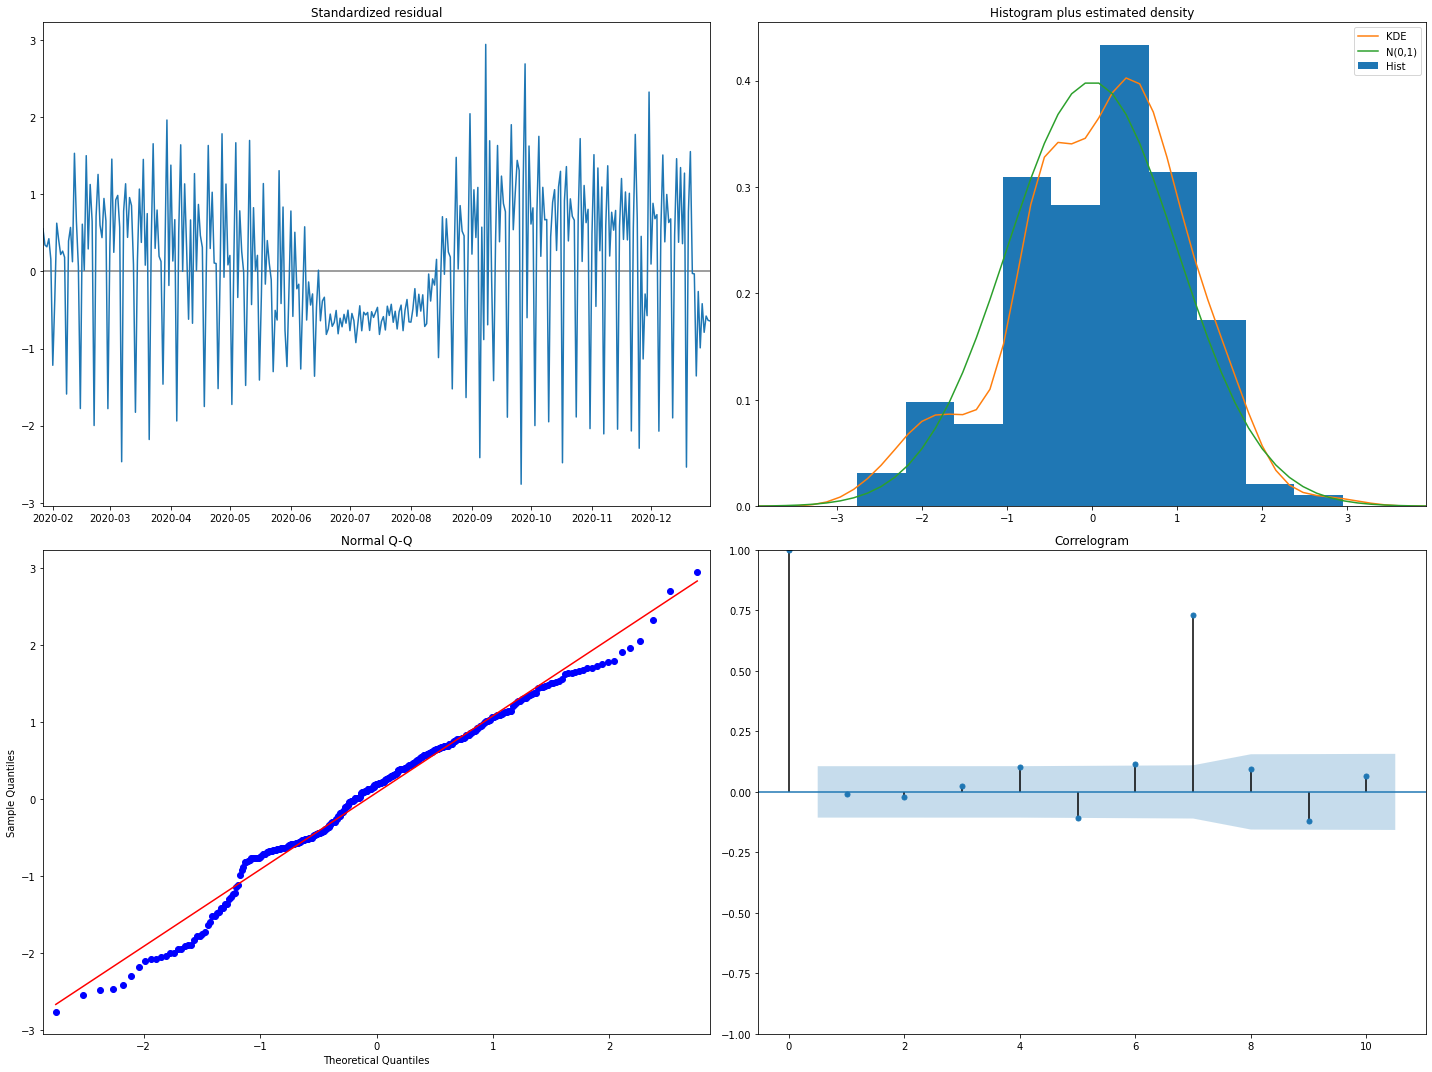

In [ ]:
results.plot_diagnostics(figsize=(20, 15));
plt.tight_layout();

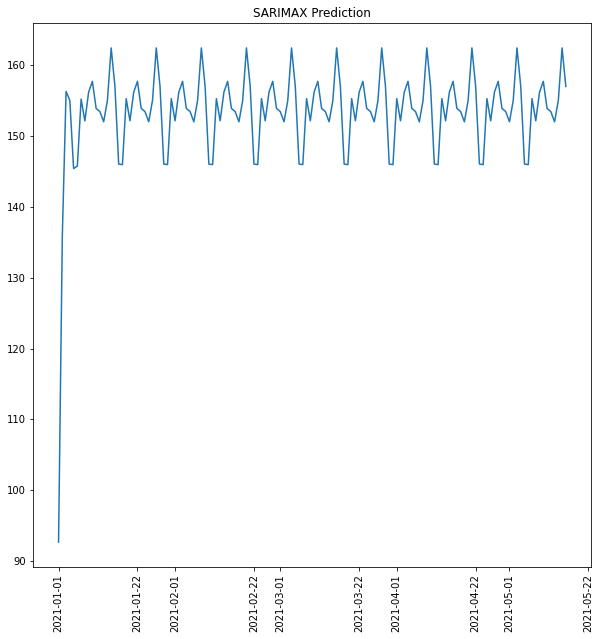

In [ ]:
# Create forecast object
forecast_object = results.get_forecast(136)

# Extract predicted mean attribute
mean = forecast_object.predicted_mean

# Calculate the confidence intervals
conf_int = forecast_object.conf_int()

# Extract the forecast dates
dates = mean.index



plt.figure(figsize=(10,10))
plt.xticks(rotation=90)
plt.title("SARIMAX Prediction")
# Plot the prediction means as line
plt.plot(mean);



***Prophet: Prophet, which was released by Facebook’s Core Data Science team, is an open-source library developed by Facebook and designed for automatic forecasting of univariate time series data.***

---



To use Prophet for forecasting, first create a Prophet() object and configure it, then execute the fit() function with the data to fit it on the dataset. The Prophet() object accepts inputs to customize the model type you desire, such as growth type, seasonality type, and more. By default, the model will try its hardest to figure out nearly everything on its own. A DataFrame containing time series data is sent to the fit() method. The DataFrame must be formatted in a specified way. The date-times must be in the first column, which must be named 'ds.' The observations must be in the second column, which must be named 'y'. This implies that the column names in the dataset are changed. It also necessitates the conversion of the first column to date-time objects, if not already done (for example, as part of loading the dataset using the appropriate read csv parameters).

In [ ]:
from fbprophet import Prophet

In [ ]:
df_pro = df_avg_t.rename(columns={'time':'ds', 'Averaged_index':'y'})

In [ ]:
m = Prophet()
m.fit(df_pro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Forcasting into the future
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01,144.000806,92.328000,267.319603,144.000806,144.000806,39.705301,39.705301,39.705301,39.705301,39.705301,39.705301,0.0,0.0,0.0,183.706107
1,2020-01-02,144.008062,93.790525,272.427386,144.008062,144.008062,39.384716,39.384716,39.384716,39.384716,39.384716,39.384716,0.0,0.0,0.0,183.392778
2,2020-01-03,144.015319,84.657443,267.335219,144.015319,144.015319,28.996561,28.996561,28.996561,28.996561,28.996561,28.996561,0.0,0.0,0.0,173.011879
3,2020-01-04,144.022575,-45.487646,142.032235,144.022575,144.022575,-95.012215,-95.012215,-95.012215,-95.012215,-95.012215,-95.012215,0.0,0.0,0.0,49.010359
4,2020-01-05,144.029831,-35.600606,136.393440,144.029831,144.029831,-93.967821,-93.967821,-93.967821,-93.967821,-93.967821,-93.967821,0.0,0.0,0.0,50.062010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,2021-12-27,345.207419,282.704772,467.502102,303.064380,385.015919,33.339762,33.339762,33.339762,33.339762,33.339762,33.339762,0.0,0.0,0.0,378.547182
727,2021-12-28,345.606545,291.323522,484.267307,303.334646,385.533639,47.553696,47.553696,47.553696,47.553696,47.553696,47.553696,0.0,0.0,0.0,393.160242
728,2021-12-29,346.005671,281.281213,478.267102,303.615813,386.051358,39.705301,39.705301,39.705301,39.705301,39.705301,39.705301,0.0,0.0,0.0,385.710972
729,2021-12-30,346.404798,288.352634,483.787053,303.809726,386.612179,39.384716,39.384716,39.384716,39.384716,39.384716,39.384716,0.0,0.0,0.0,385.789513


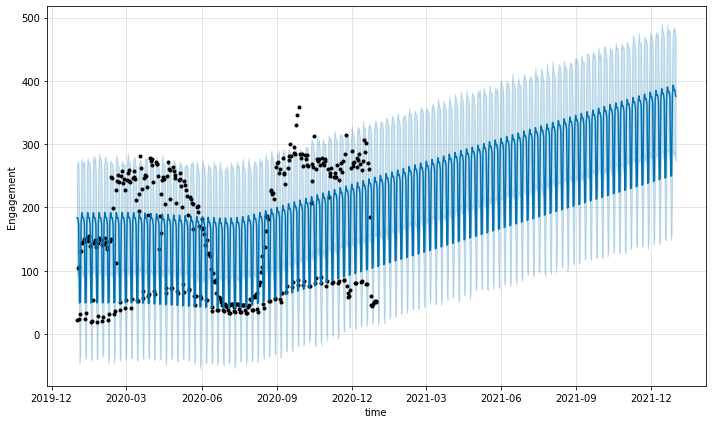

In [ ]:
figure = m.plot(forecast, xlabel='time', ylabel='Engagement')

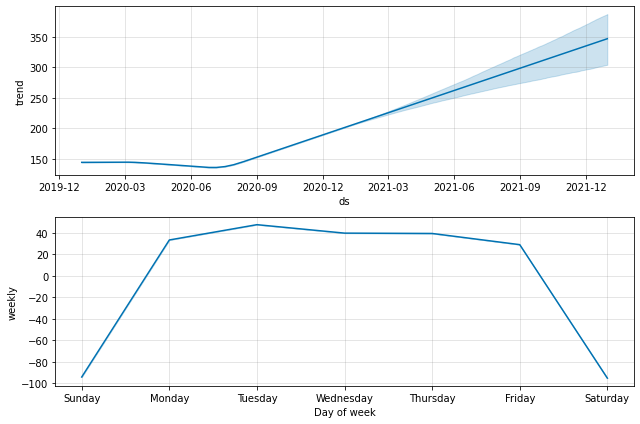

In [ ]:
figure3 = m.plot_components(forecast)

In [ ]:
from fbprophet.plot import plot_plotly
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'
from plotly.offline import init_notebook_mode, iplot
fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
df_cv = cross_validation(m, horizon='30 days')
df_p = performance_metrics(df_cv)
df_p.head(5)

INFO:fbprophet:Making 17 forecasts with cutoffs between 2020-04-05 00:00:00 and 2020-12-01 00:00:00


  0%|          | 0/17 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
0,3 days,3686.242636,60.714435,44.194179,0.419065,0.224191,0.666667
1,4 days,3199.313028,56.562470,42.634055,0.447786,0.321719,0.745098
2,5 days,4077.371936,63.854302,50.476191,0.629186,0.451727,0.666667
3,6 days,5870.739897,76.620754,62.150388,0.774352,0.582457,0.490196
4,7 days,7280.661732,85.326794,69.571544,0.831693,0.598912,0.352941


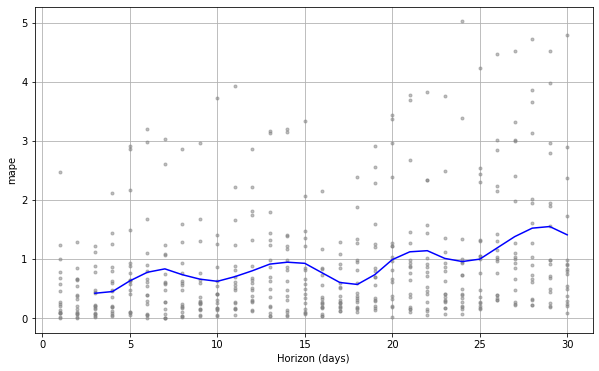

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig3 = plot_cross_validation_metric(df_cv, metric='mape')